# Описание задачи и файлов в директории

Цифровой прорыв 2022: Чемпионат, Тульская область
Задача: «Создание модели прогнозирования
заболеваемости населения»
Решение: Кагарманов Эрик

В рамках чемпионата участникам предлагается создать математическую модель, которая способна прогнозировать количество пациентов по каждому виду заболевания согласно международной классификации болезней, в привязке к населенному пункту, месяцу и половозрастным характеристикам на основе многолетних данных.

Описание входных значений
train.csv – набор данных для обучения
PATIENT_SEX – пол группы пациентов
MKB_CODE – первичный диагноз группы пациентов, код МКБ-10
ADRES – населенный пункт группы пациентов
VISIT_MONTH_YEAR – месяц и год постановки диагноза
AGE_CATEGORY – возрастная категория группы пациентов (Классификация
ВОЗ)
PATIENT_ID_COUNT – кол-во пациентов группе, которая характеризуется
вышеперечисленными признаками
test.csv – набор данных для тестирования
PATIENT_ID_COUNT – отсутствует, его необходимо определить
sample_solution.csv – формат отправки решения




# Imports

In [1]:
# %pip install pandas
# %pip install catboost
# %pip install sklearn
# %pip install matplotlib.pyplot
# %pip install seaborn
# %pip install rfpimp
# %pip install lightgbm

In [1]:
# работа с данными
import numpy as np
import pandas as pd

# валидация
from sklearn.model_selection import cross_validate, TimeSeriesSplit
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score

#визуализация
import seaborn as sns
import matplotlib.pyplot as plt 

#предобработка и шкалирование
from sklearn.preprocessing import StandardScaler, LabelEncoder

# алгоритмы обучения
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings("ignore")

c:\Users\Erik.K\anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
c:\Users\Erik.K\anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
c:\Users\Erik.K\anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


# Data: загрузка и обзор

In [3]:
#Считывание данных в DataFrame 

train = pd.read_csv('train_dataset_train.csv', sep=';', index_col=None, dtype={'PATIENT_SEX':str, 'MKB_CODE':str, 'ADRES':str, 'VISIT_MONTH_YEAR':str, 'AGE_CATEGORY':str, 'PATIENT_ID_COUNT':int})
test = pd.read_csv('test_dataset_test.csv', sep=';', index_col=None, dtype={'PATIENT_SEX':str, 'MKB_CODE':str, 'ADRES':str, 'VISIT_MONTH_YEAR':str, 'AGE_CATEGORY':str})

train['test'] = -1
test['test'] = test.index

df = pd.concat([train, test], axis = 0)

In [4]:
test.sort_values(by = ['VISIT_MONTH_YEAR', 'test'])

PATIENT_SEX MKB_CODE        ADRES VISIT_MONTH_YEAR AGE_CATEGORY   test
0               0      A00  Калининград            04.22     children      0
1               0      A00  Калининград            04.22      elderly      1
2               0      A00  Калининград            04.22    middleage      2
3               0      A00  Калининград            04.22        young      3
4               0      A01  Калининград            04.22    middleage      4
...           ...      ...          ...              ...          ...    ...
39368           1    Z96.6     Балтийск            04.22      elderly  39368
39369           1    Z96.6        Гусев            04.22    middleage  39369
39370           1    Z96.7        Гусев            04.22        young  39370
39371           1    Z98.8       Озерск            04.22     children  39371
39372           1    Z98.8   Черняховск            04.22     children  39372

[39373 rows x 6 columns]

In [5]:
df.columns = df.columns.map(lambda x: x.lower())

In [6]:
train.nunique()

PATIENT_SEX            2
MKB_CODE            7644
ADRES                118
VISIT_MONTH_YEAR      51
AGE_CATEGORY           6
PATIENT_ID_COUNT    1688
test                   1
dtype: int64

In [7]:
test.nunique()

PATIENT_SEX             2
MKB_CODE             4106
ADRES                  20
VISIT_MONTH_YEAR        1
AGE_CATEGORY            6
test                39373
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2251766 entries, 0 to 39372
Data columns (total 7 columns):
 #   Column            Dtype  
---  ------            -----  
 0   patient_sex       object 
 1   mkb_code          object 
 2   adres             object 
 3   visit_month_year  object 
 4   age_category      object 
 5   patient_id_count  float64
 6   test              int64  
dtypes: float64(1), int64(1), object(5)
memory usage: 137.4+ MB


In [9]:
df.isna().sum()

patient_sex             0
mkb_code                0
adres                   0
visit_month_year        0
age_category            0
patient_id_count    39373
test                    0
dtype: int64

In [10]:
df.nunique().sort_values()

patient_sex             2
age_category            6
visit_month_year       52
adres                 118
patient_id_count     1688
mkb_code             7665
test                39374
dtype: int64

In [11]:
df.isna().sum()

patient_sex             0
mkb_code                0
adres                   0
visit_month_year        0
age_category            0
patient_id_count    39373
test                    0
dtype: int64

In [12]:
df.sample(5)

patient_sex mkb_code        adres visit_month_year age_category  \
2186847           1    Z22.8  Калининград            01.21    middleage   
1150658           0    S93.4   Пионерский            05.21        young   
208391            0    F23.0  Калининград            12.18        young   
465677            0    I83.9   Черняховск            12.21        young   
2109556           1    T92.9  Калининград            02.21        young   

         patient_id_count  test  
2186847               1.0    -1  
1150658               1.0    -1  
208391                3.0    -1  
465677                1.0    -1  
2109556               1.0    -1

# Даты

In [13]:
# извлекаем месяц, год, создаём временной ряд
df['month'] = df['visit_month_year'].str.split('.').apply(lambda x: x[0]).astype(int)
df['year'] = df['visit_month_year'].str.split('.').apply(lambda x: x[1]).astype(int)
df['time_series'] = df['month'] + df['year']*12 - (df['month'] + df['year']*12).min()

df = df.sort_values(by = ['test','time_series'])

# Города и населённые пункты

Изучим распределение количества заболеваний по городам, сразу постараемся генерировать полезные признаки и преобразовывать данные для будущей модели.

In [14]:
df['adres'] = df['adres'].apply(lambda x: x.replace(' ', '_').replace('-', '_').replace('.', ''))
adress_value_counts = df.groupby(['adres']).patient_id_count.sum().sort_values(ascending = False)
all_adresses = adress_value_counts.index
tops = adress_value_counts[:23].index
rest = adress_value_counts[23:].index

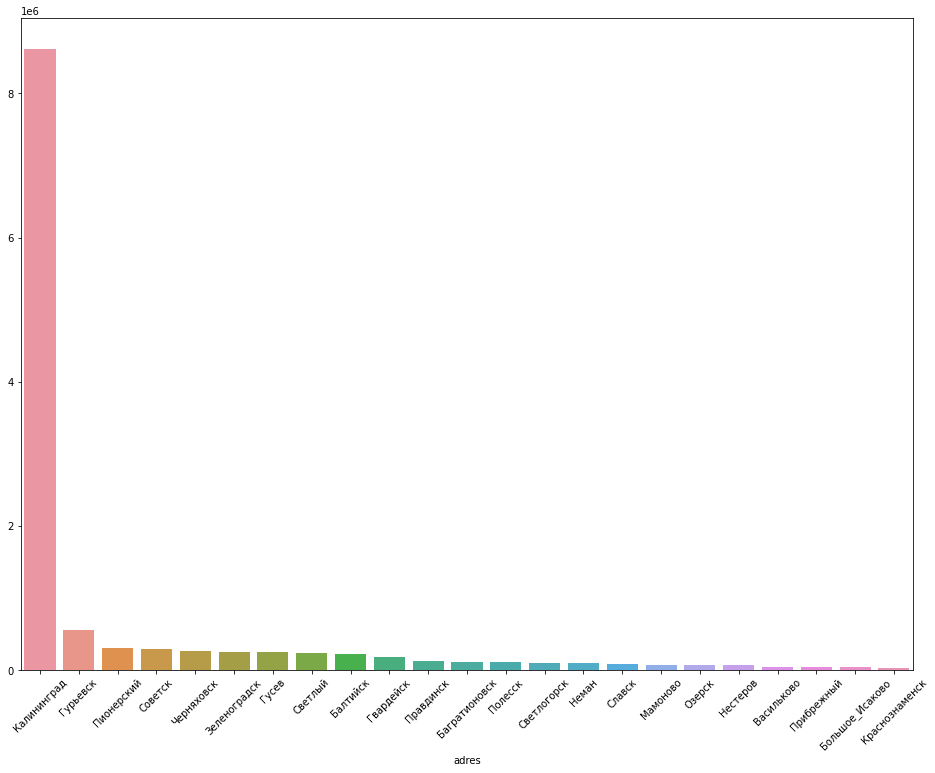

In [15]:
fig, ax = plt.subplots(figsize = (16, 12))
sns.barplot(tops, adress_value_counts[tops].values)
plt.xticks(rotation = 45)
plt.show()

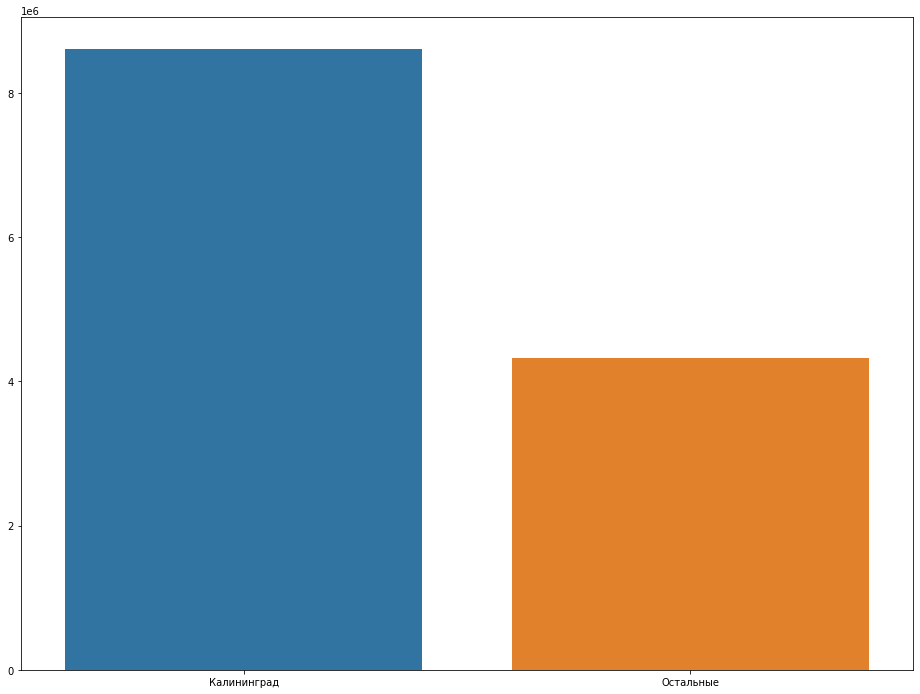

In [16]:
Kal_and_rest = adress_value_counts[:1].append(pd.Series(dict(Остальные = adress_value_counts[1:].sum())))

fig, ax = plt.subplots(figsize = (16, 12))
sns.barplot(Kal_and_rest.index, Kal_and_rest.values)
plt.show()

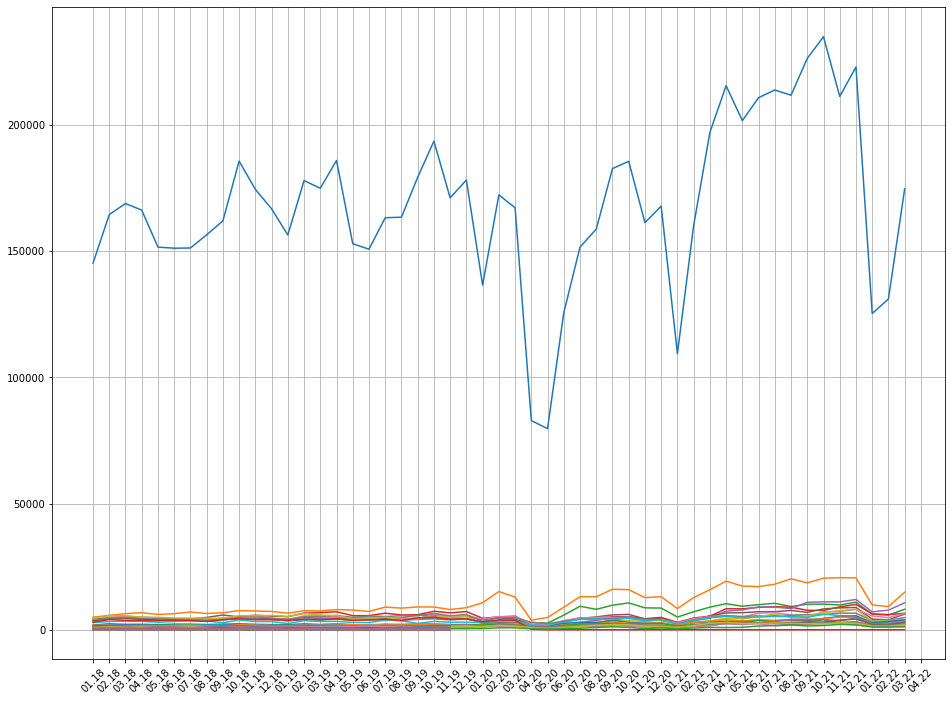

In [17]:
fig, ax = plt.subplots(figsize = (16, 12))

for point in all_adresses:
    plt.plot(df[df.adres == point].groupby('time_series').patient_id_count.sum()[:-1], label = point)

plt.xticks(df.groupby('time_series').patient_id_count.sum().index, df['visit_month_year'].unique(), rotation=45)
# plt.yscale('log')
# plt.legend()
plt.grid()
plt.show()

Предположим, что крупные скачки связаны с Ковид19. Оставим эту гипотезу до анализа mkb_code

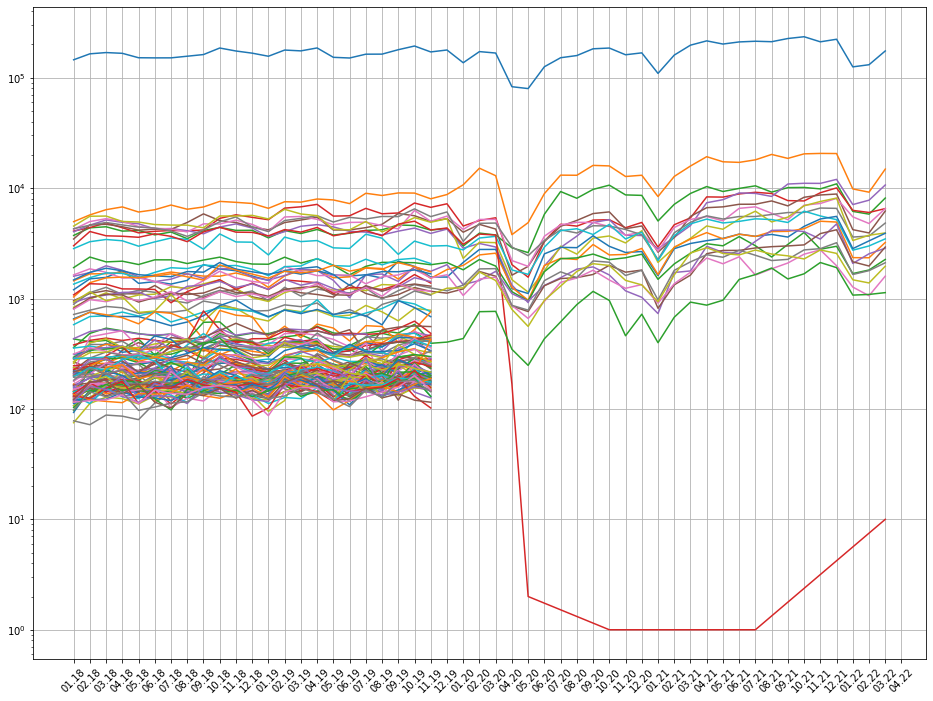

In [18]:
fig, ax = plt.subplots(figsize = (16, 12))

for point in all_adresses:
    plt.plot(df[df.adres == point].groupby('time_series').patient_id_count.sum()[:-1], label = point)

plt.xticks(df.groupby('time_series').patient_id_count.sum().index, df['visit_month_year'].unique(), rotation=45)
plt.yscale('log')
# plt.legend()
plt.grid()
plt.show()

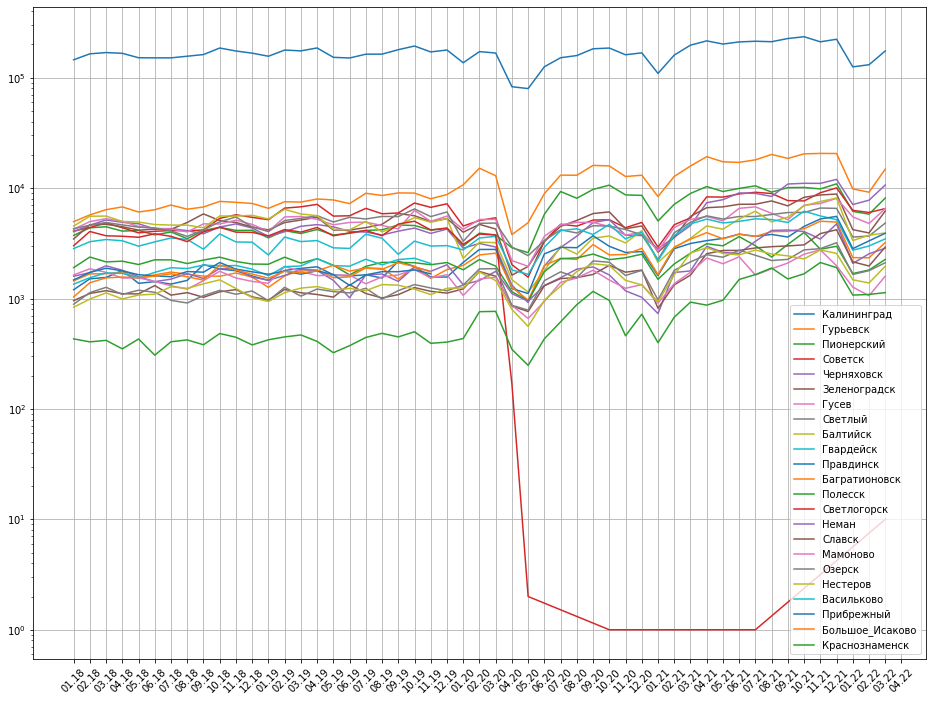

In [19]:
fig, ax = plt.subplots(figsize = (16, 12))

for point in tops:
    plt.plot(df[df.adres == point].groupby('time_series').patient_id_count.sum()[:-1], label = point)

plt.xticks(df.groupby('time_series').patient_id_count.sum().index, df['visit_month_year'].unique(), rotation=45)
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

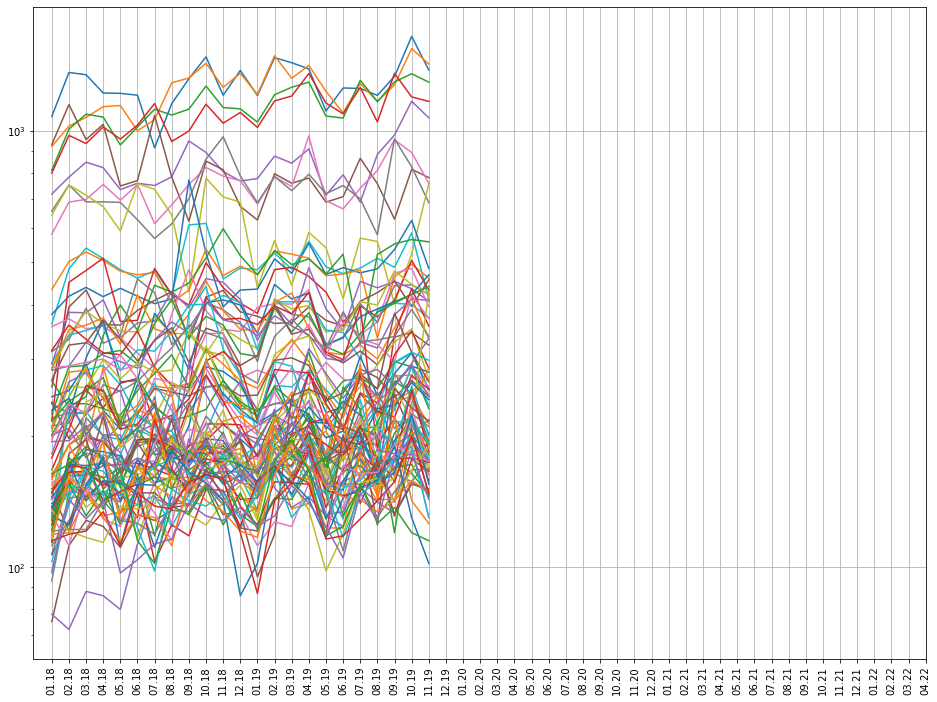

In [20]:
fig, ax = plt.subplots(figsize = (16, 12))

for point in rest:
    plt.plot(df[df.adres == point].groupby('time_series').patient_id_count.sum()[:-1], #label = point
    )

plt.xticks(df.groupby('time_series').patient_id_count.sum().index, df['visit_month_year'].unique(), rotation=90)
plt.yscale('log')
# plt.legend()
plt.grid()
plt.show()

In [21]:
df['time_series_24_flag'] = np.where(df['time_series'] >= 24, 1, 0)

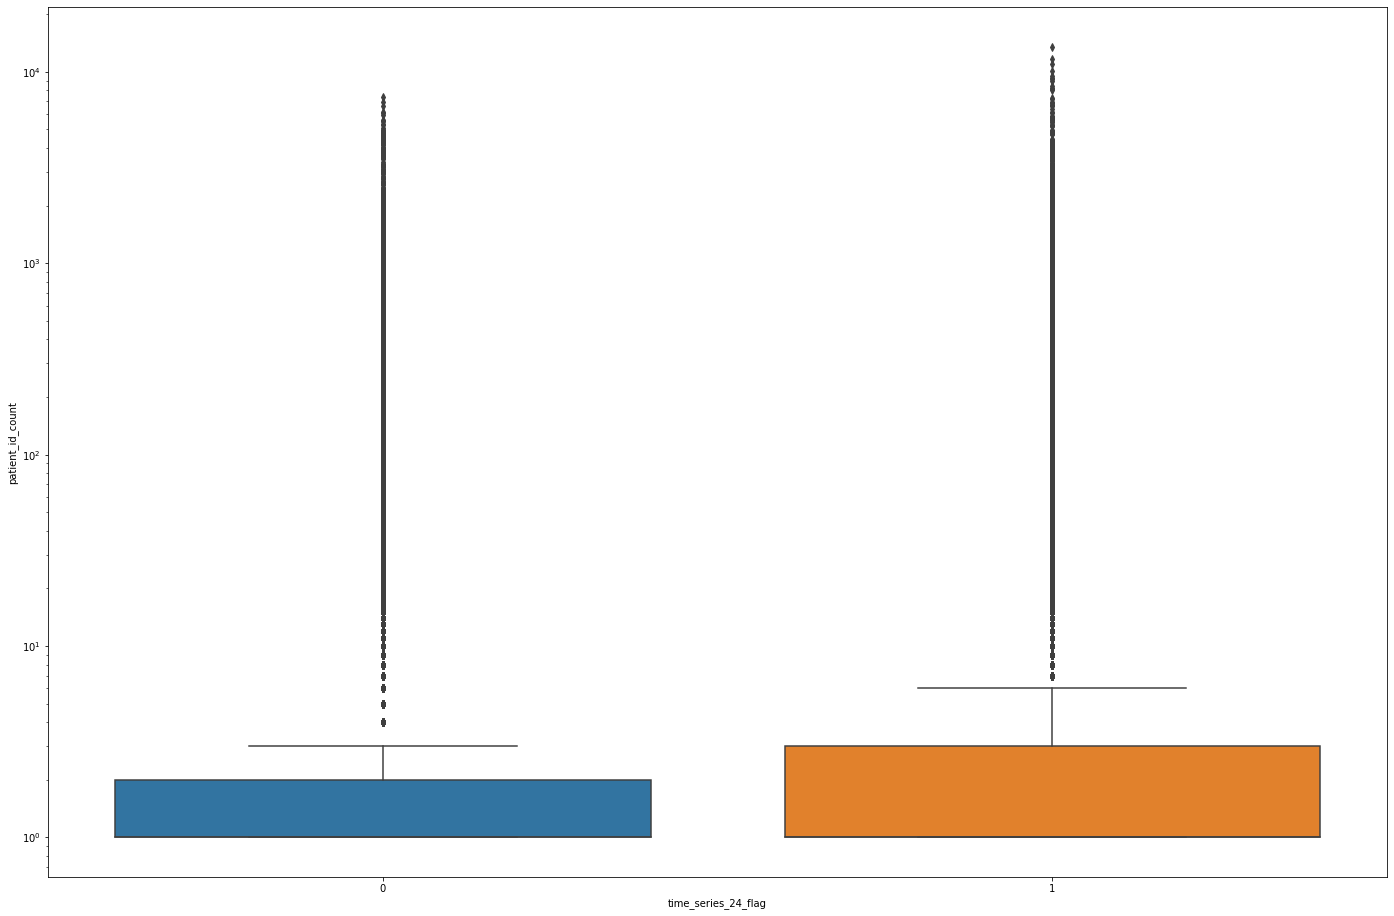

In [22]:
fig, ax = plt.subplots(figsize=(24, 16))
sns.boxplot(x="time_series_24_flag", y="patient_id_count", data=df)
plt.yscale('log')
plt.show()

In [23]:
adres_24 = df[df.time_series_24_flag == 1].adres.unique()
no_adres_24 = df[~df.adres.isin(adres_24)].adres.unique()

In [24]:
df['no_adres_24'] = np.where(df.adres.isin(no_adres_24), 1, 0)

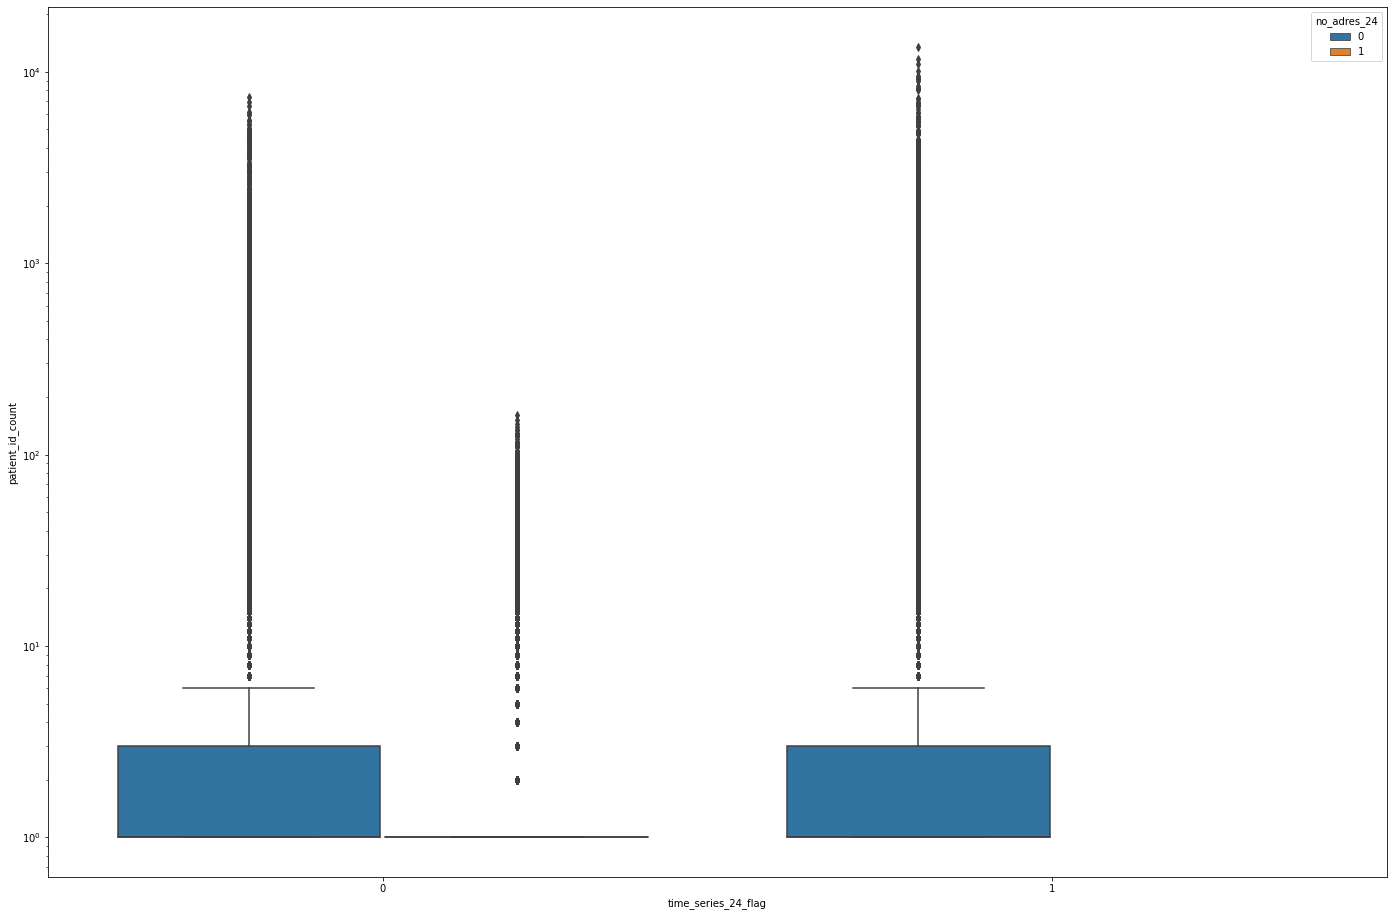

In [25]:
fig, ax = plt.subplots(figsize=(24, 16))
sns.boxplot(x="time_series_24_flag", y="patient_id_count", hue = 'no_adres_24', data=df)
plt.yscale('log')
plt.show()

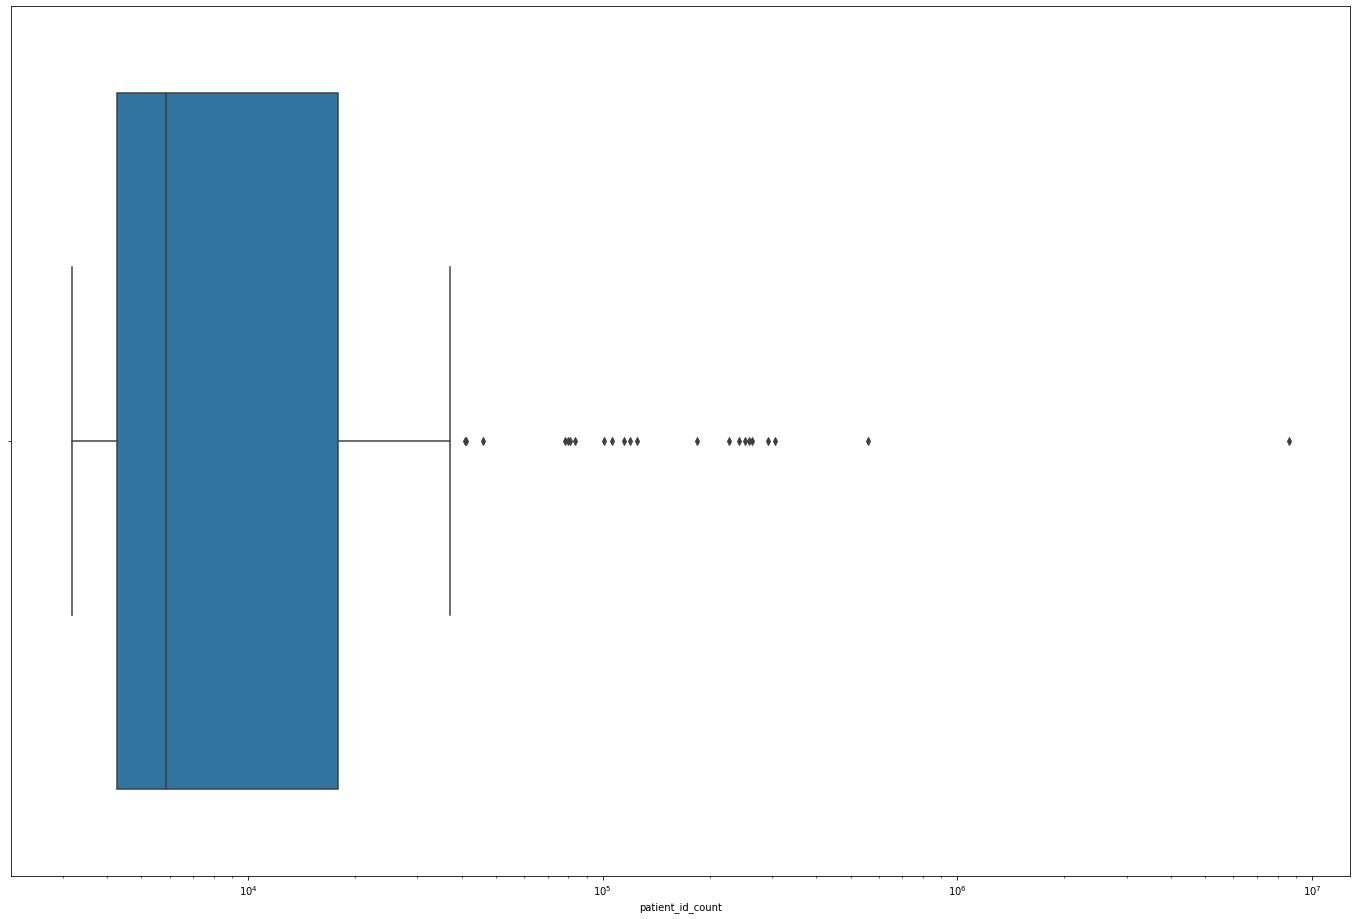

In [26]:
fig, ax = plt.subplots(figsize=(24, 16))
sns.boxplot(df.groupby(['adres']).patient_id_count.sum())
plt.xscale('log')
plt.show()

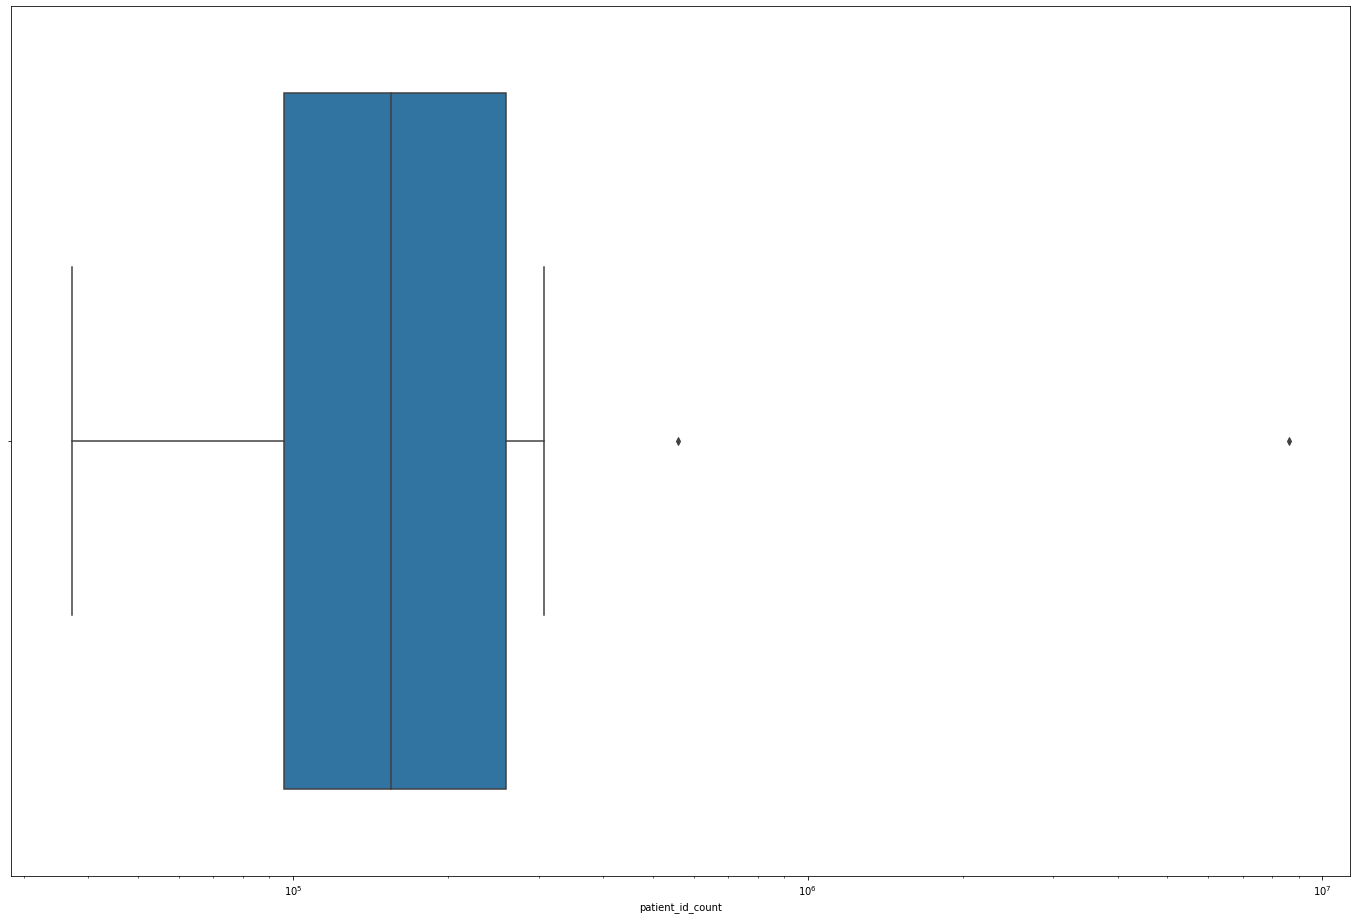

In [27]:
fig, ax = plt.subplots(figsize=(24, 16))
sns.boxplot(df[df.adres.isin(adres_24)].groupby(['adres']).patient_id_count.sum())
plt.xscale('log')
plt.show()

Промежуточные наблюдения: в данных есть города, наблюдение за которыми закончилось в начале 2020года. Вне зависимости от причины мы увилели, что если мы избавимся от большинства мелких уникальных категорий городов, то мы увеличим читаемость данных, а также облегчим дальнейший анализ и генерацию новых признаков. Не будем просто выкидывать данные, т.к. они могут соджержать часть полезной информации по кодам МКБ-10. Объеденим их с ближлежащими городами побольше. Для этого соберём информацию о долготе и широте населённых пунктов и населению крупных населённых пунктов.

In [28]:
# данные взяты с https://yandex.ru/maps
points = dict(
    Калининград = [54.710162, 20.510137],
    Черняховск = [54.630706, 21.819503],
    Гурьевск = [54.770401, 20.608359],
    Советск = [55.081034, 21.888656],
    Гусев = [54.591841, 22.201117],
    Пионерский = [54.951415, 20.226898],
    Балтийск = [54.643775, 19.894477],
    Зеленоградск = [54.960075, 20.475040],
    Светлый = [54.673268, 20.131093],
    Гвардейск = [54.647708, 21.071341],
    Светлогорск = [54.944218, 20.156075],
    Нестеров = [54.631368, 22.571366],
    Багратионовск = [54.386514, 20.639647],
    Правдинск = [54.446340, 21.018817],
    Славск = [55.044345, 21.682088],
    Полесск = [54.862782, 21.109888],
    Неман = [55.038841, 22.028146],
    Озерск = [54.408513, 22.013530],
    Большое_Исаково = [54.718203, 20.608799], # Гурьевский МО
    Васильково = [54.743671, 20.582649], # Гурьевский МО
    Мамоново = [54.462922, 19.941485],
    Краснознаменск = [54.942149, 22.490590],
    Ладушкин = [54.569121, 20.172954],
    Малое_Исаково = [54.733858, 20.583817], # Гурьевский МО
    Донское = [54.935576, 19.968579], # Светлогорский ГО
    Прибрежный = [54.647854, 20.340059], # Калининград
    Янтарный = [54.866591, 19.938557],
    Железнодорожный = [54.360931, 21.305317], # Правдинский МО
    Луговое = [54.653688, 20.627008], # Гурьевский МО
    Знаменск = [54.613035, 21.225573], # Гвардейский МО
    Калининградская = [54.707390, 20.507307], # Калининград. область??? 
    СТ_Победа = [54.764553, 20.511395], # Калининград
    Нивенское = [54.584547, 20.568563], # Багратионовск МО
    Большаково = [54.875755, 21.652578], # Славский МО
    Озерки = [54.629575, 20.892370], # Гвардейский МО
    Шоссейное = [54.665552, 20.428336], # Гурьевский МО
    Малое_Луговое = [54.659568, 20.643474], # Гурьевский МО
    Крылово = [54.330906, 21.551958], # Правдинск МО
    Взморье = [54.699118, 20.246032], # Светловский ГО, т.е. Светлый
    Голубево = [54.613322, 20.392197], # Гурьевский МО
    Новостроево = [54.443036, 21.832421], # Озёрский МО
    СТ_Искра_ул_Тюльпановая = [54.757934, 20.524905], # Калининград
    Приморск = [54.729351, 20.006964], 
    Константиновка = [54.801592, 20.690222], # Гурьевский МО
    Владимирово = [54.558341, 20.531903], # Багратионовский МО
    Некрасово = [54.901900, 20.676882], # Гурьевский МО
    Долгоруково = [54.424367, 20.5192910],  # Багратионовский МО
    Храброво = [54.897562, 20.571698], # Гурьевский МО
    Малое_Васильково = [54.745573, 20.613147], # Гурьевский МО
    Рыбное = [54.654199, 20.676595], # Гурьевский МО
    Холмогоровка = [54.788673, 20.411897], # Зеленоградский МО
    Славянское = [54.678146, 20.723577], # Гурьевский МО
    Невское = [54.741202, 20.566713], # Гурьевский МО
    Тургенево = [54.842470, 21.025887], # Полесский МО
    Ласкино = [54.650292, 20.445988], # Гурьевский МО
    Рассвет = [54.806107, 20.636692], # Гурьевский МО
    Ушаково = [54.608979, 20.235639], # Гурьевский МО
    СТ_Чайка = [54.699581, 20.589566], # Калининград
    Коврово = [54.909701, 20.402258], # Зеленоградский МО
    Партизанское = [54.592305, 20.623406], # Багратионовский МО
    СТ_Радуга = [54.660152, 20.523693], # Калининград
    Южный = [54.668645, 20.524375], # Калининград
    Тимирязево = [55.084977, 21.612693], # Славский МО. Есть ещё Тимирязево
    Ясное = [55.174846, 21.543945], # Славский МО
    Волочаевское = [54.699670, 20.222972], # Светлогорский ГО
    Саранское = [54.830892, 21.239740], #Полесский МО
    СТ_Колосок = [54.718634, 20.590087], # Калининград
    Илюшино = [54.576939, 22.519866], # Нестеровский МО
    Покровское = [54.847359, 19.959739], #Янтарный городской округ
    Сосновка = [54.931888, 20.510263], # Зеленоградск
    Северный = [54.568140, 20.598136], # Багратионовский МО
    Родники = [54.705085, 20.669902], # Гурьевский МО. Есть ещё два посёлка Родники
    Малинники = [54.723112, 20.748523], # Гурьевский МО
    Низовье = [54.700788, 20.741363], # Гурьевский МО
    Домново = [54.427698, 20.828536], # Правдинский МО
    Совхозное = [54.422528, 21.329580], # Правдинский МО. Есть ещё три посёлка Совхозное
    Добрино = [54.811788, 20.875581], # Гурьевский МО
    Фурманово = [54.605255, 22.146355], # Гусевский ГО
    Лесное = [54.632692, 20.548540], # Гурьевский МО. Есть ещё Лесное 
    Муромское = [54.896097, 20.493976], # Зеленоградский МО
    Маршальское = [54.875936, 20.734312], # Гурьевский МО
    Приморье = [54.941074, 20.039501],
    Матросово = [54.858663, 20.585622], # Гурьевский МО. Есть еще Матросово
    Корнево = [54.446062, 20.290337], # Багратионовский МО
    Петрово = [54.804970, 20.417009], # Гурьевский МО
    Ясная_Поляна = [54.567206, 22.446869], # Нестеровский МО
    Комсомольск = [54.626959, 20.755629], # Гвардейский МО
    Высокое = [54.702339, 20.797715], # Гурьевский МО
    Заливино = [54.896641, 21.061101], # Полесский МО
    Мельниково = [54.873693, 20.470225], # Зеленоградский МО
    Березовка = [54.633239, 20.843160], # Гвардейский МО
    Садовое = [54.505691, 20.450426], # Багратионовский МО
    Пригородное = [54.664323, 21.040044], # Гвардейский МО
    Орловка = [54.793848, 20.528552], # Гурьевский МО
    Рощино = [54.906896, 20.369146], # Зеленоградский МО
    Заостровье = [54.950154, 20.257656], # Зеленоградский МО
    СТ_Железнодорожник = [54.672414, 20.563829], # Калининград
    Гурьевский = [54.786545, 20.659527], # Гурьевск. Вся область??? 
    Пятидорожное = [54.502659, 20.096202], # Багратионовский МО
    Раздольное = [54.547836, 20.145915], # Багратионовский МО. Есть ещё Раздольное
    Славинск = [54.751378, 21.081546],  # Гвардейский МО
    Люблино = [54.737647, 20.288397], # Светловский ГО, т.е. Светлый
    Новодорожный = [54.654990, 20.480789], # Гурьевский МО
    Заозерье = [54.719378, 20.642387], # Гурьевский МО
    Майское = [54.556665, 20.499824], # Багратионовский МО. Есть ещё Майское
    Дружный = [54.651620, 20.550049], # Гурьевский МО
    Первомайское = [54.798950, 20.731024], # Гурьевский МО. Есть ещё Первомайское
    Ново_Московское = [54.573156, 20.235558], # Багратионовский МО
    Прибрежное = [54.700034, 20.619651], # Гурьевский МО
    Колосовка = [54.800808, 20.304926], # Зеленоградский МО
    Залесье = [54.843813, 21.517705], # Полесский МО
    Малиновка = [54.945717, 20.441173], #Зеленоградск
    Дорожный = [54.806169, 20.514242], # Гурьевский МО
    Романово = [54.893871, 20.280024], # Зеленоградский МО
    Кумачево = [54.820981, 20.210728], # Зеленоградский МО
    Рыбачий = [55.155391, 20.850302], # Зеленоградский МО
    Переславское = [54.817791, 20.283815], # Зеленоградский МО
    Кострово = [54.737434, 20.095708], # Зеленоградский МО
)

In [29]:
# тыс человек, данные взяты с сайта Росстата, а конкретно из файла: Chisl_nasel_RF_MO_01-01-2022
popul = dict(
    Калининград = 498.3,
    Черняховск = 35.3,
    Гурьевск = 20.5,
    Советск = 38.5,
    Гусев = 27.7,
    Пионерский = 12.9,
    Балтийск = 34.3,
    Зеленоградск = 18.1,
    Светлый = 21.5,
    Гвардейск = 13.2,
    Светлогорск = 16.7,
    Нестеров = 3.9,
    Багратионовск = 6.4,
    Правдинск = 4,
    Славск = 3.9,
    Полесск = 7.0,
    Неман = 10.7,
    Озерск = 3.8,
    Мамоново = 8.1,
    Краснознаменск = 3.0
)

In [30]:
df['latitude'] = df['adres'].map(points).apply(lambda x: x[0])
df['longitude'] = df['adres'].map(points).apply(lambda x: x[1])
df['popul'] = df['adres'].map(popul).fillna(1)
df['popul_cf'] = df['popul'] / df['popul'].max()
df['popul_log_cf'] = np.log(df['popul']) / np.log(df['popul']).max()

In [31]:
find_distance = df.groupby(['adres'], as_index = False)['latitude', 'longitude', 'popul_log_cf'].mean()

for point in no_adres_24:
    min = 999
    for check in adres_24:
        lat1 = find_distance.loc[find_distance.adres == point, 'latitude'].iloc[0]
        lat2 = find_distance.loc[find_distance.adres == check, 'latitude'].iloc[0]
        long1 = find_distance.loc[find_distance.adres == point, 'longitude'].iloc[0]
        long2 = find_distance.loc[find_distance.adres == check, 'longitude'].iloc[0]
        cf = find_distance.loc[find_distance.adres == check, 'popul_log_cf'].iloc[0]

        distance = np.sqrt((lat1 - lat2)**2 + (long1 - long2)**2)
        distance_up = distance / cf

        if distance_up < min:
            min = distance_up
            area = check
        
    find_distance.loc[find_distance.adres == point, 'area'] = area
    find_distance.loc[find_distance.adres == point, 'distance'] = distance_up

In [32]:
find_distance['area'] = find_distance['area'].fillna(find_distance['adres'])
find_distance['distance'] = find_distance['distance'].fillna(0)

In [33]:
for point in find_distance.area.unique():
    min = 999
    check_areas = pd.Index(find_distance.area.unique()).drop(point)
    for check in check_areas:

        lat1 = find_distance.loc[find_distance.area == point, 'latitude'].iloc[0]
        lat2 = find_distance.loc[find_distance.area == check, 'latitude'].iloc[0]
        long1 = find_distance.loc[find_distance.area == point, 'longitude'].iloc[0]
        long2 = find_distance.loc[find_distance.area == check, 'longitude'].iloc[0]
        cf = find_distance.loc[find_distance.area == check, 'popul_log_cf'].iloc[0]

        distance = np.sqrt((lat1 - lat2)**2 + (long1 - long2)**2)
        distance_up = distance 

        if distance_up < min:
            min = distance_up
            area = check
        
    find_distance.loc[find_distance.area == point, 'area_nearest'] = area
    find_distance.loc[find_distance.area == point, 'distance_nearest'] = distance_up

In [34]:
find_distance = find_distance.fillna(0)

In [35]:
area_mapping = dict(zip(find_distance.adres, find_distance.area))
# distance_cap_mapping = dict(zip(find_distance.area, find_distance.distance_cap))
area_nearest_mapping = dict(zip(find_distance.area, np.log(find_distance.area_nearest.map(popul)) / np.log(find_distance.area_nearest.map(popul).max())))
distance_nearest_mapping = dict(zip(find_distance.area, find_distance.distance_nearest))

In [36]:
df['area'] = df['adres'].map(area_mapping)
# df['distance_cap'] = df['area'].map(distance_cap_mapping)
df['area_nearest'] = df['area'].map(area_nearest_mapping)
df['distance_nearest'] = df['area'].map(distance_nearest_mapping)

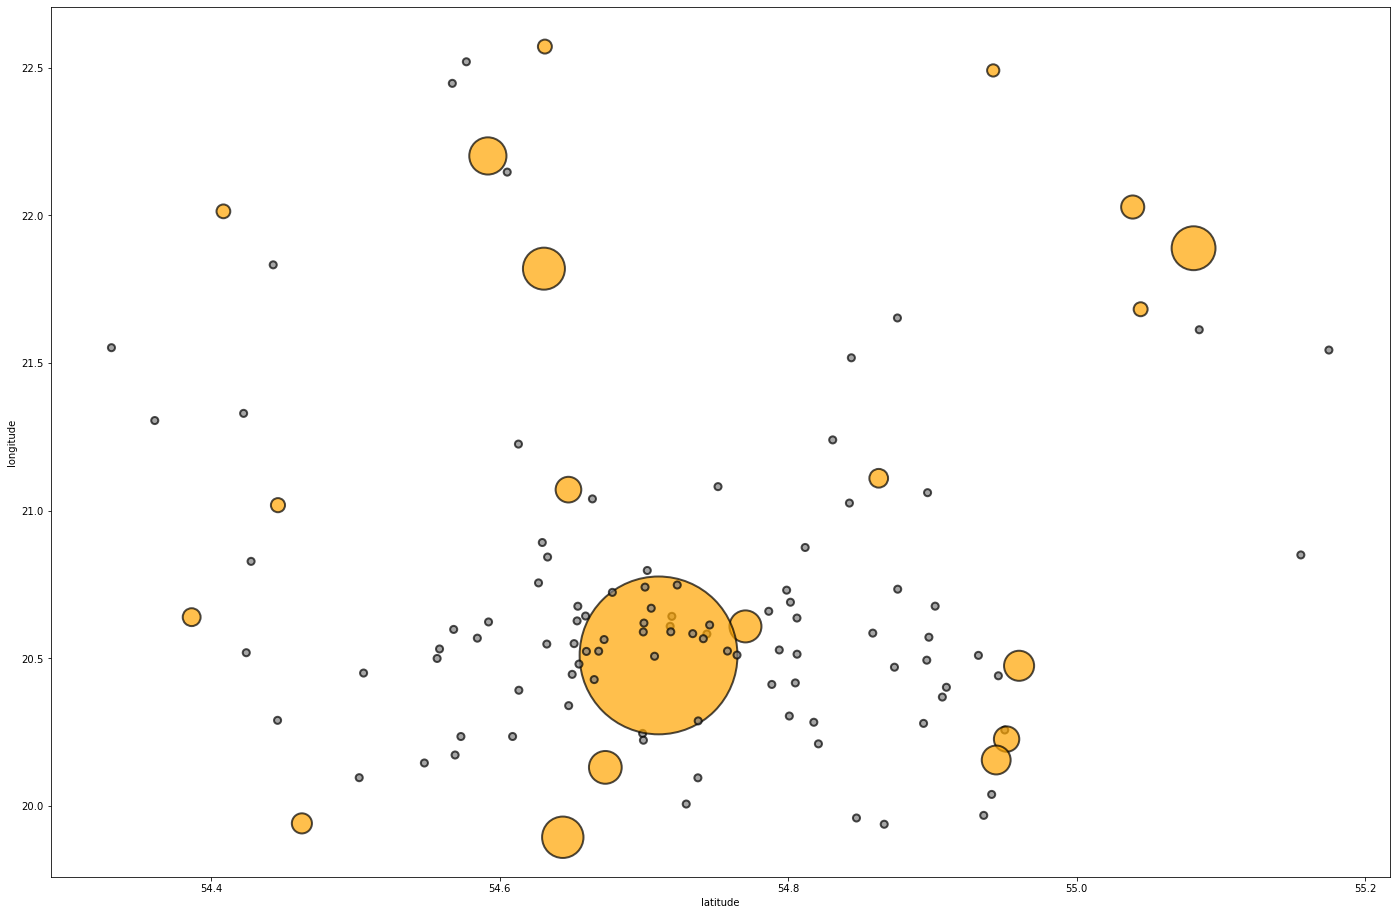

In [37]:
to_show = df.groupby(['adres', 'area'], as_index = False)['latitude','longitude', 'popul'].mean()

to_show.loc[to_show.adres.isin(no_adres_24), 'color'] = 'grey'
to_show.loc[to_show.adres.isin(adres_24), 'color'] = 'orange'

to_show['patient_sum'] = to_show.popul * 50

fig, ax = plt.subplots(figsize=(24, 16))
ax.scatter('latitude', 'longitude', c='color', s='patient_sum', data=to_show, edgecolor='black', linewidth=2, linestyle='-', alpha = 0.7)
ax.set_xlabel('latitude')
ax.set_ylabel('longitude')
plt.show()

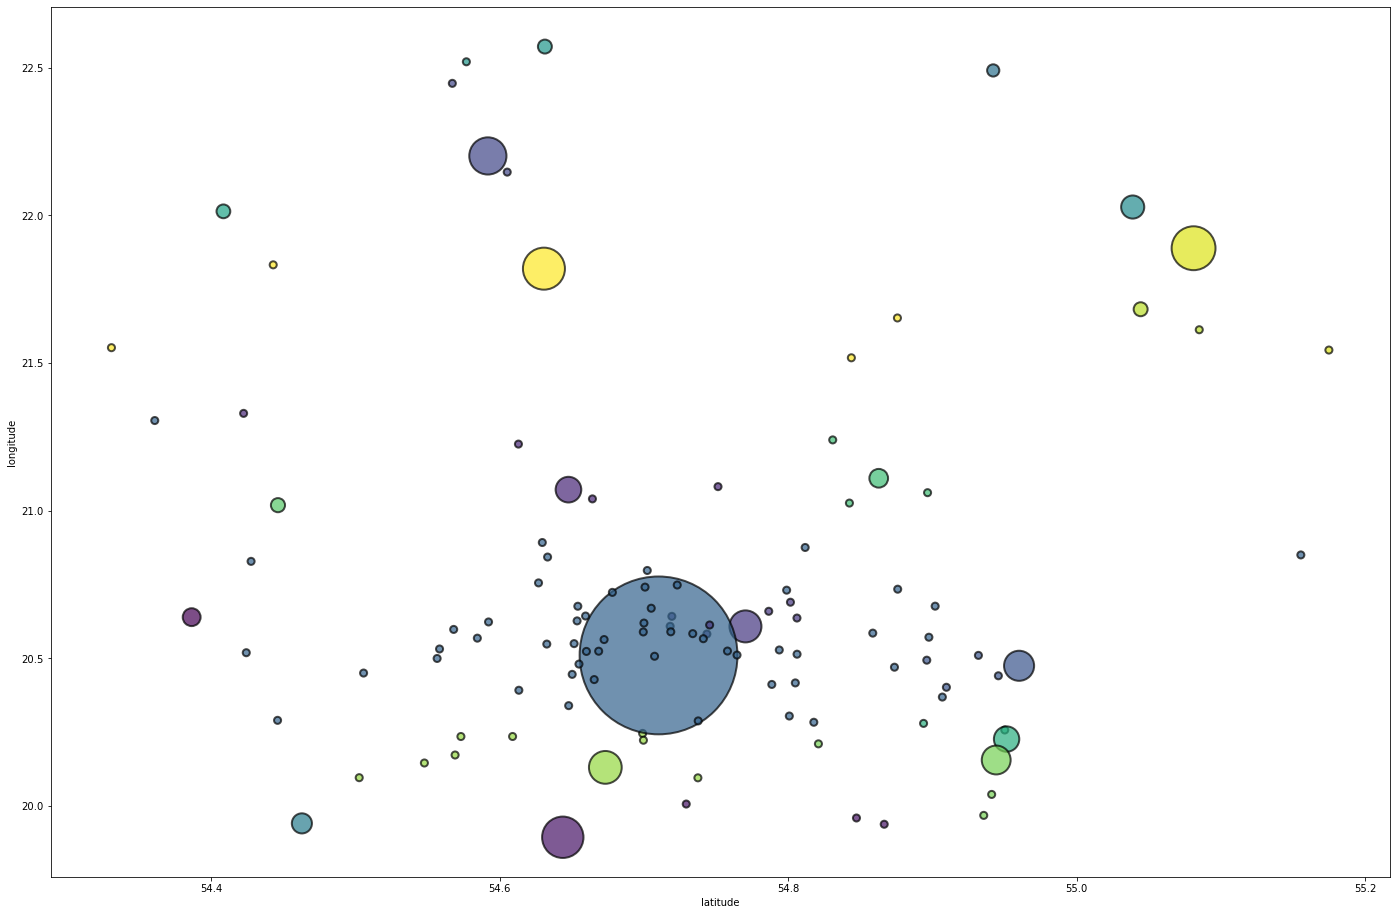

In [38]:
enc = LabelEncoder()

to_show = df.groupby(['adres', 'area'], as_index = False)['latitude','longitude', 'popul'].mean()
to_show['color'] = enc.fit_transform(to_show.area)

to_show['patient_sum'] = to_show.popul * 50

fig, ax = plt.subplots(figsize=(24, 16))
ax.scatter('latitude', 'longitude', c='color', s='patient_sum', data=to_show, edgecolor='black', linewidth=2, linestyle='-', alpha = 0.7)
ax.set_xlabel('latitude')
ax.set_ylabel('longitude')
plt.show()

In [39]:
df['latitude'] = df['area'].map(points).apply(lambda x: x[0])
df['longitude'] = df['area'].map(points).apply(lambda x: x[1])
df['popul'] = df['area'].map(popul).fillna(1)
df['popul_cf'] = df['popul'] / df['popul'].max()
df['popul_log_cf'] = np.log(df['popul']) / np.log(df['popul']).max()

In [40]:
left = df.groupby(['visit_month_year', 'area', 'age_category', 'patient_sex', 'mkb_code', 'test'], as_index = False)['patient_id_count'].sum()
right = df[[
    'visit_month_year', 'area', 'age_category', 'patient_sex', 'mkb_code', 
    'test', 'time_series', 'month', 'year', 'time_series_24_flag', 
    'latitude', 'longitude', 'popul_cf','popul_log_cf',
    'area_nearest', 'distance_nearest']].drop_duplicates()
df = left.merge(right, on = ['visit_month_year', 'area', 'age_category', 'patient_sex', 'mkb_code', 'test']).sort_values(['test', 'time_series', 'mkb_code']).reset_index(drop = True)
df

visit_month_year         area age_category patient_sex mkb_code  \
0                  01.18  Калининград     children           0      A02   
1                  01.18  Калининград     children           0    A02.0   
2                  01.18  Калининград     children           1    A02.0   
3                  01.18  Калининград      elderly           0    A02.0   
4                  01.18  Калининград        young           0    A02.0   
...                  ...          ...          ...         ...      ...   
1835645            04.22     Балтийск      elderly           1    Z96.6   
1835646            04.22        Гусев    middleage           1    Z96.6   
1835647            04.22        Гусев        young           1    Z96.7   
1835648            04.22       Озерск     children           1    Z98.8   
1835649            04.22   Черняховск     children           1    Z98.8   

          test  patient_id_count  time_series  month  year  \
0           -1               1.0            0      1    18   
1           -1               4.0            0      1    18   
2           -1               4.0            0      1    18   
3           -1               1.0            0      1    18   
4           -1               2.0            0      1    18   
...        ...               ...          ...    ...   ...   
1835645  39368               0.0           51      4    22   
1835646  39369               0.0           51      4    22   
1835647  39370               0.0           51      4    22   
1835648  39371               0.0           51      4    22   
1835649  39372               0.0           51      4    22   

         time_series_24_flag   latitude  longitude  popul_cf  popul_log_cf  \
0                          0  54.710162  20.510137  1.000000      1.000000   
1                          0  54.710162  20.510137  1.000000      1.000000   
2                          0  54.710162  20.510137  1.000000      1.000000   
3                          0  54.710162  20.510137  1.000000      1.000000   
4                          0  54.710162  20.510137  1.000000      1.000000   
...                      ...        ...        ...       ...           ...   
1835645                    1  54.643775  19.894477  0.068834      0.569156   
1835646                    1  54.591841  22.201117  0.055589      0.534749   
1835647                    1  54.591841  22.201117  0.055589      0.534749   
1835648                    1  54.408513  22.013530  0.007626      0.214934   
1835649                    1  54.630706  21.819503  0.070841      0.573783   

         area_nearest  distance_nearest  
0            0.415413          1.137358  
1            0.415413          1.137358  
2            0.415413          1.137358  
3            0.415413          1.137358  
4            0.415413          1.137358  
...               ...               ...  
1835645      0.336789          2.041555  
1835646      0.214934          0.580467  
1835647      0.214934          0.580467  
1835648      0.534749          0.684016  
1835649      0.219116          0.312845  

[1835650 rows x 17 columns]

Помимо этого у нас есть аномальный Светлогорск, если посмотрим на количество уникальных значений и сумму к концу временного ряда, то узнаем, что на каждый код приходится всего 1 диагноз. В тесте всего 20 меток из города Светлороск. Мы заменим их в ручном режиме на единицы. А сейчас для повышения эффективности модели - удалим.

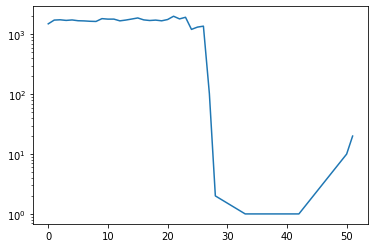

In [41]:
plt.plot(df[df.area == 'Светлогорск'].groupby('time_series').patient_id_count.count())
plt.yscale('log')

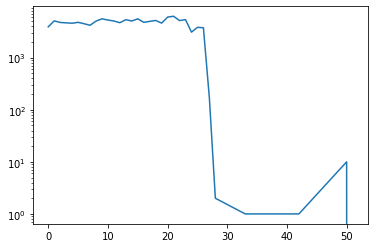

In [42]:
plt.plot(df[df.area == 'Светлогорск'].groupby('time_series').patient_id_count.sum())
plt.yscale('log')

In [43]:
df = df.drop(df[df.area == 'Светлогорск'].index).sort_values(by = ['time_series','test']).reset_index(drop = True)

# Диагнозы

Разделим код МКБ на три признака: первую букву кода, три первых символа кода и весь код (изначальный признак). Также добавим признак только с 3 символами.

In [44]:
df[df.mkb_code.apply(len) == 3].mkb_code.apply(lambda x: x[0])
df['litera_mkb_code'] = df.mkb_code.apply(lambda x: x[0])
df['litera_2nums_mkb_code'] = df.mkb_code.apply(lambda x: x[:3])
df['not_full_mkb_code'] = (df.mkb_code.apply(len) == 3).astype(int)

In [45]:
df.nunique()

visit_month_year            52
area                        19
age_category                 6
patient_sex                  2
mkb_code                  7653
test                     39354
patient_id_count          1730
time_series                 52
month                       12
year                         5
time_series_24_flag          2
latitude                    19
longitude                   19
popul_cf                    18
popul_log_cf                18
area_nearest                13
distance_nearest            18
litera_mkb_code             25
litera_2nums_mkb_code     1623
not_full_mkb_code            2
dtype: int64

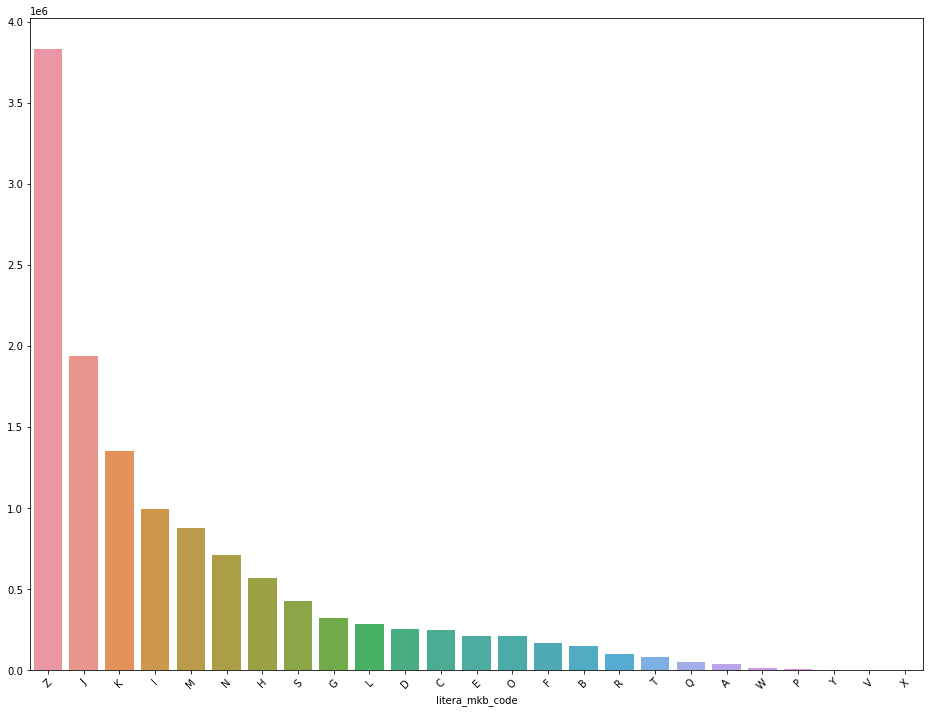

In [46]:
mkb_values = df.groupby(['litera_mkb_code']).patient_id_count.sum().sort_values(ascending = False)
all_mkb = mkb_values.index

fig, ax = plt.subplots(figsize = (16, 12))
sns.barplot(mkb_values.index, mkb_values.values)
plt.xticks(rotation = 45)
plt.show()

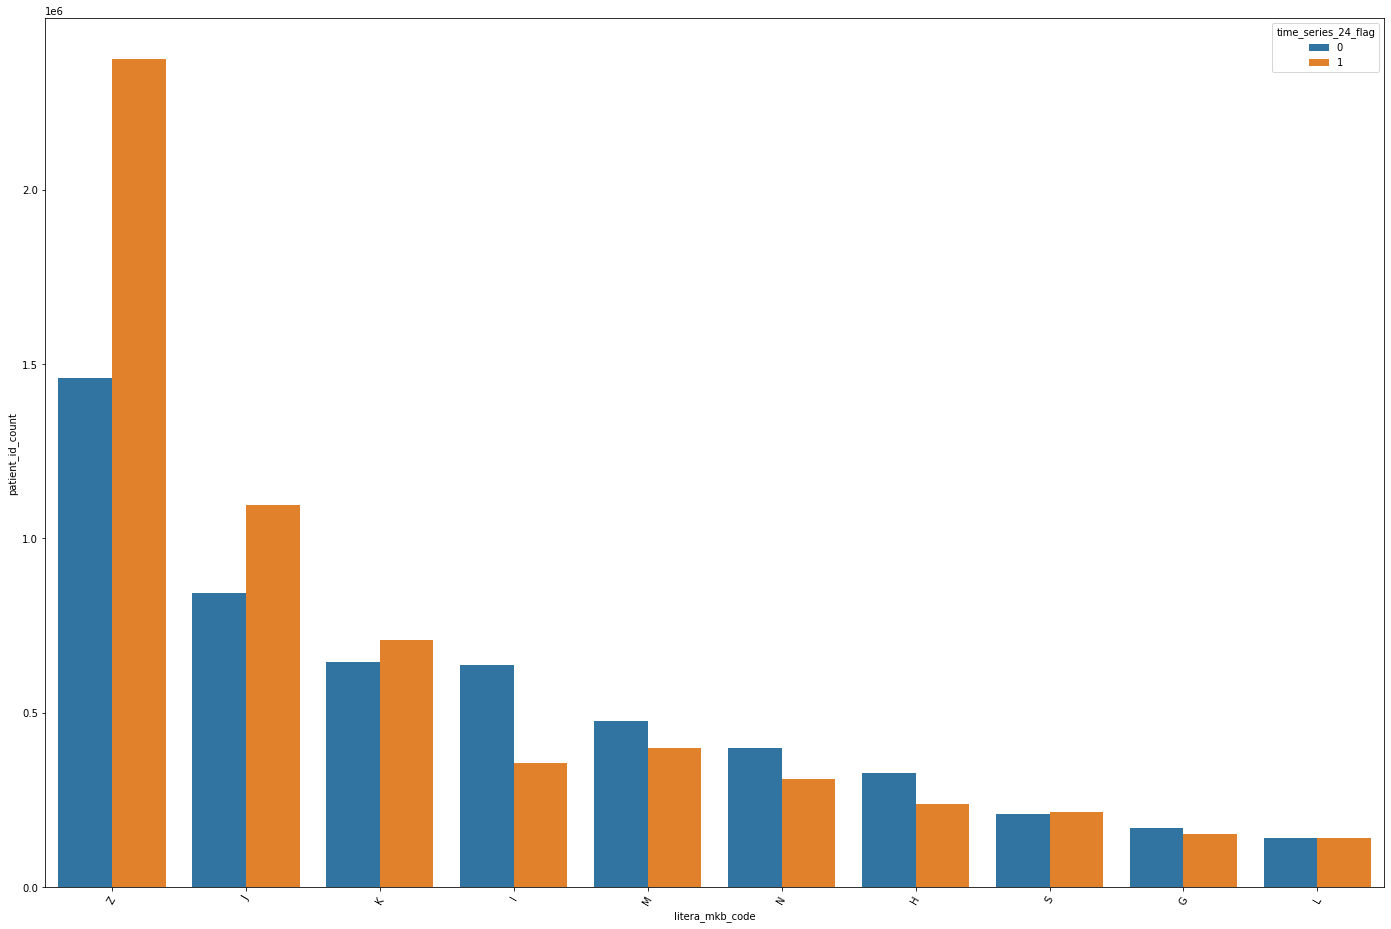

In [47]:
top_mkb = mkb_values.index[:10]
mkb_2num_24 = df[(df['litera_mkb_code'].isin(top_mkb))].groupby(
    ['litera_mkb_code', 'time_series_24_flag'], as_index = False).patient_id_count.sum().sort_values(by = 'patient_id_count', ascending = False)
fig, ax = plt.subplots(figsize = (24, 16))
sns.barplot(x = 'litera_mkb_code', y = 'patient_id_count', hue = 'time_series_24_flag', data = mkb_2num_24)
plt.xticks(rotation = 60)
plt.show()

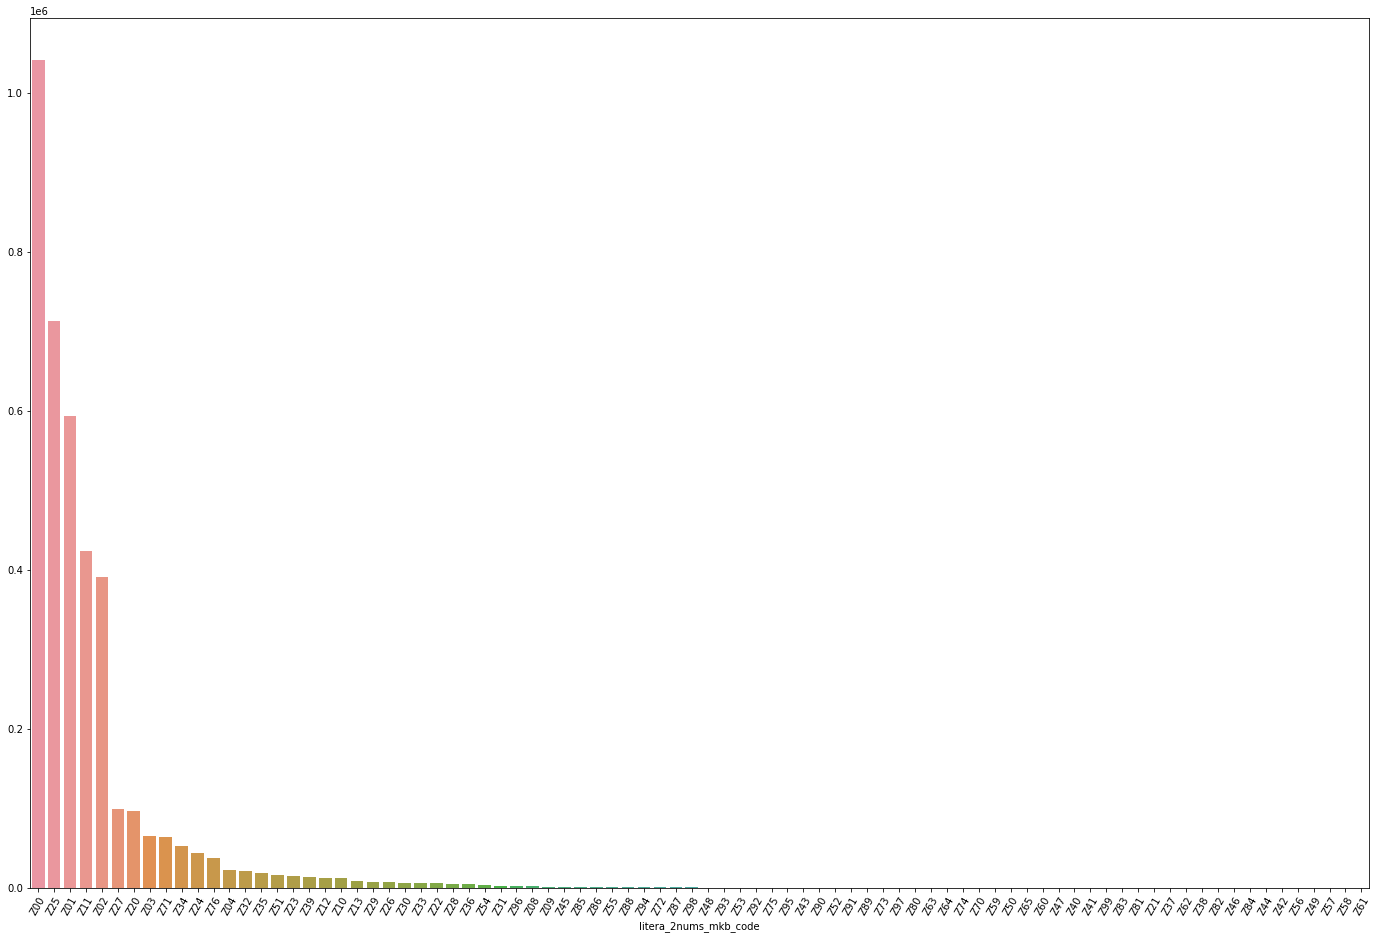

In [48]:
mkb_2num_value_counts = df[df['litera_mkb_code'] == 'Z'].groupby(['litera_2nums_mkb_code']).patient_id_count.sum().sort_values(ascending = False)
fig, ax = plt.subplots(figsize = (24, 16))
sns.barplot(mkb_2num_value_counts.index, mkb_2num_value_counts.values)
plt.xticks(rotation = 60)
plt.show()

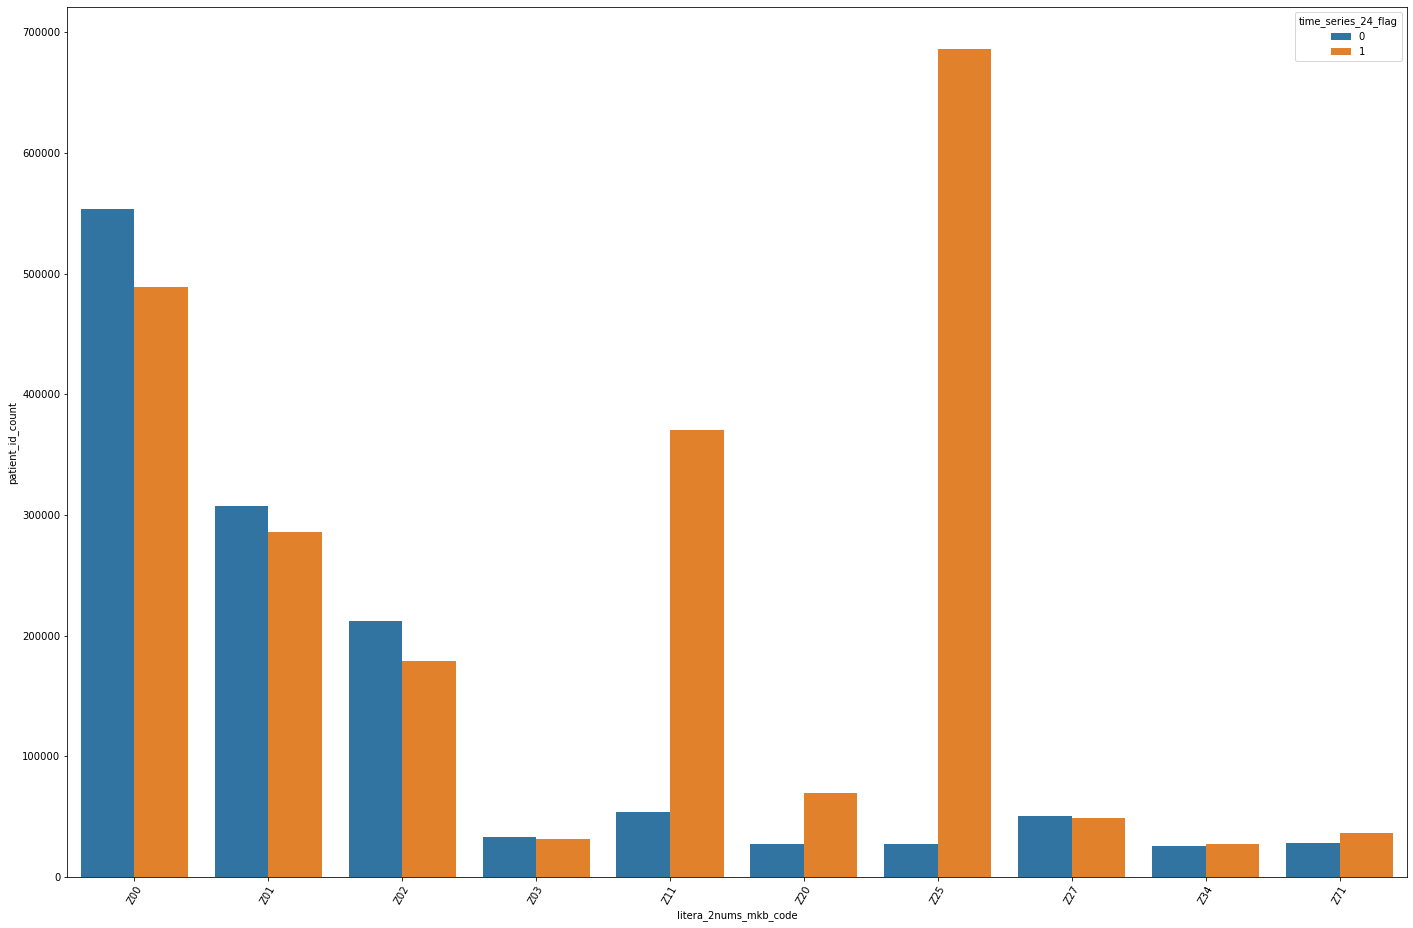

In [49]:
top_Z = mkb_2num_value_counts.index[:10]
mkb_2num_24 = df[(df['litera_mkb_code'] == 'Z') & (
    df['litera_2nums_mkb_code'].isin(top_Z))].groupby(['litera_2nums_mkb_code', 'time_series_24_flag'], as_index = False).patient_id_count.sum()
fig, ax = plt.subplots(figsize = (24, 16))
sns.barplot(x = 'litera_2nums_mkb_code', y = 'patient_id_count', hue = 'time_series_24_flag', data = mkb_2num_24)
plt.xticks(rotation = 60)
plt.show()

Z25 — Необходимость иммунизации против одной из других вирусных болезней  
Z20 — Контакт с больным и возможность заражения инфекционными болезнями  
Z11 — Специальное скрининговое обследование с целью выявления инфекционных и паразитарных болезней  

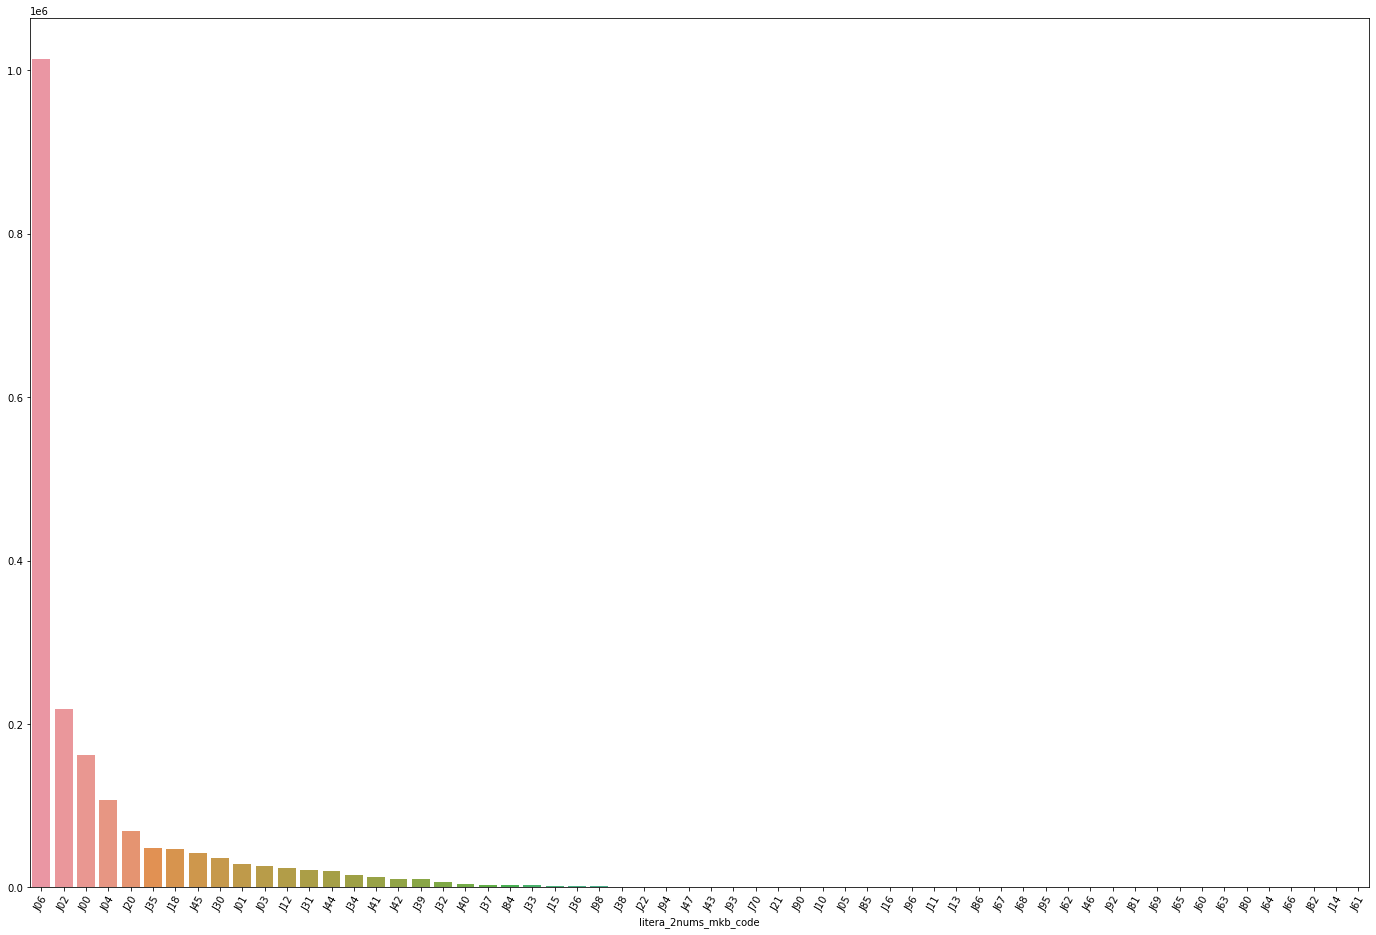

In [50]:
J_mkb_2num = df[df['litera_mkb_code'] == 'J'].groupby(['litera_2nums_mkb_code']).patient_id_count.sum().sort_values(ascending = False)
fig, ax = plt.subplots(figsize = (24, 16))
sns.barplot(J_mkb_2num.index, J_mkb_2num.values)
plt.xticks(rotation = 60)
plt.show()

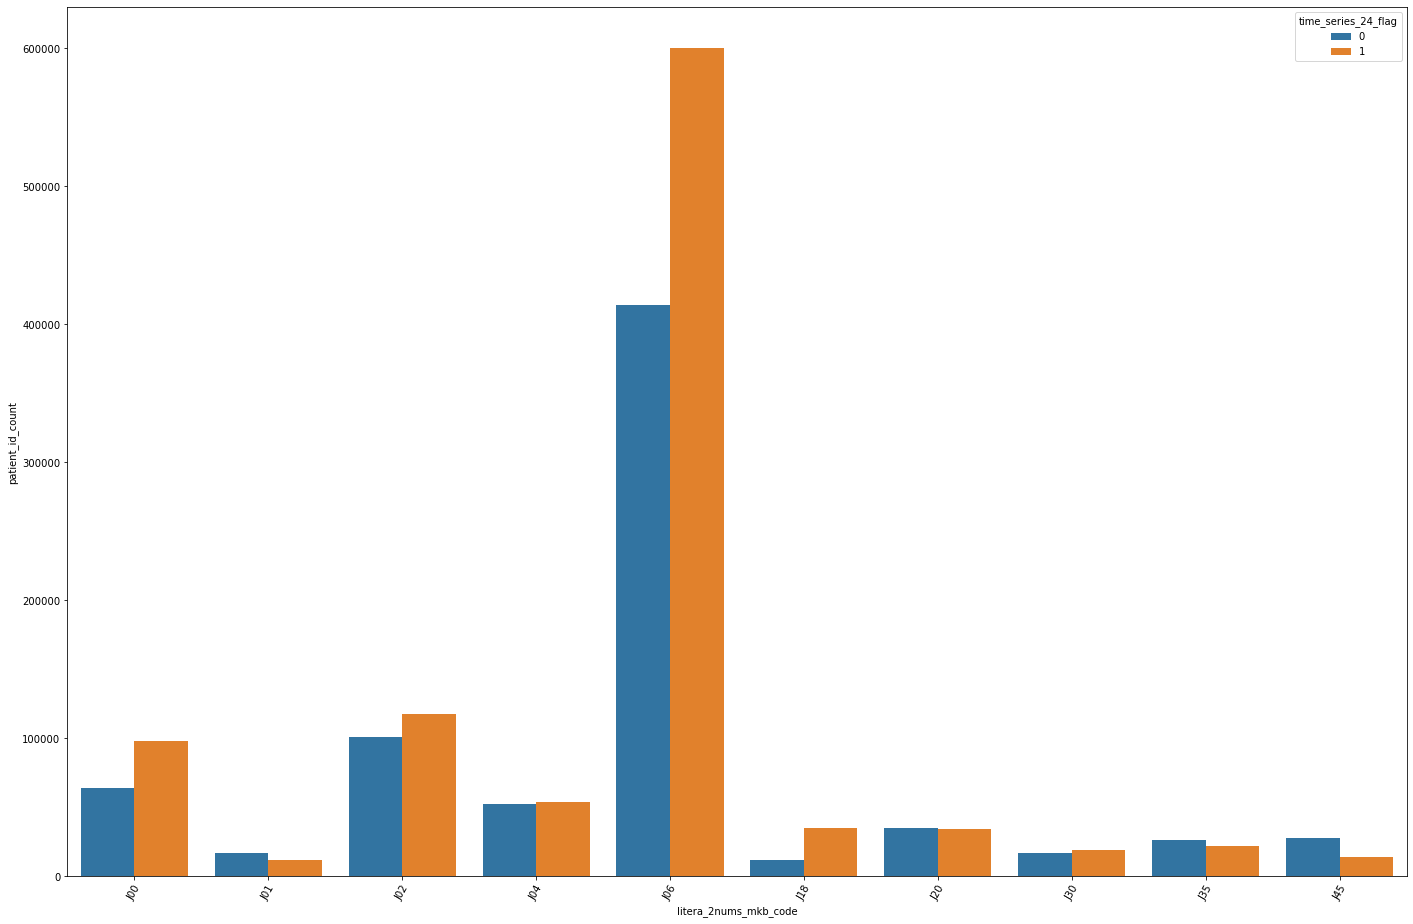

In [51]:
top_J = J_mkb_2num.index[:10]
mkb_2num_24 = df[(df['litera_mkb_code'] == 'J') & (
    df['litera_2nums_mkb_code'].isin(top_J))].groupby(['litera_2nums_mkb_code', 'time_series_24_flag'], as_index = False).patient_id_count.sum()
fig, ax = plt.subplots(figsize = (24, 16))
sns.barplot(x = 'litera_2nums_mkb_code', y = 'patient_id_count', hue = 'time_series_24_flag', data = mkb_2num_24)
plt.xticks(rotation = 60)
plt.show()

J06 — Острые инфекции верхних дыхательных путей множественной и неуточненной локализации

Гипотеза о Ковид19 подтвердилась. Мы видим увеличение связанных с ковидом болезней с начала 2020г. Возможно часть информации до 2020г. будет менее актуальной, чем нам хотелось бы, поэтому мы можем преобразовать эту часть, чтобы эффективнее решить задачу.

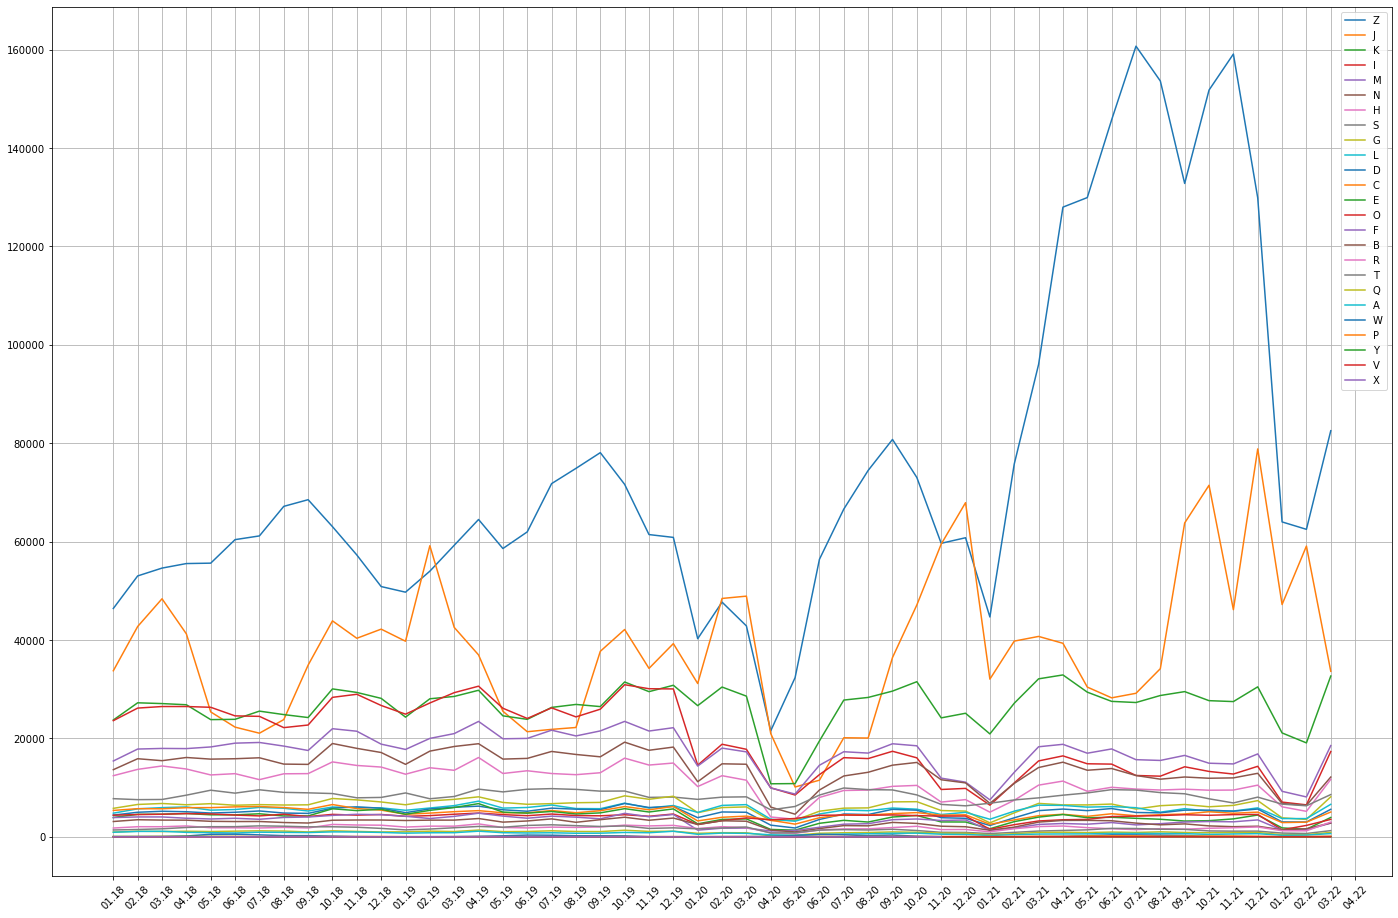

In [52]:
fig, ax = plt.subplots(figsize = (24, 16))

for mkb in all_mkb:
    plt.plot(df[df['litera_mkb_code'] == mkb].groupby('time_series').patient_id_count.sum()[:-1], label = mkb)

plt.xticks(df.groupby('time_series').patient_id_count.sum().index, df['visit_month_year'].unique(), rotation=45)
# plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

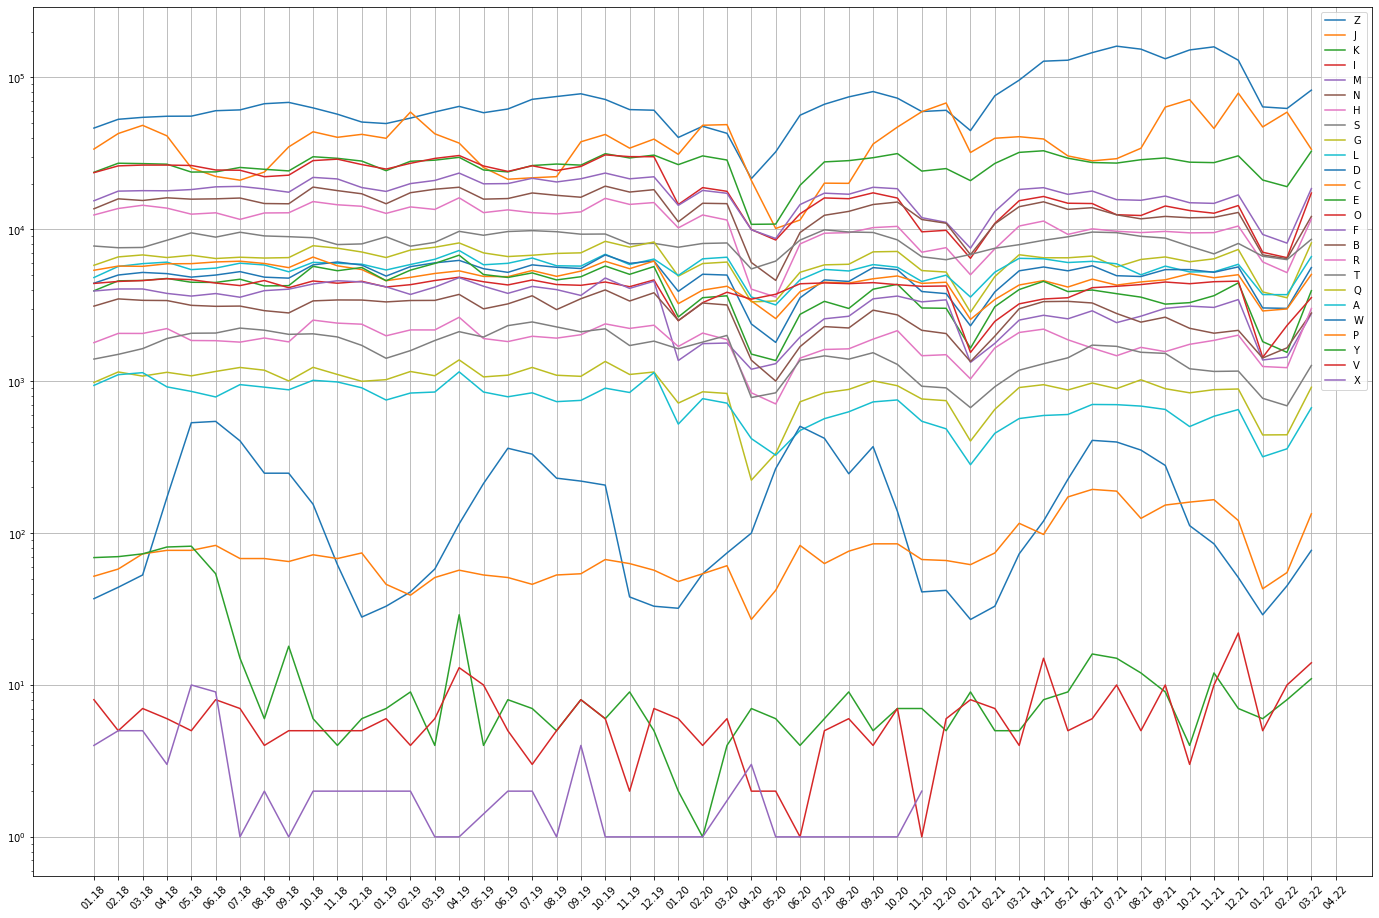

In [53]:
fig, ax = plt.subplots(figsize = (24, 16))

for mkb in all_mkb:
    plt.plot(df[df['litera_mkb_code'] == mkb].groupby('time_series').patient_id_count.sum()[:-1], label = mkb)

plt.xticks(df.groupby('time_series').patient_id_count.sum().index, df['visit_month_year'].unique(), rotation=45)
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

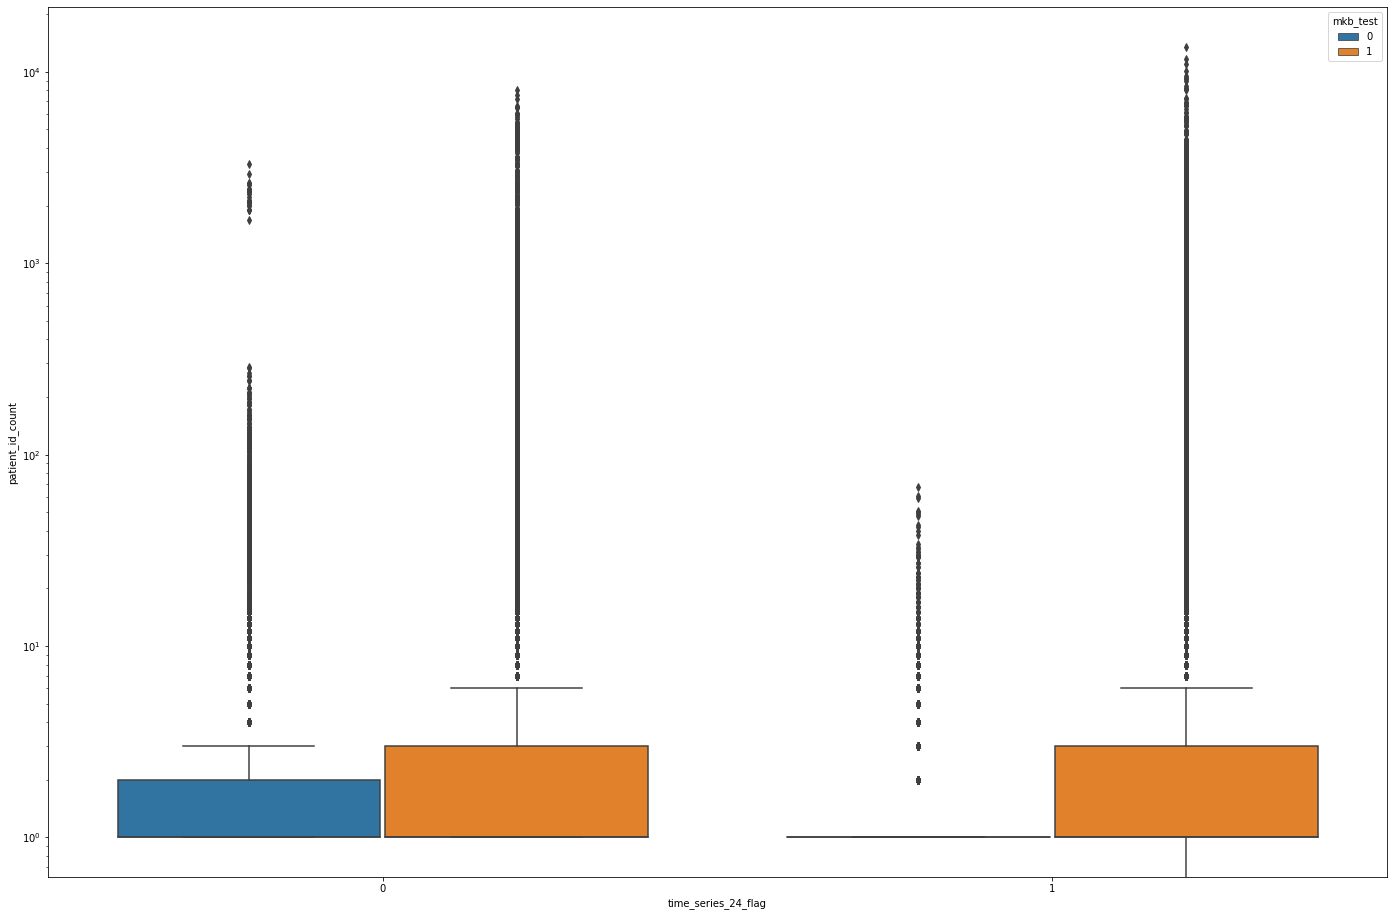

In [56]:
test_mkb = df[df['test'] > -1].mkb_code.unique()
df['mkb_test'] = np.where (df.mkb_code.isin(test_mkb), 1, 0)
fig, ax = plt.subplots(figsize=(24, 16))
sns.boxplot(x="time_series_24_flag", y="patient_id_count", hue = 'mkb_test', data=df)
plt.yscale('log')
plt.show()

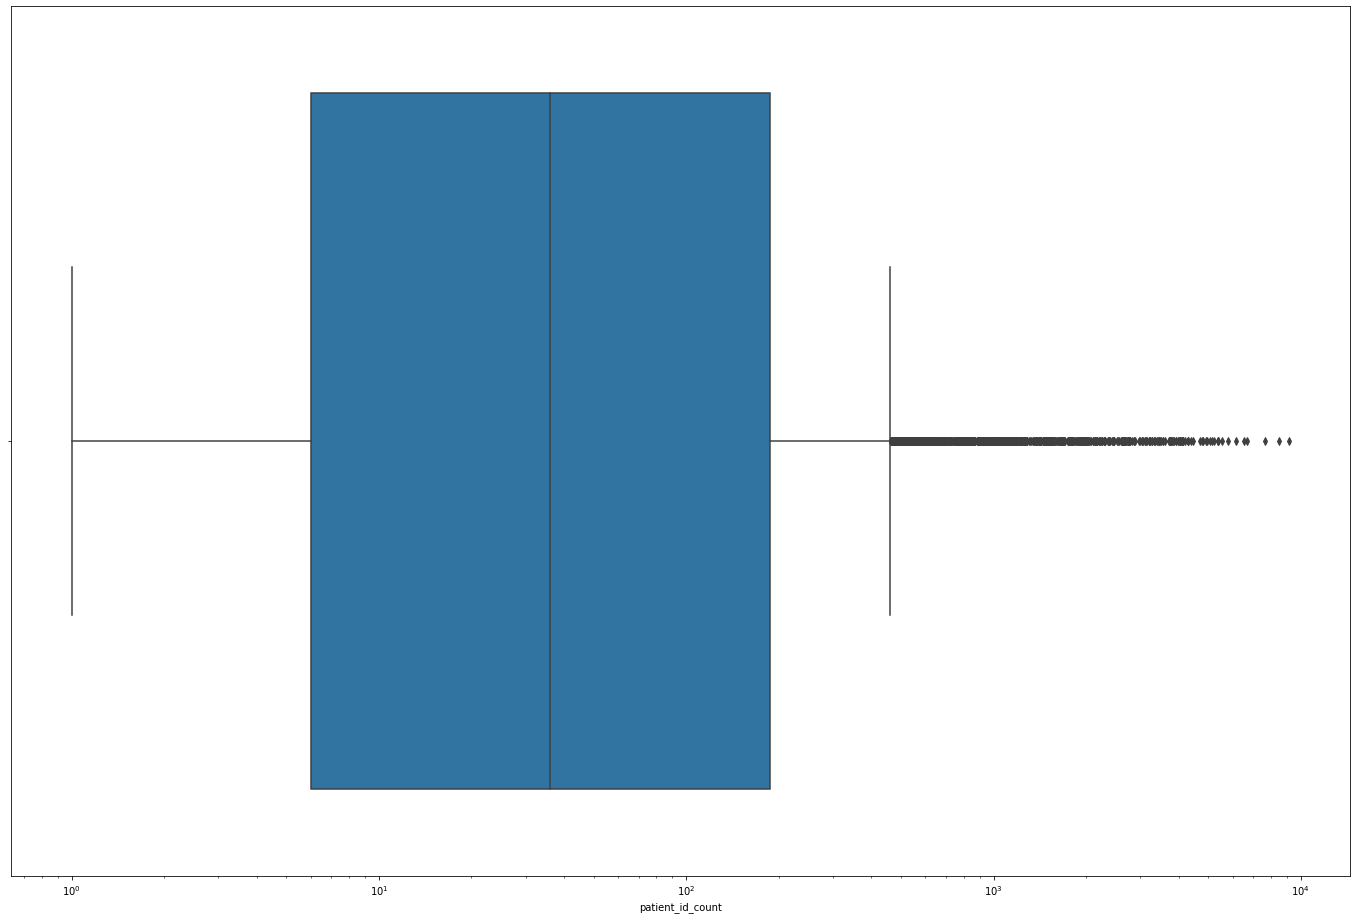

In [58]:
fig, ax = plt.subplots(figsize=(24, 16))
sns.boxplot(df.groupby(['mkb_code']).patient_id_count.count())
plt.xscale('log')
plt.show()

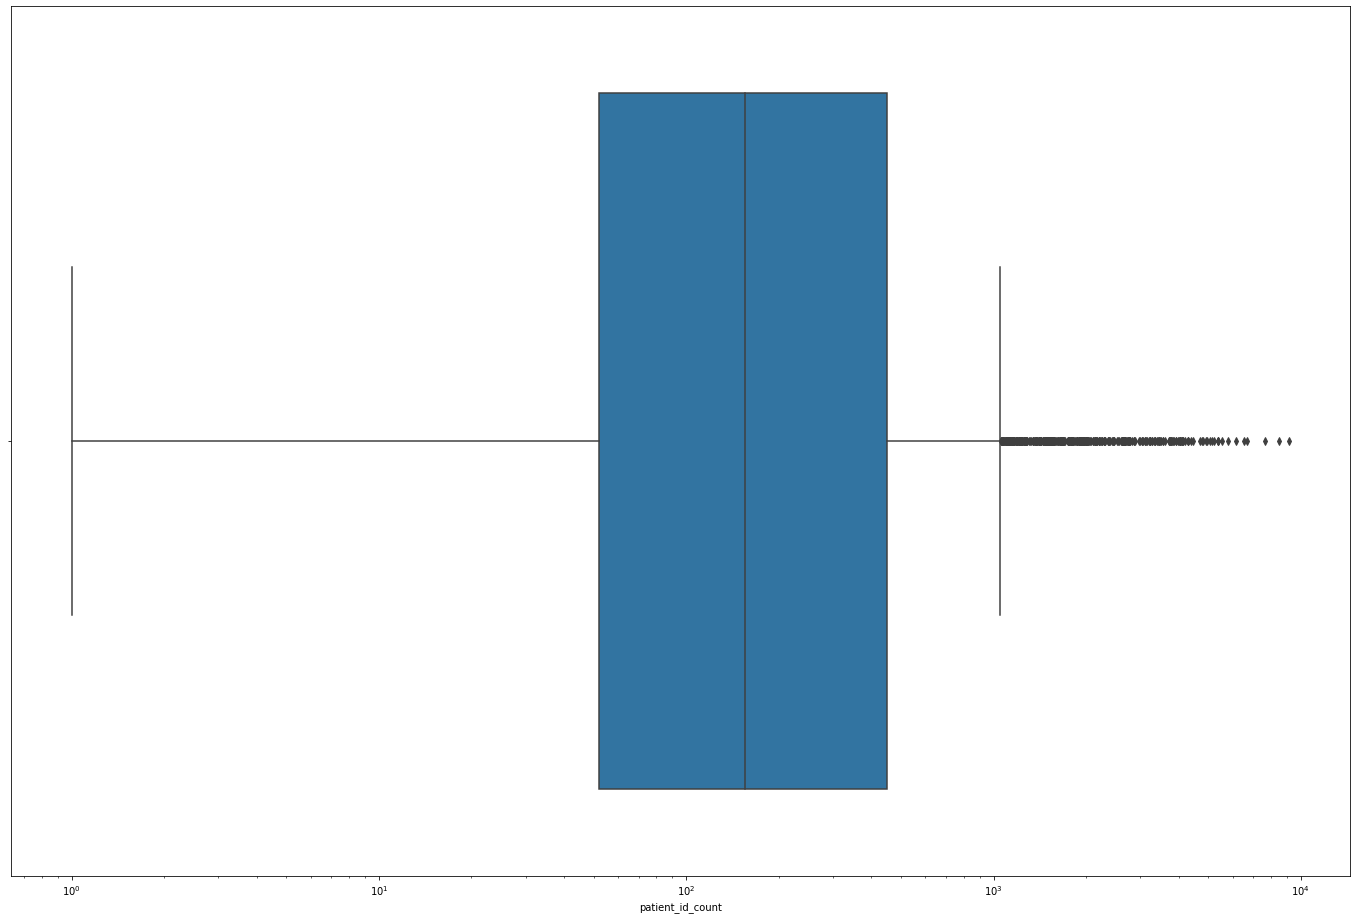

In [59]:
fig, ax = plt.subplots(figsize=(24, 16))
sns.boxplot(df[df.mkb_test == 1].groupby(['mkb_code']).patient_id_count.count())
plt.xscale('log')
plt.show()

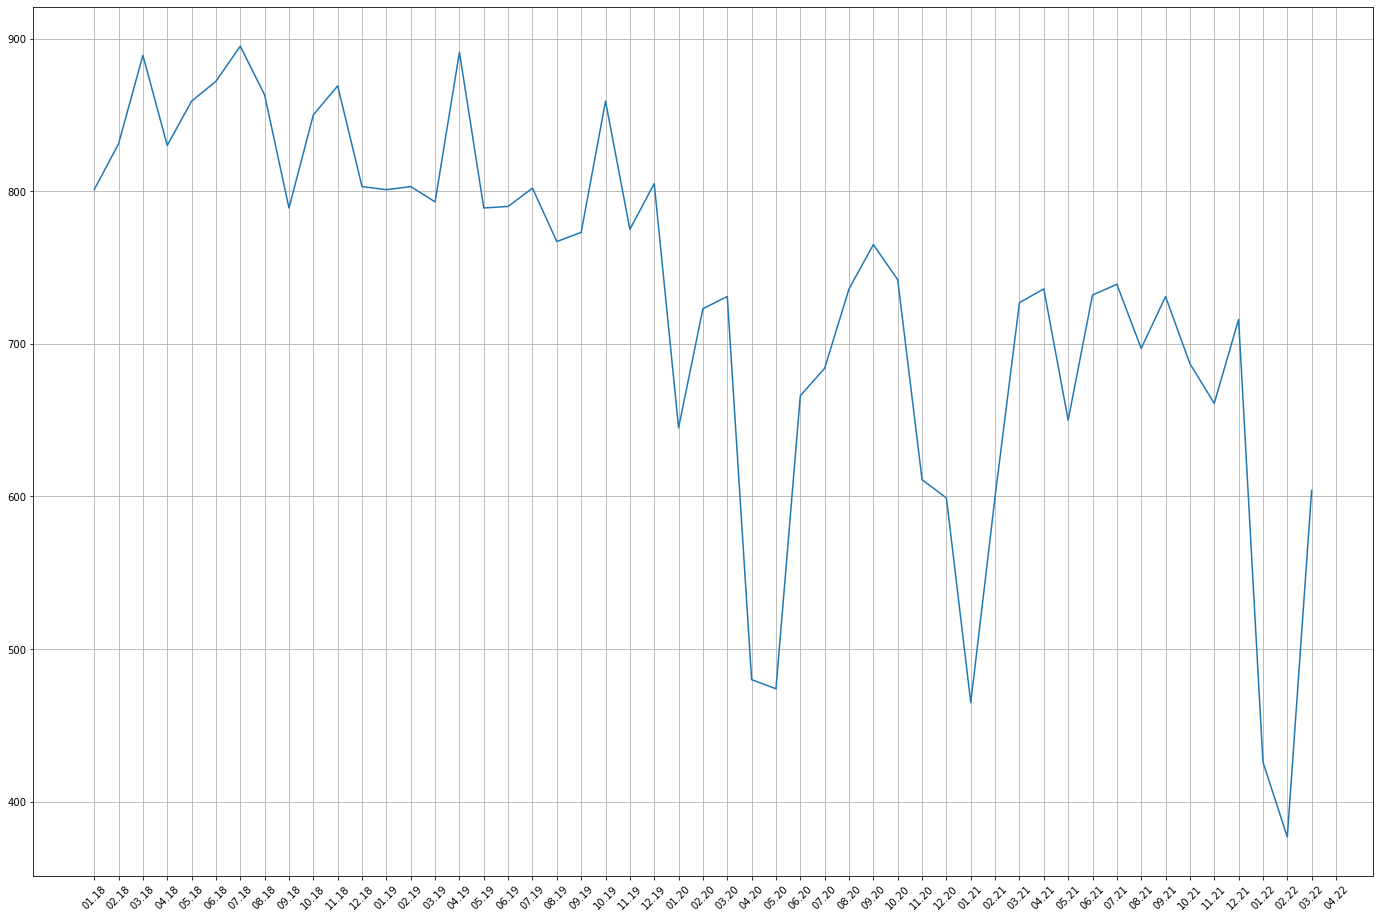

In [ ]:
no_test_mkb = list(set(df['mkb_code'].unique()).difference(set(df.loc[df['mkb_test'] == 1, 'mkb_code'].unique())))
fig, ax = plt.subplots(figsize = (24, 16))
plt.plot(df[df.mkb_code.isin(no_test_mkb)].groupby('time_series')['mkb_code'].nunique())
plt.xticks(np.unique(df['time_series']), df['visit_month_year'].unique(), rotation=45)
# plt.yscale('log')
plt.grid()
plt.show()

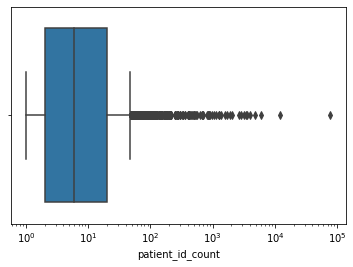

In [60]:
no_test_mkb = list(set(df[df['test'] == -1].mkb_code.unique()).difference(set(df[df['test'] > -1].mkb_code.unique())))
only_test_mkb = list(set(df[df['test'] > -1].mkb_code.unique()).difference(set(df[df['test'] == -1].mkb_code.unique())))
no_test_pacients = df[df.mkb_code.isin(no_test_mkb)].groupby(['mkb_code'], as_index = False).patient_id_count.sum().sort_values(by = 'patient_id_count', ascending = False)
sns.boxplot(no_test_pacients.patient_id_count)
plt.xscale('log')

In [61]:
to_drop_mkb_code = list(no_test_pacients[no_test_pacients.patient_id_count < 600].mkb_code)
df = df[~df.mkb_code.isin(to_drop_mkb_code)].reset_index(drop=True)
df.nunique()

visit_month_year            52
area                        19
age_category                 6
patient_sex                  2
mkb_code                  4138
test                     39354
patient_id_count          1730
time_series                 52
month                       12
year                         5
time_series_24_flag          2
latitude                    19
longitude                   19
popul_cf                    18
popul_log_cf                18
area_nearest                13
distance_nearest            18
litera_mkb_code             24
litera_2nums_mkb_code     1201
not_full_mkb_code            2
mkb_test                     2
dtype: int64

Мы снизили количество уникальных значений кодов с 7644 до 4138 для лучшего предсказания необходимых кодов.

# Пол

In [62]:
df['patient_sex'] = df['patient_sex'].astype(int)

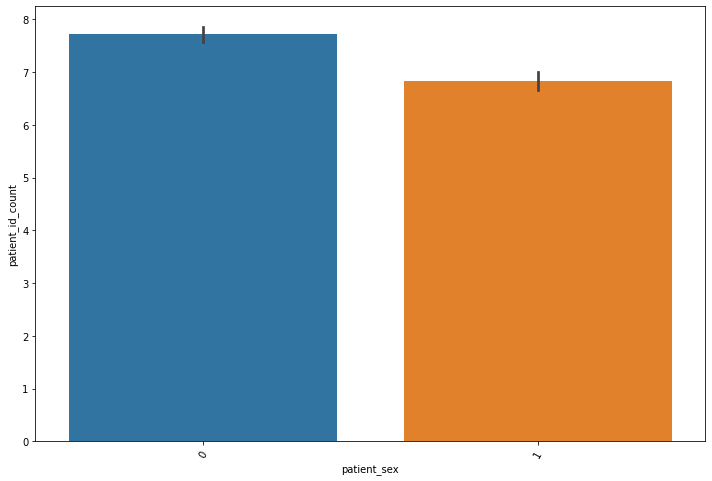

In [63]:
fig, ax = plt.subplots(figsize = (12, 8))
sns.barplot(x = 'patient_sex', y = 'patient_id_count', data = df)
plt.xticks(rotation = 60)
plt.show()

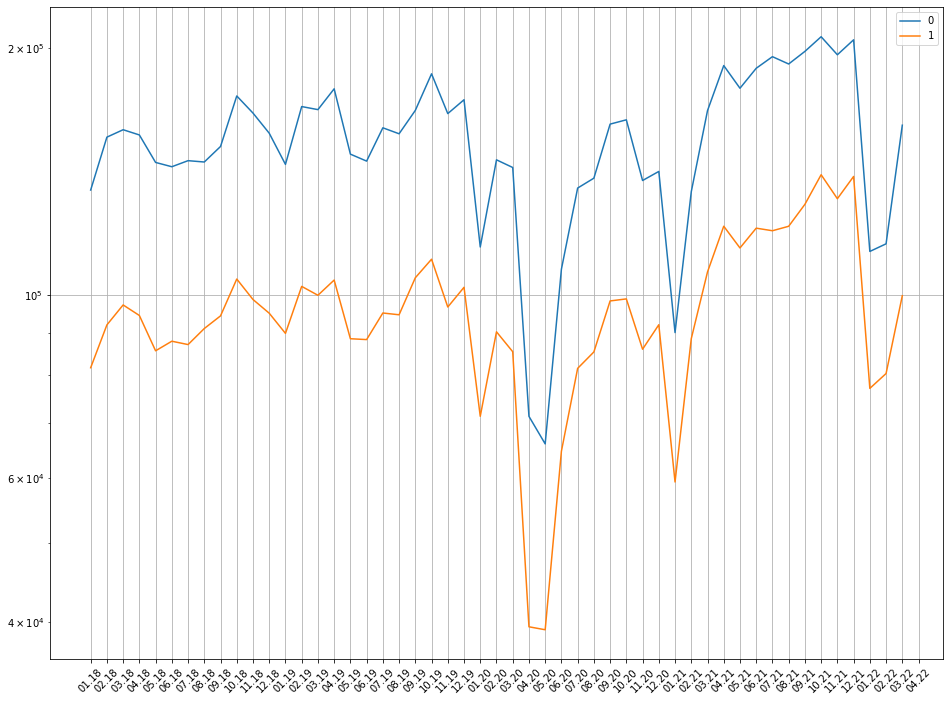

In [64]:
fig, ax = plt.subplots(figsize = (16, 12))

for sex in df.patient_sex.unique():
    plt.plot(df[df['patient_sex'] == sex].groupby('time_series').patient_id_count.sum()[:-1], label = sex)
plt.xticks(df.groupby('time_series').patient_id_count.sum().index, df['visit_month_year'].unique(), rotation=45)
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

# Возраст

Преобразуем возрастные категории. Прибегнем к обогащению данных и открытую информацию из открытого источника Росстат: 
https://rosstat.gov.ru/compendium/document/13282

Я же скачал такую же информацию с сайта портала правительства Калининградской области:
https://gov39.ru/ 

Вручную выделилил нужную информацию из файла 'Оценка численности населения Калининградской области на 01.01.2022' и сохранил в файл 'группы возрастов Калининградская область 2020.xlsx'


In [65]:
age_ord = dict(children = 0, 
young = 1,
middleage = 2,
elderly = 3,
old = 4,
centenarians = 5)

In [66]:
age = dict(children = 0, 
young = 18,
middleage = 45,
elderly = 60,
old = 75,
centenarians = 90)

In [67]:
ages = pd.read_excel('группы возрастов Калининградская область 2020.xlsx')

In [68]:
ages

Unnamed: 0     все  мужчины  женщины
0     "0 - 17"  199534   102599    96935
1    "18 - 44"  383917   198908   185009
2    "45 - 59"  203809    95423   108386
3    "60 - 75"  169548    65344   104204
4    "75 - 90"   51637    13017    38620
5  "90 и выше"    4067      866     3201

In [69]:
age_pop = dict(children = 199534, 
young = 383917,
middleage = 203809,
elderly = 169548,
old = 51637,
centenarians = 4067)

In [70]:
df['sex_popul'] = np.where(df['patient_sex'] == 1, ages['мужчины'].sum(), ages['женщины'].sum())
df['age_ord'] = df['age_category'].map(age_ord)
df['age'] = df['age_category'].map(age)
df['age_pop'] = df['age_category'].map(age_pop)

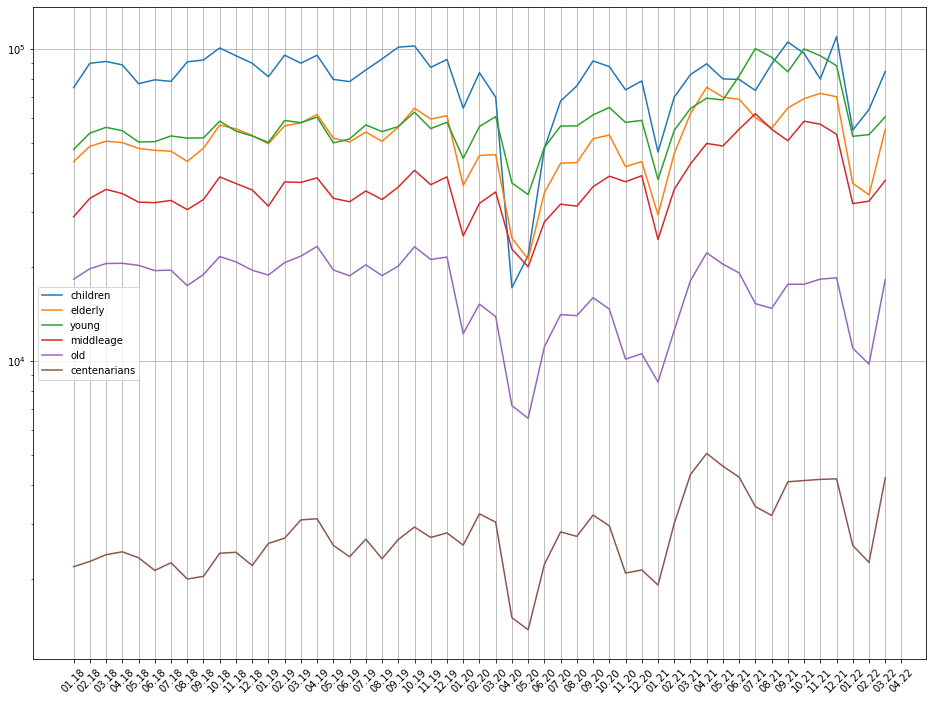

In [71]:
fig, ax = plt.subplots(figsize = (16, 12))

for age in df.age_category.unique():
    plt.plot(df[df['age_category'] == age].groupby('time_series').patient_id_count.sum()[:-1], label = age)
plt.xticks(df.groupby('time_series').patient_id_count.sum().index, df['visit_month_year'].unique(), rotation=45)
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

# Данные по Covid19

Данные взяты с сайта https://cloud.yandex.com/en-ru/services/datalens

## Россия

Добавим информацию по статистике Ковид19 в Калининграде, Москве и России в целом.

In [72]:
covidRus = pd.read_csv('Ковид19_Россия.csv', sep = ';')
covidRus

Дата              Регион  Заражений  Выздоровлений  Смертей  \
0      20.04.2021  Забайкальский край      41970          40480      615   
1      11.08.2022  Ленинградская обл.     195197         187391     3494   
2      20.09.2020        Томская обл.       6775           5554       79   
3      26.09.2020    Костромская обл.       4553           3329       67   
4      02.09.2021   Ямало-Ненецкий АО      47772          45810      625   
...           ...                 ...        ...            ...      ...   
75798  13.10.2020       Брянская обл.      10446           8264       41   
75799  06.05.2021       Амурская обл.      22377          21565      285   
75800  09.02.2021      Алтайский край      40611          36341     1296   
75801  02.08.2022     Северная Осетия      41159          39677     1255   
75802  18.03.2022      Калужская обл.      99385          84968     1388   

       Смертей за день  Заражений за день  Выздоровлений за день  
0                    2                 36                     32  
1                    0                596                    110  
2                    1                 62                     92  
3                    5                 54                     44  
4                    4                102                    121  
...                ...                ...                    ...  
75798                0                 86                     24  
75799                0                 13                     17  
75800               13                174                    170  
75801                0                  2                      3  
75802                1                141                    862  

[75803 rows x 8 columns]

In [73]:
cols = ['Смертей за день','Заражений за день','Выздоровлений за день']
new_cols = ['deaths', 'infect', 'recover']
cols_mapping = dict(zip(cols, new_cols))
covidRus.rename(cols_mapping, axis = 1, inplace= True)
covidRus['infected'] = covidRus['Заражений'] - covidRus['Выздоровлений'] - covidRus['Смертей']

covidRus['visit_month_year'] = covidRus['Дата'].str.strip(' ').str.split('.').apply(lambda x: x[1]) + '.' + covidRus['Дата'].str.strip(' ').str.split('.').apply(lambda x: x[2][-2:])
covidRus['month'] = covidRus['Дата'].str.strip(' ').str.split('.').apply(lambda x: x[1]).astype(int)
covidRus['year'] = covidRus['Дата'].str.strip(' ').str.split('.').apply(lambda x: x[2]).astype(int)
covidRus['time_series'] = covidRus['month'] + (covidRus['year'] - covidRus['year'].min()) * 12 

covidKal = covidRus[covidRus.Регион == 'Калининградская обл.']
covidKal = covidKal.groupby(['time_series', 'year', 'month', 'visit_month_year'], as_index = False).sum()

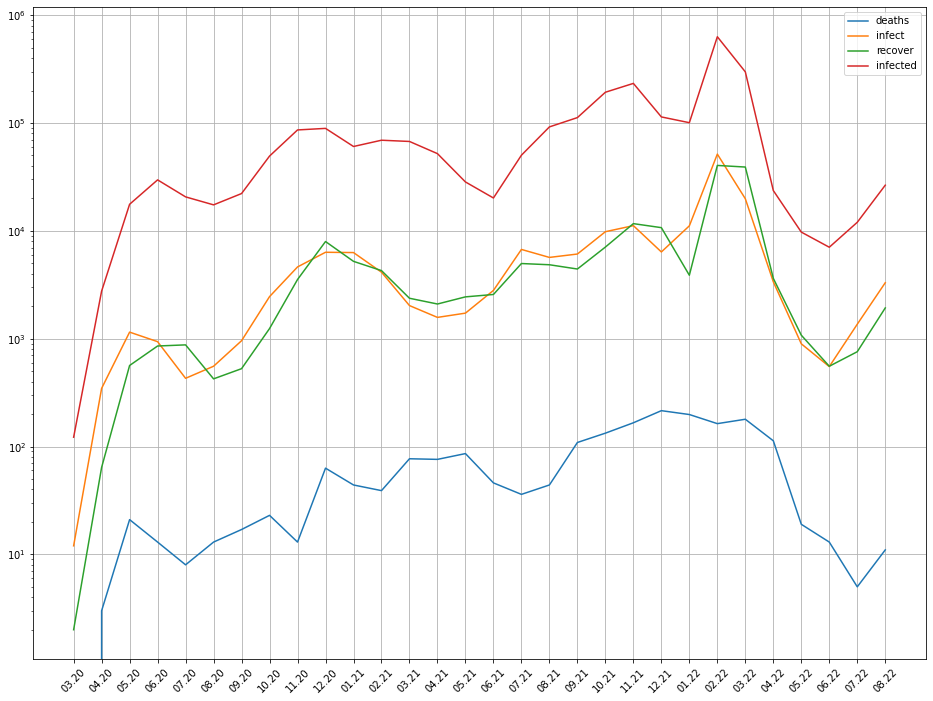

In [74]:
cols = ['deaths', 'infect', 'recover', 'infected']

fig, ax = plt.subplots(figsize = (16, 12))

for col in cols:
    plt.plot(covidKal['time_series'].values, covidKal[col].values, label = col)
plt.xticks(covidKal['time_series'].values, covidKal['visit_month_year'].values, rotation=45)
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

In [75]:
cols = ['deaths', 'infect', 'recover', 'infected']
new_cols = [col + '_Калининград' for col in cols]
cols_mapping = dict(zip(cols, new_cols))
covidKal.rename(cols_mapping, axis = 1, inplace= True)

In [76]:
df = df.merge(right = covidKal[new_cols + ['visit_month_year']], on = ['visit_month_year'], how = 'left').fillna(0)

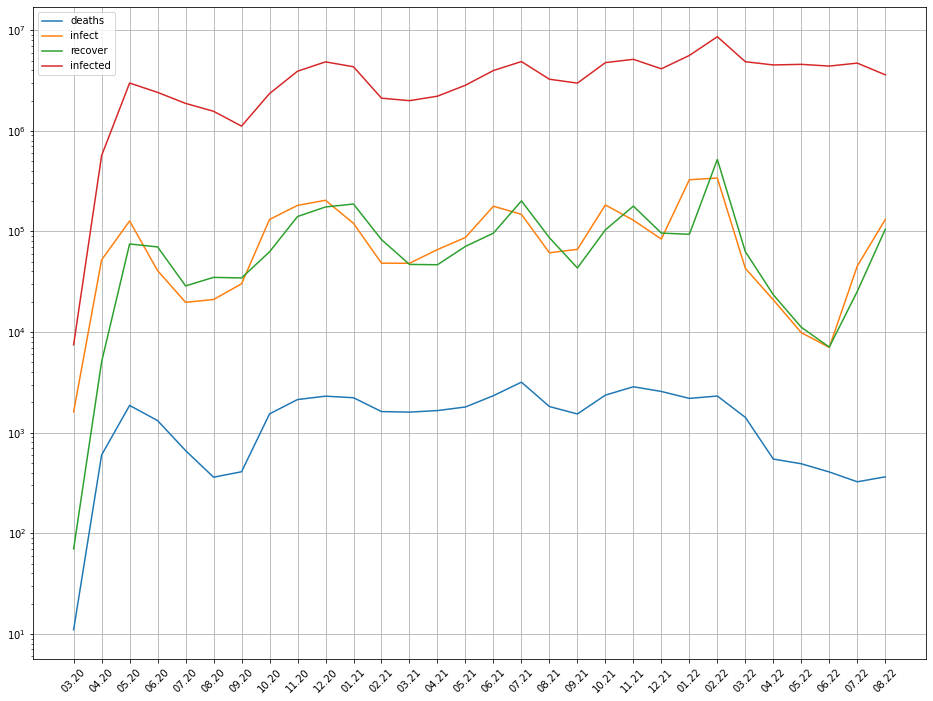

In [77]:
covidMos = covidRus[covidRus.Регион == 'Москва']
covidMos = covidMos.groupby(['time_series', 'year', 'month', 'visit_month_year'], as_index = False).sum()
cols = ['deaths', 'infect', 'recover', 'infected']

fig, ax = plt.subplots(figsize = (16, 12))

for col in cols:
    plt.plot(covidMos['time_series'].values, covidMos[col].values, label = col)
plt.xticks(covidMos['time_series'].values, covidMos['visit_month_year'].values, rotation=45)
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

In [78]:
cols = ['deaths', 'infect', 'recover', 'infected']
new_cols = [col + '_Москва' for col in cols]
cols_mapping = dict(zip(cols, new_cols))
covidMos.rename(cols_mapping, axis = 1, inplace= True)
df = df.merge(right = covidMos[new_cols + ['visit_month_year']], on = ['visit_month_year'], how = 'left').fillna(0)
covidRus = covidRus.groupby(['time_series', 'year', 'month', 'visit_month_year'], as_index = False).sum()

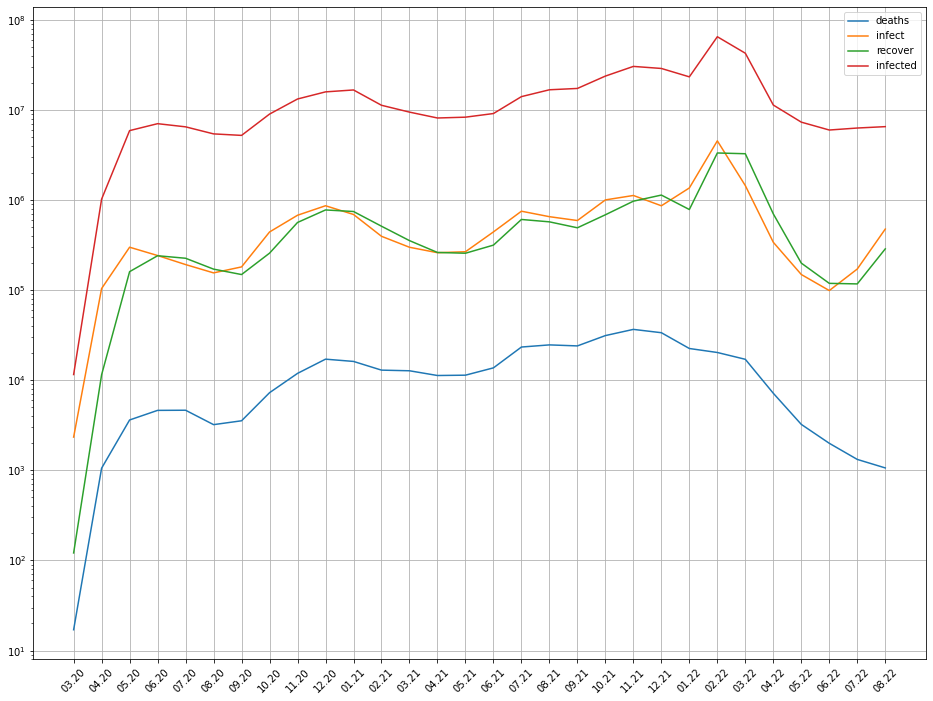

In [79]:
cols = ['deaths', 'infect', 'recover', 'infected']

fig, ax = plt.subplots(figsize = (16, 12))

for col in cols:
    plt.plot(covidRus['time_series'].values, covidRus[col].values, label = col)
plt.xticks(covidRus['time_series'].values, covidRus['visit_month_year'].values, rotation=45)
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

In [80]:
cols = ['deaths', 'infect', 'recover', 'infected']
new_cols = [col + '_Россия' for col in cols]
cols_mapping = dict(zip(cols, new_cols))
covidRus.rename(cols_mapping, axis = 1, inplace= True)
df = df.merge(right = covidRus[new_cols + ['visit_month_year']], on = ['visit_month_year'], how = 'left').fillna(0)

## Мир

Добавим информацию по статистике Ковид19 в других странах. Чтобы не перегружать данные выберем несколько стран. Я выбрал США и Италию.

In [81]:
covid1 = pd.read_csv('Ковид_мир_1.csv', sep = ';')
covid2 = pd.read_csv('Ковид_мир_2.csv', sep = ';')
covid3 = pd.read_csv('Ковид_мир_3.csv', sep = ';')
covidWorld = pd.concat([covid1, covid2, covid3])

In [82]:
cols = ['Смертей за день','Заражений за день','Выздоровлений за день']
new_cols = ['deaths', 'infect', 'recover']
cols_mapping = dict(zip(cols, new_cols))
covidWorld.rename(cols_mapping, axis = 1, inplace= True)
covidWorld['infected'] = covidWorld['Заражений'] - covidWorld['Выздоровлений'] - covidWorld['Смертей']

covidWorld['visit_month_year'] = covidWorld['Дата'].str.strip(' ').str.split('.').apply(lambda x: x[1]) + '.' + covidWorld['Дата'].str.strip(' ').str.split('.').apply(lambda x: x[2][-2:])
covidWorld['month'] = covidWorld['Дата'].str.strip(' ').str.split('.').apply(lambda x: x[1]).astype(int)
covidWorld['year'] = covidWorld['Дата'].str.strip(' ').str.split('.').apply(lambda x: x[2]).astype(int)
covidWorld['time_series'] = covidWorld['month'] + (covidWorld['year'] - covidWorld['year'].min()) * 12 

In [83]:
covidWorld.groupby(['Страна'], as_index = False).sum().sort_values(by = 'infect', ascending = False).head(10)

Страна    Заражений  Выздоровлений    Смертей    infect  \
138             США  32196578604   4.969718e+08  477611365  91893786   
63            Индия  19365209835   4.869317e+09  249034727  44096641   
177         Франция   7872639626   9.670736e+07   78429684  34315770   
29         Бразилия  13410053466   3.419206e+09  337182183  33882685   
48         Германия   5918884241   6.966370e+08   61808789  31006189   
35   Великобритания   6819265254   3.453483e+06   94763105  23733085   
71           Италия   4850802743   7.607179e+08   88327239  21223011   
194     Южная Корея   2595877178   2.826272e+07    4582826  19937093   
135          Россия   6003816812   1.130618e+09  137163237  18387678   
169          Турция   5138928038   9.213738e+08   40670483  15938429   

        recover   deaths      infected  month     year  time_series  
138   6298082.0  1033482  8.566987e+08   5607  1869294        15135  
63   31020855.0   526938  3.300311e+08   5607  1869294        15135  
177    415791.0   153462  1.125672e+09   5607  1869294        15135  
29   17777756.0   679217  3.776105e+08   5607  1869294        15135  
48    3697296.0   144887  5.433406e+07   5607  1869294        15135  
35      24893.0   185418  1.082234e+09   5607  1869294        15135  
71    4161485.0   172780  1.297259e+08   5607  1869294        15135  
194    181344.0    25178  3.205218e+06   5607  1869294        15135  
135   5635427.0   376071  1.473994e+08   5607  1869294        15135  
169   5492295.0    99698  5.509697e+07   5607  1869294        15135

In [84]:
countries = ['США', 'Италия']

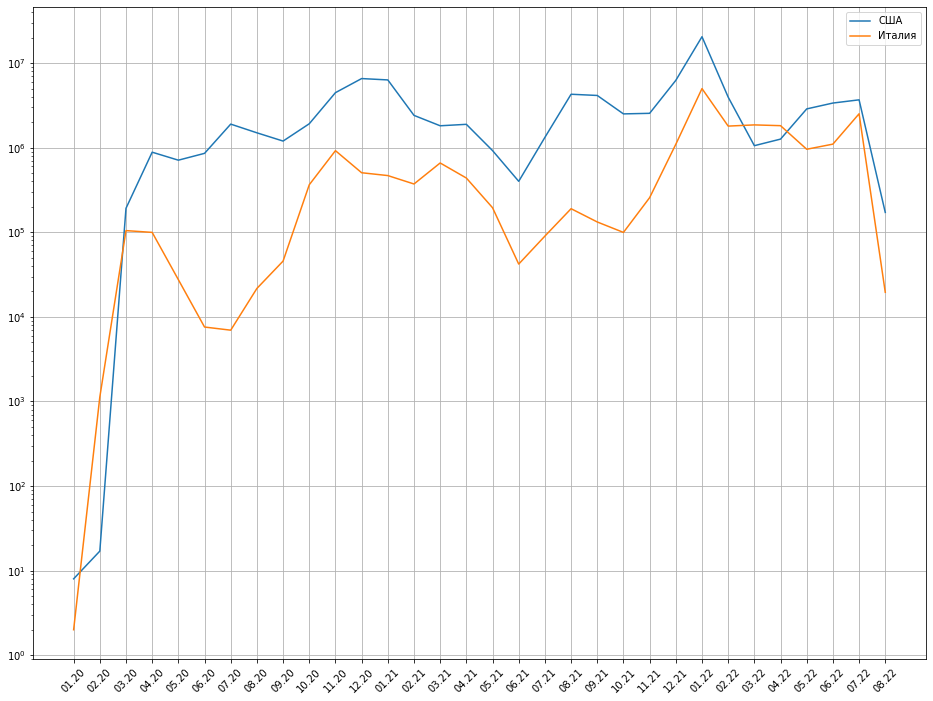

In [85]:
fig, ax = plt.subplots(figsize = (16, 12))

show = covidWorld.groupby(['time_series', 'visit_month_year', 'Страна'], as_index=False)['infect'].sum()

for country in countries:
    
    plt.plot(show[show.Страна == country]['visit_month_year'].values, show[show.Страна == country]['infect'].values, label = country)
plt.xticks(#show['time_series'].values, show['visit_month_year'].values, 
rotation=45)
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

In [86]:
for country in countries:
    covidCountry = covidWorld[covidWorld.Страна == country]
    covidCountry = covidCountry.groupby(['time_series', 'year', 'month', 'visit_month_year'], as_index = False).sum()
    cols = ['deaths', 'infect', #'recover', 'infected'
    ]
    new_cols = [col + '_' + country for col in cols]
    cols_mapping = dict(zip(cols, new_cols))
    covidCountry.rename(cols_mapping, axis = 1, inplace= True)

    df = df.merge(right = covidCountry[new_cols + ['visit_month_year']], on = ['visit_month_year'], how = 'left').fillna(0)

## Маркеры

Добавим самые популярные запросы, связанные с темой коронавируса по Калининградской области.

In [87]:
marks = pd.read_csv('Ковид19_маркеры.csv', sep = ';')
marks

Регион        Дата                          Маркер  \
0      Калининградская область  20.10.2020  что делать если не едет скорая   
1      Калининградская область  24.11.2020             доставка еды на дом   
2      Калининградская область  31.12.2020                      сдать тест   
3      Калининградская область  26.06.2022           симптомы коронавируса   
4      Калининградская область  26.12.2020                    вторая волна   
...                        ...         ...                             ...   
13510  Калининградская область  05.08.2022             доставка еды на дом   
13511  Калининградская область  14.03.2022                        антитела   
13512  Калининградская область  03.07.2021                        антитела   
13513  Калининградская область  23.09.2020                    вторая волна   
13514  Калининградская область  29.06.2022            лечение коронавируса   

       Запросов на млн  
0             1.016540  
1            49.278076  
2           196.189818  
3             6.905592  
4             8.577359  
...                ...  
13510        79.401078  
13511        51.945474  
13512       674.534319  
13513        32.548057  
13514        19.429387  

[13515 rows x 4 columns]

In [88]:
marks['visit_month_year'] = marks['Дата'].str.strip(' ').str.split('.').apply(lambda x: x[1]) + '.' + marks['Дата'].str.strip(' ').str.split('.').apply(lambda x: x[2][-2:])
marks['month'] = marks['Дата'].str.strip(' ').str.split('.').apply(lambda x: x[1]).astype(int)
marks['year'] = marks['Дата'].str.strip(' ').str.split('.').apply(lambda x: x[2]).astype(int)
marks['time_series'] = marks['month'] + (marks['year'] - marks['year'].min()) * 12 
marks = marks.groupby(['Маркер', 'visit_month_year', 'time_series', 'month', 'year'], as_index = False).sum().sort_values(by = 'time_series')

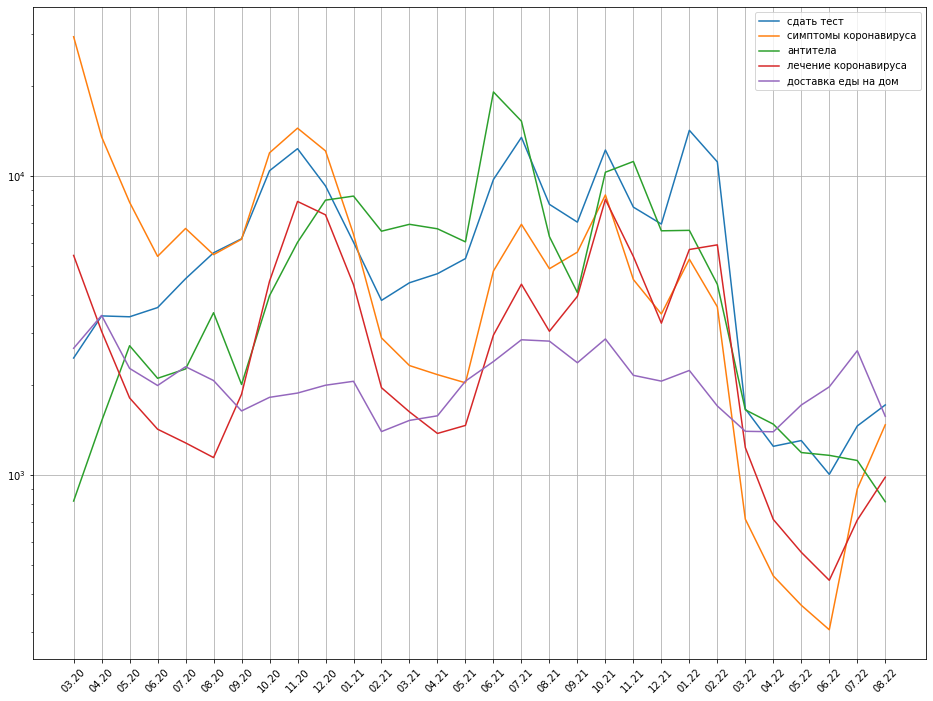

In [89]:
fig, ax = plt.subplots(figsize = (16, 12))

top_marks = marks.groupby('Маркер')['Запросов на млн'].sum().sort_values(ascending = False).index[:5]

show = marks.groupby(['time_series', 'visit_month_year', 'Маркер'], as_index=False)['Запросов на млн'].sum()

for mark in top_marks:
    
    plt.plot(show[show.Маркер == mark]['visit_month_year'].values, show[show.Маркер == mark]['Запросов на млн'].values, label = mark)
plt.xticks(#show['time_series'].values, show['visit_month_year'].values, 
rotation=45)
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

In [90]:
all_marks = marks.Маркер.unique()

for mark in all_marks:
    marks_mark = marks[marks.Маркер == mark]
    marks_mark = marks_mark.groupby(['time_series', 'year', 'month', 'visit_month_year'], as_index = False).sum()
    cols = ['Запросов на млн']
    new_cols = [col + '_' + mark for col in cols]
    cols_mapping = dict(zip(cols, new_cols))
    marks_mark.rename(cols_mapping, axis = 1, inplace= True)

    df = df.merge(right = marks_mark[new_cols + ['visit_month_year']], on = ['visit_month_year'], how = 'left').fillna(0)

# Генерирование признаков

In [91]:
df.columns = df.columns.map(lambda x: x.replace(' ', '_').replace('-', '_').replace('.', ''))

В ходе разных вариантов решения, отборов признаков и экспериментов из признаков по ковиду и маркеров выбраны указанные ниже. Принцип отбора фич приведён ниже в работе.  

['deaths_Россия', 'deaths_Москва', 'deaths_США', 
'Запросов_на_млн_антитела', 'Запросов_на_млн_вызвать_скорую', 'Запросов_на_млн_симптомы_коронавируса',
'Запросов_на_млн_как_не_заразиться', 'Запросов_на_млн_что_делать_дома', 'Запросов_на_млн_купить_маску_и_респиратор']

In [104]:
df = pd.concat([df.iloc[:, :24], df[['deaths_Россия', 'deaths_Москва', 'deaths_США', 
'Запросов_на_млн_антитела', 'Запросов_на_млн_вызвать_скорую', 'Запросов_на_млн_симптомы_коронавируса',
'Запросов_на_млн_как_не_заразиться', 'Запросов_на_млн_что_делать_дома', 'Запросов_на_млн_купить_маску_и_респиратор']]], axis = 1)

In [105]:
cols = ['area','age_category','patient_sex','litera_mkb_code','litera_2nums_mkb_code','mkb_code',]
cols2 = cols.copy()
for feat in cols:
    cols2.remove(feat)
    for feat2 in cols2:
        print (feat, feat2)
        if feat != feat2:
            temp = df.groupby([feat, feat2], as_index= False)['patient_id_count'].count()
            new_col = '_'.join([feat, feat2, 'count'])
            temp = temp.rename(columns = dict(patient_id_count = new_col))
            for lit in temp[feat].unique():
                temp.loc[temp[feat] == lit, new_col + '_norm'] = temp.loc[temp[feat] == lit, new_col] / temp.loc[temp[feat] == lit, new_col].sum()

            df = df.merge(temp, on = [feat, feat2], how = 'left')

            new_col = '_'.join([feat, feat2, 'sum'])
            temp2 = df.groupby([feat, feat2], as_index= False)['patient_id_count'].sum()
            temp2 = temp2.rename(columns = dict(patient_id_count = new_col))
            for lit in temp2[feat].unique():
                temp2.loc[temp2[feat] == lit, new_col + '_norm'] = temp2.loc[temp2[feat] == lit, new_col] / temp2.loc[temp2[feat] == lit, new_col].sum()

            df = df.merge(temp2, on = [feat, feat2], how = 'left')

area age_category
area patient_sex
area litera_mkb_code
area litera_2nums_mkb_code
area mkb_code
age_category patient_sex
age_category litera_mkb_code
age_category litera_2nums_mkb_code
age_category mkb_code
patient_sex litera_mkb_code
patient_sex litera_2nums_mkb_code
patient_sex mkb_code
litera_mkb_code litera_2nums_mkb_code
litera_mkb_code mkb_code
litera_2nums_mkb_code mkb_code


In [106]:
#Временные ряды: общая сумма присвоенных кодов

new_feats = df.groupby(['time_series'], as_index=False).patient_id_count.sum().sort_values(by = 'time_series')

for i in np.unique(new_feats.time_series.astype(int)):
    col = 'patient_id_count'
    temp = new_feats[col]

    new_feats['_'.join(['patient_id_count', 'shift', str(1)])] = temp.shift(1)
    new_feats['_'.join(['patient_id_count', 'growth', str(1)])] = (temp - temp.shift(1)).shift(1)
    # new_feats['_'.join(['patient_id_count', 'growth%', str(1)])] = (temp / temp.shift(1)).shift(1)
    
    for i in [3, 6, 12]:
        new_feats['_'.join(['patient_id_count', 'shift', str(i)])] = temp.shift(i)
        new_feats['_'.join(['patient_id_count', 'mean', str(i)])] = temp.rolling(window = i).mean().shift(1)
        new_feats['_'.join(['patient_id_count', 'growth', str(i)])] = (temp - temp.shift(i)).shift(1)
        # new_feats['_'.join(['patient_id_count', 'growth%', str(i)])] = (temp / temp.shift(i)).shift(1)
        new_feats['_'.join(['patient_id_count', 'min', str(i)])] =  temp.rolling(window = i).min().shift(1)
        new_feats['_'.join(['patient_id_count', 'max', str(i)])] = temp.rolling(window = i).max().shift(1)
        # new_feats['_'.join(['patient_id_count', 'std', str(i)])] = temp.rolling(window = i).std().shift(1)
        # new_feats['_'.join(['patient_id_count', 'ewm_mean', str(i)])] = temp.ewm(span = i).mean().shift(1)

merge_cols = list(new_feats.columns.drop(col))

df = df.merge(new_feats[new_feats.columns.drop(col)], on = ['time_series'], how = 'left')

#Временные ряды: общее количество уникальных комбинаций кодов по группам

new_feats = df.groupby(['time_series'], as_index=False).patient_id_count.count().sort_values(by = 'time_series')

for i in np.unique(new_feats.time_series.astype(int)):
    col = 'patient_id_count'
    temp = new_feats[col]

    new_feats['_'.join(['patient_id_count', 'count_shift', str(0)])] = temp
    new_feats['_'.join(['patient_id_count', 'count_shift', str(1)])] = temp.shift(1)
    new_feats['_'.join(['patient_id_count', 'count_growth', str(1)])] = (temp - temp.shift(1)).shift(1)
    new_feats['_'.join(['patient_id_count', 'count_growth%', str(1)])] = (temp / temp.shift(1)).shift(1)
    
    for i in [3, 6, 12]:
        new_feats['_'.join(['patient_id_count', 'count_shift', str(i)])] = temp.shift(i)
        new_feats['_'.join(['patient_id_count', 'count_mean', str(i)])] = temp.rolling(window = i).mean().shift(1)
        new_feats['_'.join(['patient_id_count', 'count_growth', str(i)])] = (temp - temp.shift(i)).shift(1)
        new_feats['_'.join(['patient_id_count', 'count_growth%', str(i)])] = (temp / temp.shift(i)).shift(1)
        new_feats['_'.join(['patient_id_count', 'count_min', str(i)])] =  temp.rolling(window = i).min().shift(1)
        new_feats['_'.join(['patient_id_count', 'count_max', str(i)])] = temp.rolling(window = i).max().shift(1)
        # new_feats['_'.join(['patient_id_count', 'count_std', str(i)])] = temp.rolling(window = i).std().shift(1)
        # new_feats['_'.join(['patient_id_count', 'count_ewm_mean', str(i)])] = temp.ewm(span = i).mean().shift(1)

merge_cols = list(new_feats.columns.drop(col))

df = df.merge(new_feats[new_feats.columns.drop(col)], on = ['time_series'], how = 'left')

In [ ]:
#Временные ряды: признаки на ковид и маркеры

for feat in ['deaths_Россия', 'deaths_Москва', 'deaths_США', 
'Запросов_на_млн_антитела', 'Запросов_на_млн_вызвать_скорую', 'Запросов_на_млн_симптомы_коронавируса',
'Запросов_на_млн_как_не_заразиться', 'Запросов_на_млн_купить_маску_и_респиратор']:
    
    new_feats = df.groupby(['time_series'], as_index=False)[feat].sum().sort_values(by = 'time_series')

    for i in np.unique(new_feats.time_series.astype(int)):
        col = feat
        temp = new_feats[col]
        new_feats['_'.join([feat, 'shift', str(1)])] = temp.shift(1)
        new_feats['_'.join([feat, 'growth', str(1)])] = (temp - temp.shift(1)).shift(1)
        # new_feats['_'.join([feat, 'growth%', str(1)])] = (temp / temp.shift(1)).shift(1)
        # new_feats['_'.join([feat, 'shift', str(-3)])] = temp.shift(-3)
        # new_feats['_'.join([feat, 'shift', str(-2)])] = temp.shift(-2)
        # new_feats['_'.join([feat, 'shift', str(-1)])] = temp.shift(-1)
        
        for i in [3, 6, 12]:
            new_feats['_'.join([feat, 'shift', str(i)])] = temp.shift(i)
            new_feats['_'.join([feat, 'mean', str(i)])] = temp.rolling(window = i).mean().shift(1)
            new_feats['_'.join([feat, 'growth', str(i)])] = (temp - temp.shift(i)).shift(1)
            # new_feats['_'.join([feat, 'growth%', str(i)])] = (temp / temp.shift(i)).shift(1)
            new_feats['_'.join([feat, 'min', str(i)])] =  temp.rolling(window = i).min().shift(1)
            new_feats['_'.join([feat, 'max', str(i)])] = temp.rolling(window = i).max().shift(1)
            # new_feats['_'.join([feat, 'std', str(i)])] = temp.rolling(window = i).std().shift(1)
            # new_feats['_'.join([feat, 'ewm_mean', str(i)])] = temp.ewm(span = i).mean().shift(1)

    merge_cols = list(new_feats.columns.drop(col))

    df = df.merge(new_feats[new_feats.columns.drop(col)], on = ['time_series'], how = 'left')

In [294]:
df['mkb_code_vc'] = df['mkb_code'].map(df.mkb_code.value_counts())
df['litera_2nums_mkb_code_vc'] = df['litera_2nums_mkb_code'].map(df.litera_2nums_mkb_code.value_counts())
df['litera_mkb_code_vc'] = df['litera_mkb_code'].map(df.litera_mkb_code.value_counts())
df['age_category_vc'] = df['age_category'].map(df.age_category.value_counts())
df['area_vc'] = df['area'].map(df.area.value_counts())

In [3]:
for feat in ['area', 'patient_sex', 'age_category', 'litera_mkb_code']:
    print(feat)
    new_df = df.groupby(['time_series', feat], as_index=False).patient_id_count.sum().sort_values(by = 'time_series')
    cats = new_df[feat].unique()

    n = 0
    for cat in cats:
        
        # print(n)
        
        new_feats = new_df[new_df[feat] == cat][[feat, 'patient_id_count', 'time_series']]

        new_feats.index = new_feats['time_series'].values
        first_index = new_feats.index

        m = 0
        for i in np.unique(new_feats.time_series.astype(int)):

            while i != m:

                new_feats = pd.concat([new_feats, pd.DataFrame(data = np.array([int(m), cat, 0]).reshape(1, 3), columns = ['time_series', feat, 'patient_id_count'], index = [int(m)])])
                new_feats[['time_series', 'patient_id_count']] = new_feats[['time_series', 'patient_id_count']].astype(int)
                m = m + 1
                
            m = m + 1
            new_feats = new_feats.sort_values(by = 'time_series')
            col = 'patient_id_count'
            temp = new_feats[col]
            
            new_feats['_'.join(['patient_id_count', str(feat), 'shift', str(1)])] = temp.shift(1)
            new_feats['_'.join(['patient_id_count', str(feat), 'growth', str(1)])] = (temp - temp.shift(1)).shift(1)
            new_feats['_'.join(['patient_id_count', str(feat), 'growth%', str(1)])] = (temp / temp.shift(1)).shift(1)
            
            for i in [3, 6, 12]:
                new_feats['_'.join(['patient_id_count', str(feat), 'shift', str(i)])] = temp.shift(i)
                new_feats['_'.join(['patient_id_count', str(feat), 'mean', str(i)])] = temp.rolling(window = i).mean().shift(1)
                new_feats['_'.join(['patient_id_count', str(feat), 'growth', str(i)])] = (temp - temp.shift(i)).shift(1)
                new_feats['_'.join(['patient_id_count', str(feat), 'growth%', str(i)])] = (temp / temp.shift(i)).shift(1)
                new_feats['_'.join(['patient_id_count', str(feat), 'min', str(i)])] =  temp.rolling(window = i).min().shift(1)
                new_feats['_'.join(['patient_id_count', str(feat), 'max', str(i)])] = temp.rolling(window = i).max().shift(1)
                # new_feats['_'.join(['patient_id_count', str(feat), 'std', str(i)])] = temp.rolling(window = i).std().shift(1)
                # new_feats['_'.join(['patient_id_count', str(feat), 'ewm_mean', str(i)])] = temp.ewm(span = i).mean().shift(1)
        
        merge_cols = list(new_df.columns.drop(col))
            
        if n == 0:
            new_df = new_df.merge(new_feats.loc[first_index, new_feats.columns.drop(col)], on = ['time_series', feat], how = 'left')
        else:
            new_df.loc[new_df[feat] == cat, new_df.columns.drop(col)] = np.where(
    new_df.loc[new_df[feat] == cat, new_df.columns.drop(col)].isna(), new_feats.loc[first_index, new_feats.columns.drop(col)], new_df.loc[new_df[feat] == cat, new_df.columns.drop(col)])
        
        n += 1

    df = df.merge(new_df[new_df.columns.drop(col)], on = [feat, 'time_series'], how = 'left')

    new_df = df.groupby(['time_series', feat], as_index=False).patient_id_count.count().sort_values(by = 'time_series')
    cats = new_df[feat].unique()

    n = 0
    for cat in cats:
        
        # print(n)

        new_feats = new_df[new_df[feat] == cat][[feat, 'patient_id_count', 'time_series']]

        new_feats.index = new_feats['time_series'].values
        first_index = new_feats.index

        m = 0
        for i in np.unique(new_feats.time_series.astype(int)):

            while i != m:

                new_feats = pd.concat([new_feats, pd.DataFrame(data = np.array([int(m), cat, 0]).reshape(1, 3), columns = ['time_series', feat, 'patient_id_count'], index = [int(m)])])
                new_feats[['time_series', 'patient_id_count']] = new_feats[['time_series', 'patient_id_count']].astype(int)
                m = m + 1
                
            m = m + 1
            new_feats = new_feats.sort_values(by = 'time_series')
            col = 'patient_id_count'
            temp = new_feats[col]

            new_feats['_'.join(['patient_id_count', str(feat), 'count_shift', str(0)])] = temp.shift(0)
            new_feats['_'.join(['patient_id_count', str(feat), 'count_shift', str(1)])] = temp.shift(1)
            new_feats['_'.join(['patient_id_count', str(feat), 'count_growth', str(1)])] = (temp - temp.shift(1)).shift(1)
            # new_feats['_'.join(['patient_id_count', str(feat), 'count_growth%', str(1)])] = (temp / temp.shift(1)).shift(1)
            
            for i in [ 3, 6, 12]:
                new_feats['_'.join(['patient_id_count', str(feat), 'count_shift', str(i)])] = temp.shift(i)
                new_feats['_'.join(['patient_id_count', str(feat), 'count_mean', str(i)])] = temp.rolling(window = i).mean().shift(1)
                new_feats['_'.join(['patient_id_count', str(feat), 'count_growth', str(i)])] = (temp - temp.shift(i)).shift(1)
                # new_feats['_'.join(['patient_id_count', str(feat), 'count_growth%', str(i)])] = (temp / temp.shift(i)).shift(1)
                new_feats['_'.join(['patient_id_count', str(feat), 'count_min', str(i)])] =  temp.rolling(window = i).min().shift(1)
                new_feats['_'.join(['patient_id_count', str(feat), 'count_max', str(i)])] = temp.rolling(window = i).max().shift(1)
                # new_feats['_'.join(['patient_id_count', str(feat), 'count_std', str(i)])] = temp.rolling(window = i).std().shift(1)
                # new_feats['_'.join(['patient_id_count', str(feat), 'count_ewm_mean', str(i)])] = temp.ewm(span = i).mean().shift(1)
        
        merge_cols = list(new_df.columns.drop(col))
            
        if n == 0:
            new_df = new_df.merge(new_feats[new_feats.columns.drop(col)], on = ['time_series', feat], how = 'left')
        else:
            new_df.loc[new_df[feat] == cat, new_df.columns.drop(col)] = np.where(
    new_df.loc[new_df[feat] == cat, new_df.columns.drop(col)].isna(), new_feats.loc[first_index, new_feats.columns.drop(col)], new_df.loc[new_df[feat] == cat, new_df.columns.drop(col)])
        
        n += 1

    df = df.merge(new_df[new_df.columns.drop(col)], on = [feat, 'time_series'], how = 'left')

df

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
0
1
0
1
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


visit_month_year         area age_category  patient_sex mkb_code  \
0                    1.18  Калининград     children            0      A02   
1                    1.18  Калининград     children            0    A02.0   
2                    1.18  Калининград     children            1    A02.0   
3                    1.18  Калининград      elderly            0    A02.0   
4                    1.18  Калининград        young            0    A02.0   
...                   ...          ...          ...          ...      ...   
1731227              4.22     Балтийск      elderly            1    Z96.6   
1731228              4.22        Гусев    middleage            1    Z96.6   
1731229              4.22        Гусев        young            1    Z96.7   
1731230              4.22       Озерск     children            1    Z98.8   
1731231              4.22   Черняховск     children            1    Z98.8   

          test  patient_id_count  time_series  month  year  ...  \
0           -1               1.0            0      1    18  ...   
1           -1               4.0            0      1    18  ...   
2           -1               4.0            0      1    18  ...   
3           -1               1.0            0      1    18  ...   
4           -1               2.0            0      1    18  ...   
...        ...               ...          ...    ...   ...  ...   
1731227  39368               0.0           51      4    22  ...   
1731228  39369               0.0           51      4    22  ...   
1731229  39370               0.0           51      4    22  ...   
1731230  39371               0.0           51      4    22  ...   
1731231  39372               0.0           51      4    22  ...   

         patient_id_count_litera_mkb_code_count_shift_6  \
0                                                   NaN   
1                                                   NaN   
2                                                   NaN   
3                                                   NaN   
4                                                   NaN   
...                                                 ...   
1731227                                          3277.0   
1731228                                          3277.0   
1731229                                          3277.0   
1731230                                          3277.0   
1731231                                          3277.0   

         patient_id_count_litera_mkb_code_count_mean_6  \
0                                                  NaN   
1                                                  NaN   
2                                                  NaN   
3                                                  NaN   
4                                                  NaN   
...                                                ...   
1731227                                    3088.166667   
1731228                                    3088.166667   
1731229                                    3088.166667   
1731230                                    3088.166667   
1731231                                    3088.166667   

         patient_id_count_litera_mkb_code_count_growth_6  \
0                                                    NaN   
1                                                    NaN   
2                                                    NaN   
3                                                    NaN   
4                                                    NaN   
...                                                  ...   
1731227                                             68.0   
1731228                                             68.0   
1731229                                             68.0   
1731230                                             68.0   
1731231                                             68.0   

         patient_id_count_litera_mkb_code_count_min_6  \
0                                                 NaN   
1                                     

In [4]:
df = df[df.time_series > 11]

In [5]:
# df.to_csv('df_general_feats_26.08_2.csv', index = False)

# Отбор признаков по Area (ADRES). Создание мета-фичи: Количество кодов мкб по городам.
Отберём признаки, которые были бы полезны для предсказания заболеваний по городу. А также предскажем количество заболеваний.  
Отбирать будем при помощи LGBM и LGBM с параметром importance_type = 'gain', а также RF и Permutation.
Для этого немного подкрутим параметры, чтобы модель лучше различала важность признаков.  
Чтобы наши модели RF и LGBМ лучше различали признаки сделаем небольшую подкрутку гиперпараметров.  
Таким же способом будем отбирать признаки по Sex и Age и по первой букве кода МКБ-10

In [310]:
cols4 = list(df.loc[:10, 'patient_id_count_area_shift_1':'patient_id_count_area_count_max_12'].columns)
cols3 = list(df.loc[:10, 'deaths_Россия':'Запросов_на_млн_купить_маску_и_респиратор'].columns)
cols2 = list(df.loc[:10, 'patient_id_count_shift_1':'patient_id_count_count_max_12'].columns)
cols = list(df.loc[:10, 'deaths_Россия_shift_1':'Запросов_на_млн_купить_маску_и_респиратор_max_12'].columns)

In [311]:
area_df = df.fillna(0).groupby(['time_series','area','time_series_24_flag', 
'latitude', 'longitude', 'popul_cf', 
'popul_log_cf', 'area_nearest', 'distance_nearest','month', 'year'] + cols + cols2+ cols3 + cols4 + ['area_vc'], as_index = False).patient_id_count.sum()

In [312]:
bt = area_df.sort_values(by = ['time_series'])

In [313]:
bt = pd.get_dummies(data = bt[bt.columns], columns= ['area'])

In [314]:
features = bt.columns.drop(['patient_id_count'])

In [315]:
bt.shape

(760, 250)

In [316]:
scl = StandardScaler()

bt[features] = scl.fit_transform(bt[features])

In [317]:
X_train = bt[area_df.time_series != 51][features].sort_index()
X_pred = bt[area_df.time_series == 51][features].sort_index()

y_train = bt.loc[area_df.time_series != 51, ['patient_id_count']].sort_index()

In [39]:
len(X_pred)

19

In [168]:
random_state = 42
n = 5
cv_splitter = TimeSeriesSplit(n_splits=n, test_size=19)
ps = np.arange(1, 15, 1)
step = 0.2
k = np.array([0.1, 0.15, 0.2, 0.25, 0.3])

# features_reg = features
check_features = features

In [41]:
metric_table = pd.DataFrame()

i = 0
for max_depth in [-1, 8, 6, 4, 3, 2]:
    for min_child_samples in [10, 20, 40]:
        for learning_rate in [0.1, 0.3]:
            # print (i)
            
            cl = LGBMRegressor(
                n_jobs = -1, 
                max_depth = max_depth, 
                min_child_samples = min_child_samples, 
                learning_rate = learning_rate, 
                random_state=random_state)
            
            cv_res = cross_validate(cl, X_train[check_features], y_train, scoring= 'r2', n_jobs = -1, cv = cv_splitter, return_train_score = True, verbose = 0)

            cv_train = (cv_res['train_score'] * k).sum()
            cv_test = (cv_res['test_score'] * k).sum()
            
            
            metric_table.loc[i, 'cv_train'] = cv_train
            metric_table.loc[i, 'cv_test'] = cv_test
            metric_table.loc[i, 'max_depth'] = max_depth
            metric_table.loc[i, 'learning_rate'] = learning_rate
            metric_table.loc[i, 'min_child_samples'] = min_child_samples

            i +=1

            # cl.fit(X_train[check_features], y_train)
            # metric_table.loc[params, 'count_imp=0'] = np.where(cl.feature_importances_ == 1, 1, 0).sum()
            # imp = pd.Series(data = cl.feature_importances_, index = check_features)
            # sns.histplot(imp, bins = 20)
            # plt.show()
                
metric_table['cv_dif'] = metric_table['cv_train'] - metric_table['cv_test']

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35


In [42]:
metric_table.sort_values(by = 'cv_test', ascending= False)

cv_train   cv_test  max_depth  learning_rate  min_child_samples    cv_dif
33  0.998795  0.991395        2.0            0.3               20.0  0.007400
26  0.997074  0.990980        3.0            0.1               20.0  0.006095
27  0.999347  0.990815        3.0            0.3               20.0  0.008532
9   0.999553  0.990582        8.0            0.3               20.0  0.008971
15  0.999492  0.990307        6.0            0.3               20.0  0.009185
20  0.997195  0.989856        4.0            0.1               20.0  0.007339
32  0.996495  0.989544        2.0            0.1               20.0  0.006951
3   0.999566  0.989375       -1.0            0.3               20.0  0.010191
31  0.999832  0.989185        2.0            0.3               10.0  0.010647
21  0.999437  0.989023        4.0            0.3               20.0  0.010414
14  0.997113  0.988815        6.0            0.1               20.0  0.008298
2   0.997131  0.988515       -1.0            0.1               20.0  0.008616
8   0.997138  0.988336        8.0            0.1               20.0  0.008802
30  0.999290  0.985677        2.0            0.1               10.0  0.013614
19  0.999978  0.979557        4.0            0.3               10.0  0.020421
25  0.999949  0.978304        3.0            0.3               10.0  0.021645
18  0.999720  0.976653        4.0            0.1               10.0  0.023067
7   0.999991  0.976585        8.0            0.3               10.0  0.023406
24  0.999647  0.975849        3.0            0.1               10.0  0.023798
1   0.999993  0.975095       -1.0            0.3               10.0  0.024899
13  0.999984  0.975059        6.0            0.3               10.0  0.024925
6   0.999756  0.974502        8.0            0.1               10.0  0.025254
12  0.999738  0.974142        6.0            0.1               10.0  0.025597
0   0.999760  0.972948       -1.0            0.1               10.0  0.026812
29  0.992649  0.935133        3.0            0.3               40.0  0.057516
23  0.993737  0.934243        4.0            0.3               40.0  0.059494
35  0.989377  0.933015        2.0            0.3               40.0  0.056362
4   0.980138  0.925376       -1.0            0.1               40.0  0.054761
10  0.980126  0.924201        8.0            0.1               40.0  0.055925
16  0.979925  0.923836        6.0            0.1               40.0  0.056089
17  0.994225  0.922126        6.0            0.3               40.0  0.072099
34  0.975814  0.920252        2.0            0.1               40.0  0.055562
22  0.979286  0.918703        4.0            0.1               40.0  0.060583
28  0.979515  0.917675        3.0            0.1               40.0  0.061840
11  0.994429  0.916730        8.0            0.3               40.0  0.077699
5   0.994505  0.915500       -1.0            0.3               40.0  0.079005

In [43]:
max_depth = 2
learning_rate = 0.3
min_child_samples = 20
cl = LGBMRegressor(
    n_jobs = -1, 
    max_depth = max_depth, 
    min_child_samples= min_child_samples, 
    learning_rate = learning_rate, 
    random_state=random_state)

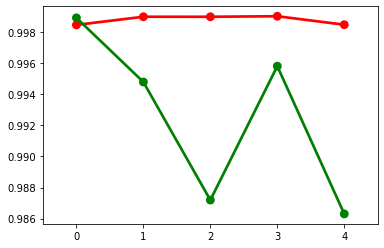

In [44]:
cv_res = cross_validate(cl, X_train[check_features], y_train, scoring= 'r2', n_jobs = -1, cv = cv_splitter, return_train_score = True, verbose = 0)

sns.pointplot(np.arange(n), cv_res['train_score'], color = 'r')
sns.pointplot(np.arange(n), cv_res['test_score'], color = 'g')
plt.show()

In [45]:
cl.fit(X_train[check_features], y_train)
imp = pd.Series(data = cl.feature_importances_, index = check_features)
imp.sort_values(ascending=False).head(10)

patient_id_count_area_count_shift_0      22
patient_id_count_area_shift_12           17
patient_id_count_area_growth_6           16
patient_id_count_area_growth_3           14
patient_id_count_area_growth_12          11
patient_id_count_area_shift_1            10
patient_id_count_area_count_growth_12    10
patient_id_count_area_min_3               9
patient_id_count_area_mean_3              9
patient_id_count_area_count_mean_3        8
dtype: int32

In [46]:
metric_table = pd.DataFrame()

i = 0
for max_depth_rf in [None, 14, 12, 10]:
    for min_samples_leaf in [2]:
        for n_estimators_rf in [100]:
            print (i)
            rf = RandomForestRegressor(
                n_jobs = -1, 
                max_depth = max_depth_rf, 
                min_samples_leaf = min_samples_leaf, 
                n_estimators = n_estimators_rf, 
                random_state=random_state)
            
            cv_res = cross_validate(rf, X_train[check_features], y_train, scoring= 'r2', n_jobs = -1, cv = cv_splitter, return_train_score = True, verbose = 0)
            
            cv_train = (cv_res['train_score'] * k).sum()
            cv_test = (cv_res['test_score'] * k).sum()
            
            
            metric_table.loc[i, 'cv_train'] = cv_train
            metric_table.loc[i, 'cv_test'] = cv_test
            metric_table.loc[i, 'max_depth'] = max_depth_rf
            metric_table.loc[i, 'n_estimators'] = n_estimators_rf
            metric_table.loc[i, 'min_samples_leaf'] = min_samples_leaf

            i +=1

            # cl.fit(X_train[check_features], y_train)
            # metric_table.loc[params, 'count_imp=0'] = np.where(cl.feature_importances_ == 1, 1, 0).sum()
            # imp = pd.Series(data = cl.feature_importances_, index = check_features)
            # sns.histplot(imp, bins = 20)
            # plt.show()
                
metric_table['cv_dif'] = metric_table['cv_train'] - metric_table['cv_test']

0
1
2
3


In [47]:
metric_table.sort_values(by = 'cv_test', ascending= False).head(10)

cv_train   cv_test  max_depth  n_estimators  min_samples_leaf    cv_dif
0  0.997399  0.983252        NaN         100.0               2.0  0.014147
1  0.997384  0.982833       14.0         100.0               2.0  0.014551
3  0.997377  0.982619       10.0         100.0               2.0  0.014758
2  0.997363  0.982207       12.0         100.0               2.0  0.015157

In [169]:
max_depth_rf = None
n_estimators_rf = 100
min_samples_leaf = 2
rf = RandomForestRegressor(
                n_jobs = -1, 
                max_depth = max_depth_rf, 
                min_samples_leaf = min_samples_leaf, 
                n_estimators = n_estimators_rf, 
                random_state=random_state)

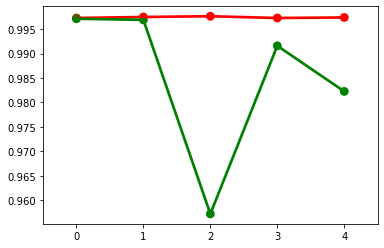

In [49]:
cv_res = cross_validate(rf, X_train[check_features], y_train, scoring= 'r2', n_jobs = -1, cv = cv_splitter, return_train_score = True, verbose = 0)

sns.pointplot(np.arange(n), cv_res['train_score'], color = 'r')
sns.pointplot(np.arange(n), cv_res['test_score'], color = 'g')
plt.show()

In [50]:
rf.fit(X_train[check_features], y_train)
imp = pd.Series(data = rf.feature_importances_, index = check_features)
imp.sort_values(ascending=False).head(10)

patient_id_count_area_count_shift_0     0.662832
patient_id_count_area_shift_1           0.072377
patient_id_count_area_shift_12          0.029758
patient_id_count_area_count_shift_12    0.019917
patient_id_count_area_shift_6           0.019650
patient_id_count_area_count_shift_1     0.019459
patient_id_count_area_count_min_6       0.019271
patient_id_count_area_shift_3           0.019268
patient_id_count_count_shift_0          0.016305
patient_id_count_area_max_3             0.010433
dtype: float64

### LGBM. Последовательный отбор фичей

In [51]:
metric_fs_cons_train_prehype2 = pd.DataFrame()
metric_fs_cons_test_prehype2 = pd.DataFrame()

In [52]:
check_features = features

#### RF

In [53]:
fs_method = 'rf'

rf = RandomForestRegressor(
    n_jobs = -1, 
    random_state = random_state, 
    max_depth=max_depth_rf, 
    n_estimators = n_estimators_rf,
    min_samples_leaf=min_samples_leaf)

temp_features = check_features

for p in ps:

    rf.fit(X_train[temp_features], y_train)

    imp = pd.Series(data = rf.feature_importances_, index = temp_features)

    number_of_feats = len(temp_features)
    h = int(number_of_feats * step)

    temp_features = imp.sort_values().iloc[h:].index
    print (len(temp_features))

    cv_res = cross_validate(cl, X_train[temp_features], y_train, 
    scoring= 'r2', n_jobs = -1, cv = cv_splitter, 
    return_train_score = True, verbose = 0)

    cv_train = (cv_res['train_score'] * k).sum()
    cv_test = (cv_res['test_score'].mean() * k).sum()

    metric_fs_cons_train_prehype2.loc[fs_method, p] = cv_train
    metric_fs_cons_test_prehype2.loc[fs_method, p] = cv_test

rf_feats = temp_features

200
160
128
103
83
67
54
44
36
29
24
20
16
13
11
9


#### LGBM (base)

In [54]:
fs_method = 'lgbm'

temp_features = check_features

for p in ps:

    cl.fit(X_train[temp_features], y_train)

    imp = pd.Series(data = cl.feature_importances_, index = temp_features)

    number_of_feats = len(temp_features)
    h = int(number_of_feats * step)

    temp_features = imp.sort_values().iloc[h:].index
    print (len(temp_features))

    cv_res = cross_validate(cl, X_train[temp_features], y_train, 
    scoring= 'r2', n_jobs = -1, cv = cv_splitter, 
    return_train_score = True, verbose = 0)

    cv_train = (cv_res['train_score'] * k).sum()
    cv_test = (cv_res['test_score'].mean() * k).sum()

    metric_fs_cons_train_prehype2.loc[fs_method, p] = cv_train
    metric_fs_cons_test_prehype2.loc[fs_method, p] = cv_test

lgbm_feats = temp_features

200
160
128
103
83
67
54
44
36
29
24
20
16
13
11
9


#### LGBM (gain)

In [55]:
fs_method = 'lgbm_gain'

lg_gain = LGBMRegressor(
    n_jobs = -1, 
    min_child_samples= min_child_samples, 
    max_depth = max_depth, 
    importance_type = 'gain', 
    random_state=random_state,
    learning_rate=learning_rate)

temp_features = check_features

for p in ps:

    lg_gain.fit(X_train[temp_features], y_train)

    imp = pd.Series(data = lg_gain.feature_importances_, index = temp_features)

    number_of_feats = len(temp_features)
    h = int(number_of_feats * step)

    temp_features = imp.sort_values().iloc[h:].index
    print (len(temp_features))

    cv_res = cross_validate(cl, X_train[temp_features], y_train, 
    scoring= 'r2', n_jobs = -1, cv = cv_splitter, 
    return_train_score = True, verbose = 0)

    cv_train = (cv_res['train_score'] * k).sum()
    cv_test = (cv_res['test_score'].mean() * k).sum()

    metric_fs_cons_train_prehype2.loc[fs_method, p] = cv_train
    metric_fs_cons_test_prehype2.loc[fs_method, p] = cv_test

lgbm_gain_feats = temp_features

200
160
128
103
83
67
54
44
36
29
24
20
16
13
11
9


#### Permutation

In [56]:
fs_method = 'permut'

temp_features = check_features

for p in ps:

    cl.fit(X_train[temp_features], y_train)
    res = permutation_importance(cl, X_train[temp_features], y_train, n_repeats= 5, n_jobs = -1, random_state=random_state)
    imp = pd.Series(data = res.importances_mean, index = temp_features)
    
    number_of_feats = len(temp_features)
    h = int(number_of_feats * step)

    temp_features = imp.sort_values().iloc[h:].index
    print (len(temp_features))

    cv_res = cross_validate(cl, X_train[temp_features], y_train, 
    scoring= 'r2', n_jobs = -1, cv = cv_splitter, 
    return_train_score = True, verbose = 0)

    cv_train = (cv_res['train_score'] * k).sum()
    cv_test = (cv_res['test_score'].mean() * k).sum()

    metric_fs_cons_train_prehype2.loc[fs_method, p] = cv_train
    metric_fs_cons_test_prehype2.loc[fs_method, p] = cv_test

perm_feats = temp_features

200
160
128
103
83
67
54
44
36
29
24
20
16
13
11
9


#### Resume

In [57]:
metric_fs_cons_test_prehype2

1         2         3         4         5         6   \
rf         0.991349  0.990762  0.990573  0.992517  0.991758  0.991515   
lgbm       0.992572  0.991980  0.992272  0.991509  0.990580  0.990669   
lgbm_gain  0.992572  0.991980  0.993049  0.991720  0.990601  0.992073   
permut     0.992572  0.991980  0.992561  0.991947  0.992661  0.992606   

                 7         8         9         10        11        12  \
rf         0.991684  0.986379  0.984418  0.986761  0.984748  0.981772   
lgbm       0.990569  0.990585  0.992175  0.991940  0.988444  0.984477   
lgbm_gain  0.990413  0.991732  0.992039  0.990921  0.989476  0.990123   
permut     0.990413  0.991158  0.992871  0.991597  0.991207  0.990886   

                 13        14        15        16  
rf         0.988768  0.990906  0.987248  0.987835  
lgbm       0.981944  0.994155  0.992836  0.993965  
lgbm_gain  0.991485  0.981750  0.970236  0.972431  
permut     0.986240  0.989446  0.986057  0.986376

In [58]:
metric_fs_cons_dif_prehype2 = metric_fs_cons_train_prehype2 - metric_fs_cons_test_prehype2

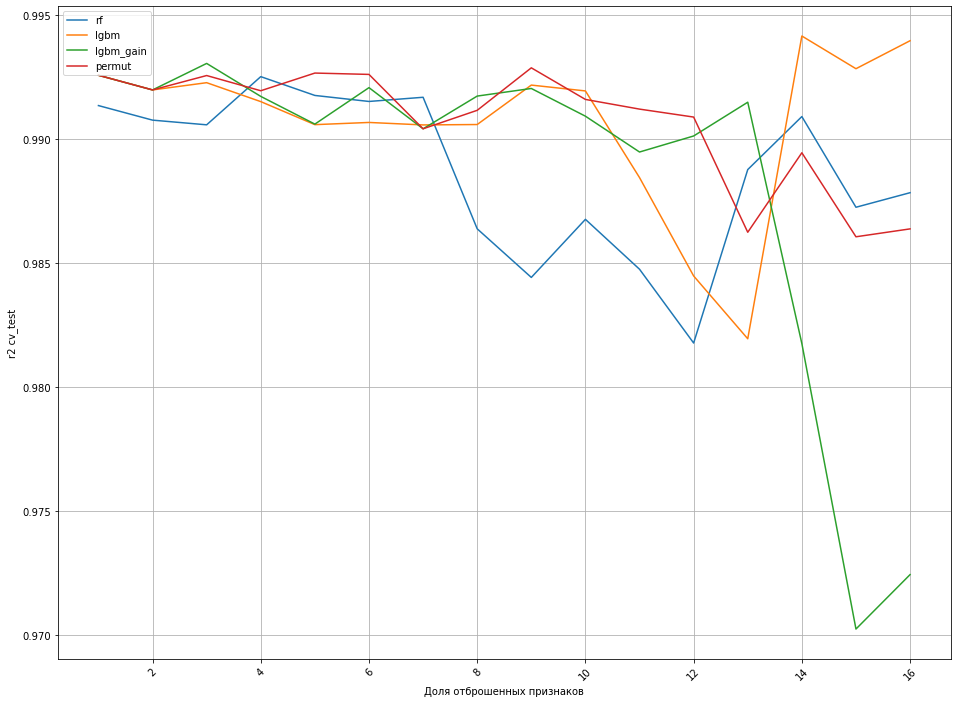

In [59]:
check_index = ['rf', 'lgbm','lgbm_gain','permut']
fig, ax = plt.subplots(figsize=(16, 12))
for i in check_index:
    ax.plot(np.array(metric_fs_cons_test_prehype2.columns), metric_fs_cons_test_prehype2.loc[i, :], label=i)
ax.legend()
ax.set_xlabel('Доля отброшенных признаков')
ax.set_ylabel('r2 cv_test')
ax.grid(True)
plt.xticks(rotation = 45)
plt.show()

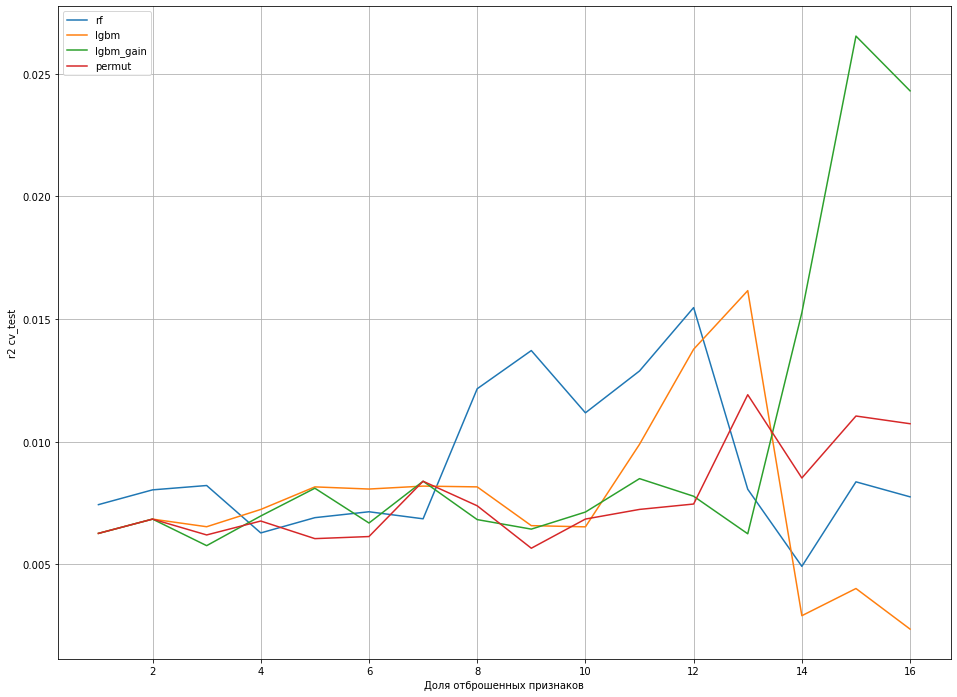

In [60]:
fig, ax = plt.subplots(figsize=(16, 12))
for i in check_index:
    ax.plot(metric_fs_cons_dif_prehype2.columns, metric_fs_cons_dif_prehype2.loc[i, :], label=i)
ax.legend()
ax.set_xlabel('Доля отброшенных признаков')
ax.set_ylabel('r2 cv_test')
ax.grid(True)
plt.show()

#### Докрутка

In [61]:
len(lgbm_feats)

9

In [62]:
check_features = lgbm_feats

In [63]:
metric_table = pd.DataFrame()

i = 0
for max_depth in [-1, 10, 8, 6, 4, 3, 2]:
    for min_child_samples in [2, 6, 10, 20, 40, 80]:
        for learning_rate in [0.05, 0.1 , 0.2, 0.3, 0.4, 0.5]:
            for n_estimators in [100, 200, 400]:
                print (i)
                cl = LGBMRegressor(
                    n_jobs = -1, 
                    max_depth = max_depth, 
                    min_child_samples = min_child_samples, 
                    learning_rate = learning_rate,
                    n_estimators = n_estimators,
                    random_state=random_state)
                
                cv_res = cross_validate(cl, X_train[check_features], y_train, scoring= 'r2', n_jobs = -1, cv = cv_splitter, return_train_score = True, verbose = 0)

                cv_train = (cv_res['train_score'] * k).sum()
                cv_test = (cv_res['test_score'] * k).sum()
                
                
                metric_table.loc[i, 'cv_train'] = cv_train
                metric_table.loc[i, 'cv_test'] = cv_test
                metric_table.loc[i, 'max_depth'] = max_depth
                metric_table.loc[i, 'learning_rate'] = learning_rate
                metric_table.loc[i, 'min_child_samples'] = min_child_samples
                metric_table.loc[i, 'n_estimators'] = n_estimators

                i +=1
                
metric_table['cv_dif'] = metric_table['cv_train'] - metric_table['cv_test']

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [65]:
metric_table.sort_values(by = 'cv_test', ascending= False)

cv_train   cv_test  max_depth  learning_rate  min_child_samples  \
819  0.997288  0.994518        3.0            0.3               20.0   
923  0.997053  0.994093        2.0            0.1               20.0   
814  0.996448  0.994091        3.0            0.1               20.0   
927  0.996328  0.994014        2.0            0.3               20.0   
922  0.995684  0.993938        2.0            0.1               20.0   
..        ...       ...        ...            ...                ...   
107  0.840953  0.430123       -1.0            0.5               80.0   
323  0.840953  0.430123       10.0            0.5               80.0   
215  0.840953  0.430123       11.0            0.5               80.0   
755  0.838275  0.417567        4.0            0.5               80.0   
647  0.840386  0.405986        6.0            0.5               80.0   

     n_estimators    cv_dif  
819         100.0  0.002770  
923         400.0  0.002960  
814         200.0  0.002357  
927         100.0  0.002315  
922         200.0  0.001746  
..            ...       ...  
107         400.0  0.410830  
323         400.0  0.410830  
215         400.0  0.410830  
755         400.0  0.420708  
647         400.0  0.434399  

[972 rows x 7 columns]

In [318]:
max_depth = 3
learning_rate = 0.3
min_child_samples = 20
n_estimators = 100
cl = LGBMRegressor(
    n_jobs = -1, 
    max_depth = max_depth, 
    min_child_samples= min_child_samples, 
    learning_rate = learning_rate, 
    n_estimators = n_estimators,
    random_state=random_state)

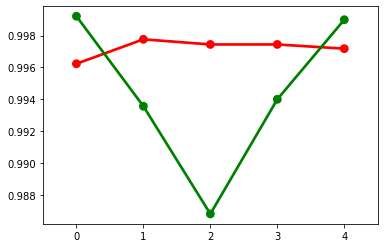

In [67]:
cv_res = cross_validate(cl, X_train[check_features], y_train, scoring= 'r2', n_jobs = -1, cv = cv_splitter, return_train_score = True, verbose = 0)

sns.pointplot(np.arange(n), cv_res['train_score'], color = 'r')
sns.pointplot(np.arange(n), cv_res['test_score'], color = 'g')
plt.show()

In [69]:
cl.fit(X_train[check_features], y_train)
imp = pd.Series(data = cl.feature_importances_, index = check_features)
imp.sort_values(ascending=False).head(10)

patient_id_count_area_growth_3         45
patient_id_count_area_shift_1          44
patient_id_count_area_count_mean_3     41
patient_id_count_area_shift_12         40
patient_id_count_area_count_shift_0    35
patient_id_count_area_growth_12        31
patient_id_count_area_shift_6          28
patient_id_count_count_shift_0         25
patient_id_count_area_min_3            24
dtype: int32

In [71]:
features_lgbm_area = lgbm_feats
features_lgbm_area

Index(['patient_id_count_area_count_shift_0', 'patient_id_count_area_growth_3',
       'patient_id_count_count_shift_0', 'patient_id_count_area_growth_12',
       'patient_id_count_area_shift_1', 'patient_id_count_area_shift_6',
       'patient_id_count_area_count_mean_3', 'patient_id_count_area_min_3',
       'patient_id_count_area_shift_12'],
      dtype='object')

Эти признаки мы оставим для итоговой модели.

#### Предикт

In [319]:
cl.fit(X_train[features_lgbm_area], y_train)
area_counts_predict = cl.predict(X_pred[features_lgbm_area])

In [320]:
area_df['patient_id_count_area_lgbm'] = area_df['patient_id_count']
area_df.loc[area_df.time_series == 51, 'patient_id_count_area_lgbm'] = area_counts_predict

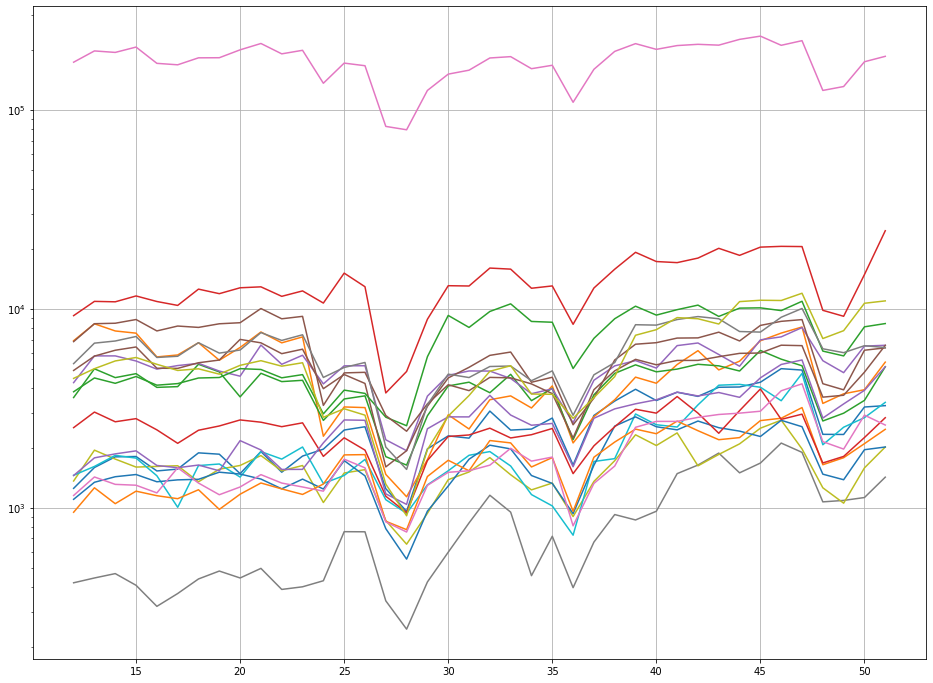

In [321]:
fig, ax = plt.subplots(figsize = (16, 12))

for point in area_df.area.unique():
    plt.plot(area_df[area_df.area == point].time_series, area_df[area_df.area == point].patient_id_count_area_lgbm, label = point)

# plt.xticks(df.groupby('time_series').patient_id_count.sum().index, df['visit_month_year'].unique(), rotation=45)
plt.yscale('log')
# plt.legend()
plt.grid()
plt.show()

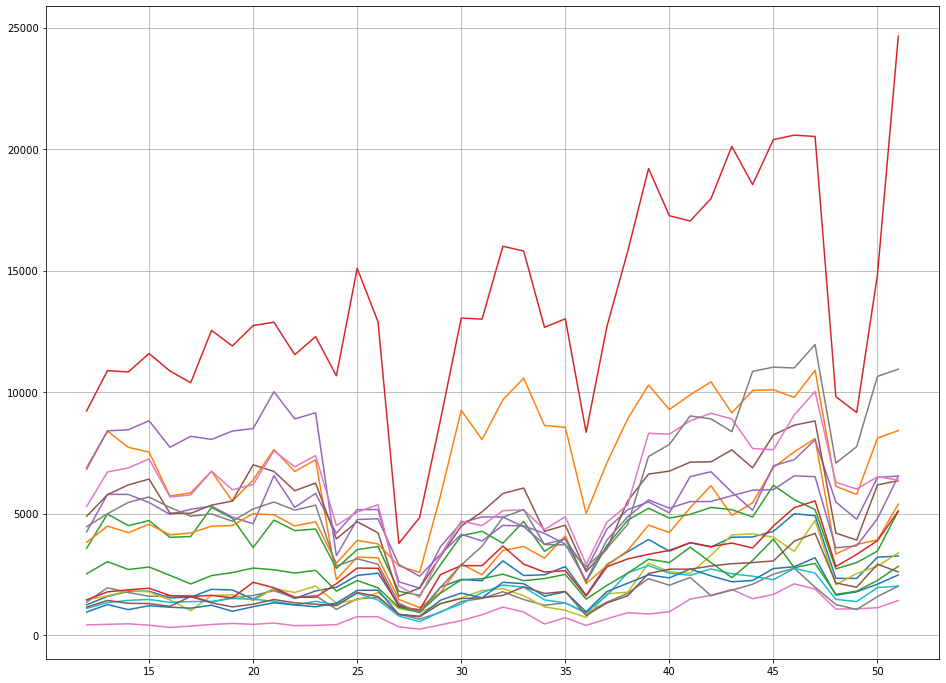

In [75]:
fig, ax = plt.subplots(figsize = (16, 12))

for point in pd.Index(area_df.area.unique()).drop('Калининград'):
    plt.plot(area_df[area_df.area == point].time_series, area_df[area_df.area == point].patient_id_count_area_lgbm, label = point)

# plt.xticks(df.groupby('time_series').patient_id_count.sum().index, df['visit_month_year'].unique(), rotation=45)
# plt.yscale('log')
# plt.legend()
plt.grid()
plt.show()

In [322]:
# area_df = area_df.rename(columns={'patient_id_count':'patient_id_count_area_lgbm'})
df = df.merge(area_df[['time_series', 'area','patient_id_count_area_lgbm']], on = ['time_series', 'area'], how = 'left')

### RF. Последовательный отбор фичей

In [170]:
metric_fs_cons_train_prehype2 = pd.DataFrame()
metric_fs_cons_test_prehype2 = pd.DataFrame()

In [171]:
check_features = features

#### RF

In [172]:
fs_method = 'rf'

temp_features = check_features

for p in ps:

    rf.fit(X_train[temp_features], y_train)

    imp = pd.Series(data = rf.feature_importances_, index = temp_features)

    number_of_feats = len(temp_features)
    h = int(number_of_feats * step)

    temp_features = imp.sort_values().iloc[h:].index
    print (len(temp_features))

    cv_res = cross_validate(rf, X_train[temp_features], y_train, 
    scoring= 'r2', n_jobs = -1, cv = cv_splitter, 
    return_train_score = True, verbose = 0)

    cv_train = (cv_res['train_score'] * k).sum()
    cv_test = (cv_res['test_score'].mean() * k).sum()

    metric_fs_cons_train_prehype2.loc[fs_method, p] = cv_train
    metric_fs_cons_test_prehype2.loc[fs_method, p] = cv_test

rf_feats = temp_features

200
160
128
103
83
67
54
44
36
29
24
20
16
13


#### LGBM (base)

In [173]:
fs_method = 'lgbm'

temp_features = check_features

for p in ps:

    cl.fit(X_train[temp_features], y_train)

    imp = pd.Series(data = cl.feature_importances_, index = temp_features)

    number_of_feats = len(temp_features)
    h = int(number_of_feats * step)

    temp_features = imp.sort_values().iloc[h:].index
    print (len(temp_features))

    cv_res = cross_validate(rf, X_train[temp_features], y_train, 
    scoring= 'r2', n_jobs = -1, cv = cv_splitter, 
    return_train_score = True, verbose = 0)

    cv_train = (cv_res['train_score'] * k).sum()
    cv_test = (cv_res['test_score'].mean() * k).sum()

    metric_fs_cons_train_prehype2.loc[fs_method, p] = cv_train
    metric_fs_cons_test_prehype2.loc[fs_method, p] = cv_test

lgbm_feats = temp_features

200
160
128
103
83
67
54
44
36
29
24
20
16
13


#### LGBM (gain)

In [174]:
fs_method = 'lgbm_gain'

lg_gain = LGBMRegressor(
    n_jobs = -1, 
    min_child_samples= min_child_samples, 
    max_depth = max_depth, 
    importance_type = 'gain', 
    random_state=random_state,
    learning_rate=learning_rate)

temp_features = check_features

for p in ps:

    lg_gain.fit(X_train[temp_features], y_train)

    imp = pd.Series(data = lg_gain.feature_importances_, index = temp_features)

    number_of_feats = len(temp_features)
    h = int(number_of_feats * step)

    temp_features = imp.sort_values().iloc[h:].index
    print (len(temp_features))

    cv_res = cross_validate(rf, X_train[temp_features], y_train, 
    scoring= 'r2', n_jobs = -1, cv = cv_splitter, 
    return_train_score = True, verbose = 0)

    cv_train = (cv_res['train_score'] * k).sum()
    cv_test = (cv_res['test_score'].mean() * k).sum()

    metric_fs_cons_train_prehype2.loc[fs_method, p] = cv_train
    metric_fs_cons_test_prehype2.loc[fs_method, p] = cv_test

lgbm_gain_feats = temp_features

200
160
128
103
83
67
54
44
36
29
24
20
16
13


#### Permutation

In [175]:
fs_method = 'permut'

temp_features = check_features

for p in ps:

    rf.fit(X_train[temp_features], y_train)
    res = permutation_importance(rf, X_train[temp_features], y_train, n_repeats= 5, n_jobs = -1, random_state=random_state)
    imp = pd.Series(data = res.importances_mean, index = temp_features)
    
    number_of_feats = len(temp_features)
    h = int(number_of_feats * step)

    temp_features = imp.sort_values().iloc[h:].index
    print (len(temp_features))

    cv_res = cross_validate(rf, X_train[temp_features], y_train, 
    scoring= 'r2', n_jobs = -1, cv = cv_splitter, 
    return_train_score = True, verbose = 0)

    cv_train = (cv_res['train_score'] * k).sum()
    cv_test = (cv_res['test_score'].mean() * k).sum()

    metric_fs_cons_train_prehype2.loc[fs_method, p] = cv_train
    metric_fs_cons_test_prehype2.loc[fs_method, p] = cv_test

perm_feats = temp_features

200
160
128
103
83
67
54
44
36
29
24
20
16
13


#### Resume

In [176]:
metric_fs_cons_test_prehype2

1         2         3         4         5         6   \
rf         0.813672  0.809397  0.808107  0.807121  0.810968  0.810447   
lgbm       0.824569  0.814018  0.779037  0.778404  0.782508  0.779086   
lgbm_gain  0.821952  0.818690  0.821932  0.819361  0.821324  0.818443   
permut     0.817893  0.813620  0.814880  0.808360  0.801405  0.810106   

                 7         8         9         10        11        12  \
rf         0.827246  0.792184  0.775960  0.769960  0.782709  0.780098   
lgbm       0.780412  0.786216  0.786632  0.779024  0.783042  0.783088   
lgbm_gain  0.824828  0.818837  0.818774  0.783049  0.784447  0.773638   
permut     0.817650  0.817207  0.827782  0.835477  0.809938  0.802971   

                 13        14  
rf         0.778885  0.780975  
lgbm       0.799543  0.811336  
lgbm_gain  0.757104  0.746742  
permut     0.801452  0.781633

In [177]:
metric_fs_cons_dif_prehype2 = metric_fs_cons_train_prehype2 - metric_fs_cons_test_prehype2

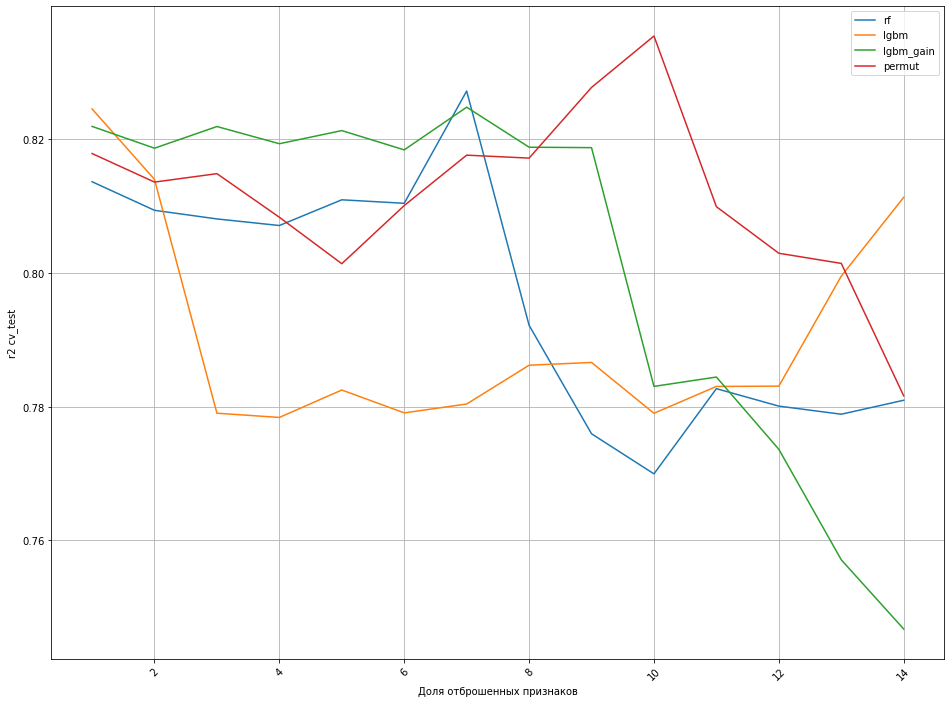

In [178]:
check_index = ['rf', 'lgbm','lgbm_gain','permut']
fig, ax = plt.subplots(figsize=(16, 12))
for i in check_index:
    ax.plot(np.array(metric_fs_cons_test_prehype2.columns), metric_fs_cons_test_prehype2.loc[i, :], label=i)
ax.legend()
ax.set_xlabel('Доля отброшенных признаков')
ax.set_ylabel('r2 cv_test')
ax.grid(True)
plt.xticks(rotation = 45)
plt.show()

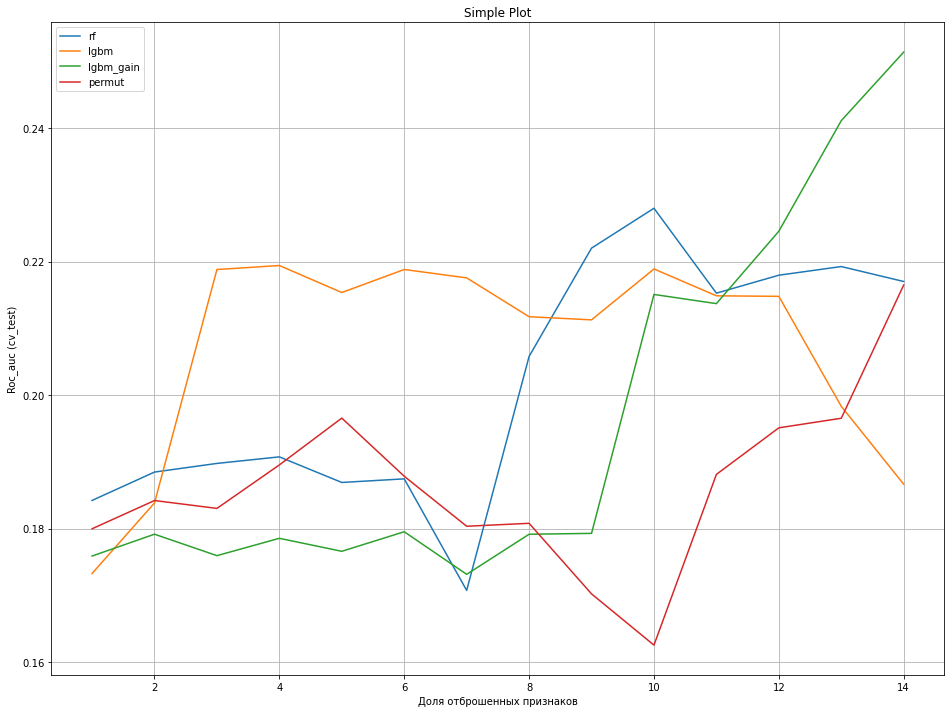

In [179]:
fig, ax = plt.subplots(figsize=(16, 12))
for i in check_index:
    ax.plot(metric_fs_cons_dif_prehype2.columns, metric_fs_cons_dif_prehype2.loc[i, :], label=i)
ax.legend()
plt.title("Simple Plot")
ax.set_xlabel('Доля отброшенных признаков')
ax.set_ylabel('Roc_auc (cv_test)')
ax.grid(True)
plt.show()

#### Докрутка

In [180]:
fs_method = 'permut'

temp_features = check_features

for p in range(1, 11):

    rf.fit(X_train[temp_features], y_train)
    res = permutation_importance(rf, X_train[temp_features], y_train, n_repeats= 5, n_jobs = -1, random_state=random_state)
    imp = pd.Series(data = res.importances_mean, index = temp_features)
    
    number_of_feats = len(temp_features)
    h = int(number_of_feats * step)

    temp_features = imp.sort_values().iloc[h:].index
    print (len(temp_features))

    cv_res = cross_validate(rf, X_train[temp_features], y_train, 
    scoring= 'r2', n_jobs = -1, cv = cv_splitter, 
    return_train_score = True, verbose = 0)

    cv_train = (cv_res['train_score'] * k).sum()
    cv_test = (cv_res['test_score'].mean() * k).sum()

    metric_fs_cons_train_prehype2.loc[fs_method, p] = cv_train
    metric_fs_cons_test_prehype2.loc[fs_method, p] = cv_test

perm_feats = temp_features

200
160
128
103
83
67
54
44
36
29


In [181]:
check_features = perm_feats

In [182]:
metric_table = pd.DataFrame()
i = 0
for max_depth_rf in [None, 13, 12, 11, 10, 9,]:
    for min_samples_leaf in [2, 8]:
            for n_estimators_rf in [100, 200, 400, 700]:

                print (i)

                rf = RandomForestRegressor(
                    n_jobs = -1, 
                    max_depth = max_depth_rf, 
                    min_samples_leaf = min_samples_leaf, 
                    n_estimators = n_estimators_rf,
                    random_state=random_state)
                
                cv_res = cross_validate(rf, X_train[check_features], y_train, scoring= 'r2', n_jobs = -1, cv = cv_splitter, return_train_score = True, verbose = 0)

                cv_train = (cv_res['train_score'].mean() * k).sum()
                cv_test = (cv_res['test_score'].mean() * k).sum()
                
                metric_table.loc[i, 'max_depth'] = max_depth_rf
                metric_table.loc[i, 'min_samples_leaf'] = min_samples_leaf
                metric_table.loc[i, 'n_estimators'] = n_estimators_rf
                
                metric_table.loc[i, 'cv_train'] = cv_train
                metric_table.loc[i, 'cv_test'] = cv_test

                i+=1
                        
metric_table['cv_dif'] = metric_table['cv_train'] - metric_table['cv_test']

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47


In [183]:
metric_table.sort_values(by = 'cv_test', ascending = False)

max_depth  min_samples_leaf  n_estimators  cv_train   cv_test    cv_dif
2         NaN               2.0         400.0  0.998055  0.838224  0.159831
3         NaN               2.0         700.0  0.998083  0.838059  0.160025
19       12.0               2.0         700.0  0.998081  0.837423  0.160659
11       13.0               2.0         700.0  0.998090  0.837331  0.160759
10       13.0               2.0         400.0  0.998054  0.836706  0.161348
1         NaN               2.0         200.0  0.998109  0.835814  0.162295
8        13.0               2.0         100.0  0.998041  0.835761  0.162280
18       12.0               2.0         400.0  0.998054  0.835477  0.162577
0         NaN               2.0         100.0  0.998037  0.835477  0.162560
9        13.0               2.0         200.0  0.998090  0.835416  0.162675
27       11.0               2.0         700.0  0.998064  0.834976  0.163088
26       11.0               2.0         400.0  0.998039  0.834604  0.163434
25       11.0               2.0         200.0  0.998089  0.833056  0.165033
17       12.0               2.0         200.0  0.998104  0.832880  0.165224
24       11.0               2.0         100.0  0.998022  0.831687  0.166336
16       12.0               2.0         100.0  0.998030  0.830955  0.167075
35       10.0               2.0         700.0  0.998029  0.830475  0.167554
34       10.0               2.0         400.0  0.997998  0.829859  0.168139
32       10.0               2.0         100.0  0.997987  0.828527  0.169460
33       10.0               2.0         200.0  0.998044  0.828077  0.169967
43        9.0               2.0         700.0  0.997970  0.822340  0.175630
42        9.0               2.0         400.0  0.997949  0.821936  0.176013
41        9.0               2.0         200.0  0.998008  0.820285  0.177723
40        9.0               2.0         100.0  0.997946  0.818654  0.179292
5         NaN               8.0         200.0  0.992005  0.786537  0.205468
29       11.0               8.0         200.0  0.992013  0.786505  0.205508
13       13.0               8.0         200.0  0.992007  0.786493  0.205514
21       12.0               8.0         200.0  0.992006  0.786046  0.205960
7         NaN               8.0         700.0  0.991998  0.785774  0.206224
31       11.0               8.0         700.0  0.991998  0.785680  0.206318
15       13.0               8.0         700.0  0.991998  0.785564  0.206434
23       12.0               8.0         700.0  0.991995  0.785544  0.206451
39       10.0               8.0         700.0  0.991999  0.784456  0.207543
37       10.0               8.0         200.0  0.992005  0.784338  0.207667
30       11.0               8.0         400.0  0.991962  0.784131  0.207830
6         NaN               8.0         400.0  0.991954  0.783865  0.208090
14       13.0               8.0         400.0  0.991955  0.783845  0.208110
45        9.0               8.0         200.0  0.991986  0.783751  0.208235
22       12.0               8.0         400.0  0.991954  0.783709  0.208245
4         NaN               8.0         100.0  0.991957  0.783599  0.208357
12       13.0               8.0         100.0  0.991955  0.783510  0.208445
47        9.0               8.0         700.0  0.991980  0.783098  0.208882
20       12.0               8.0         100.0  0.991957  0.783093  0.208864
28       11.0               8.0         100.0  0.991967  0.782944  0.209023
38       10.0               8.0         400.0  0.991955  0.782823  0.209132
46        9.0               8.0         400.0  0.991941  0.781459  0.210482
44        9.0               8.0         100.0  0.991935  0.780638  0.211296
36       10.0               8.0         100.0  0.991951  0.780554  0.211396

In [184]:
max_depth_rf = None
min_samples_leaf = 2
n_estimators_rf = 400
rf = RandomForestRegressor(
    n_jobs = -1, 
    max_depth = max_depth_rf, 
    min_samples_leaf = min_samples_leaf, 
    n_estimators = n_estimators_rf,
    random_state=random_state)

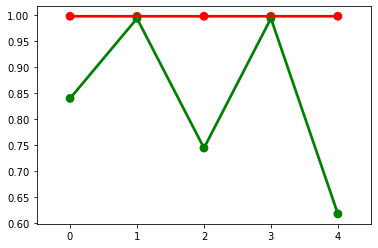

In [185]:
cv_res = cross_validate(rf, X_train[check_features], y_train, scoring= 'r2', n_jobs = -1, cv = cv_splitter, return_train_score = True, verbose = 0)

sns.pointplot(np.arange(n), cv_res['train_score'], color = 'r')
sns.pointplot(np.arange(n), cv_res['test_score'], color = 'g')
plt.show()

In [186]:
rf.fit(X_train[check_features], y_train)
imp = pd.Series(data = rf.feature_importances_, index = check_features)
imp.sort_values(ascending=False).head(10)

area_Калининград                              0.237258
popul_cf                                      0.233249
popul_log_cf                                  0.226893
area_vc                                       0.201159
patient_id_count_patient_sex_count_shift_0    0.084608
patient_id_count_patient_sex_growth%_12       0.001954
patient_id_count_patient_sex_count_shift_1    0.001833
patient_id_count_count_shift_0                0.001337
area_Гурьевск                                 0.001331
patient_id_count_patient_sex_shift_1          0.001324
dtype: float64

In [188]:
features_rf_area = perm_feats
features_rf_area

Index(['Запросов_на_млн_вызвать_скорую_shift_1',
       'patient_id_count_patient_sex_min_3',
       'Запросов_на_млн_купить_маску_и_респиратор_growth_1', 'time_series',
       'patient_id_count_patient_sex_shift_6', 'patient_id_count_shift_1',
       'Запросов_на_млн_вызвать_скорую_growth_12',
       'patient_id_count_patient_sex_count_shift_6',
       'patient_id_count_patient_sex_mean_3',
       'Запросов_на_млн_купить_маску_и_респиратор_shift_12',
       'Запросов_на_млн_симптомы_коронавируса_shift_12',
       'Запросов_на_млн_как_не_заразиться_mean_3',
       'patient_id_count_patient_sex_count_shift_1',
       'patient_id_count_shift_12', 'patient_id_count_growth_12',
       'patient_id_count_patient_sex_growth_12',
       'patient_id_count_patient_sex_shift_12', 'patient_id_count_growth_6',
       'patient_id_count_shift_6', 'patient_id_count_count_mean_12',
       'patient_id_count_patient_sex_shift_1',
       'patient_id_count_count_shift_0', 'area_Гурьевск',
       'patient_i

Эти признаки мы оставим для итоговой модели.

# Отбор признаков по Sex и Age. Создание мета-фичи: Количество кодов мкб по полу и возрасту
Отберём признаки, которые были бы полезны для предсказания заболеваний по городу. А также предскажем количество заболеваний.

In [324]:
cols5 = list(df.loc[:10, 'patient_id_count_age_category_shift_1':'patient_id_count_age_category_count_max_12'].columns)
cols4 = list(df.loc[:10, 'patient_id_count_patient_sex_shift_1':'patient_id_count_patient_sex_count_max_12'].columns)

cols3 = list(df.loc[:10, 'patient_id_count_shift_1':'patient_id_count_count_max_12'].columns)
cols2 = list(df.loc[:10, 'deaths_Россия':'Запросов_на_млн_купить_маску_и_респиратор'].columns)
cols = list(df.loc[:10, 'deaths_Россия_shift_1':'Запросов_на_млн_купить_маску_и_респиратор_max_12'].columns)

In [325]:
sex_age_df = df.fillna(0).groupby(['time_series','sex_popul','time_series_24_flag', 
'age_ord', 'age_pop', 'age', 'age_category_patient_sex_count', 'age_category_patient_sex_sum',
'patient_sex', 'age_category','month', 'year'] + cols + cols2 + cols3 + cols4 + cols5 + ['age_category_vc'], as_index = False).patient_id_count.sum()

In [326]:
bt = sex_age_df.sort_values(by = ['time_series'])

In [327]:
bt = pd.get_dummies(data = bt[bt.columns], columns= ['age_category'])

In [328]:
features = bt.columns.drop(['patient_id_count'])

In [329]:
bt.shape

(480, 277)

In [330]:
scl = StandardScaler()

bt[features] = scl.fit_transform(bt[features])

In [331]:
X_train = bt[sex_age_df.time_series != 51][features].sort_index()
X_pred = bt[sex_age_df.time_series == 51][features].sort_index()

y_train = bt.loc[sex_age_df.time_series != 51, ['patient_id_count']].sort_index()

In [90]:
len(X_pred)

12

In [332]:
random_state = 42
# cv_splitter = KFold(n_splits=4, shuffle = True, random_state=random_state)
n = 5
cv_splitter = TimeSeriesSplit(n_splits=n, test_size=len(X_pred))
ps = np.arange(1, 17, 1)
step = 0.2
k = np.array([0.1, 0.15, 0.2, 0.25, 0.3])

check_features = features

In [92]:
metric_table = pd.DataFrame()

i = 0
for max_depth in [-1, 8, 6, 4, 3, 2]:
    for min_child_samples in [10, 20, 40, 80]:
        for learning_rate in [0.1, 0.3]:
            # print (i)
            
            cl = LGBMRegressor(
                n_jobs = -1, 
                max_depth = max_depth, 
                min_child_samples = min_child_samples, 
                learning_rate = learning_rate, 
                random_state=random_state)
            
            cv_res = cross_validate(cl, X_train[check_features], y_train, scoring= 'r2', n_jobs = -1, cv = cv_splitter, return_train_score = True, verbose = 0)

            cv_train = (cv_res['train_score'] * k).sum()
            cv_test = (cv_res['test_score'] * k).sum()
            
            
            metric_table.loc[i, 'cv_train'] = cv_train
            metric_table.loc[i, 'cv_test'] = cv_test
            metric_table.loc[i, 'max_depth'] = max_depth
            metric_table.loc[i, 'learning_rate'] = learning_rate
            metric_table.loc[i, 'min_child_samples'] = min_child_samples

            i +=1

            # cl.fit(X_train[check_features], y_train)
            # metric_table.loc[params, 'count_imp=0'] = np.where(cl.feature_importances_ == 1, 1, 0).sum()
            # imp = pd.Series(data = cl.feature_importances_, index = check_features)
            # sns.histplot(imp, bins = 20)
            # plt.show()
                
metric_table['cv_dif'] = metric_table['cv_train'] - metric_table['cv_test']

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47


In [93]:
metric_table.sort_values(by = 'cv_test', ascending= False)

cv_train   cv_test  max_depth  learning_rate  min_child_samples    cv_dif
37  0.996895  0.906857        3.0            0.3               40.0  0.090037
36  0.988783  0.900761        3.0            0.1               40.0  0.088022
28  0.990994  0.891127        4.0            0.1               40.0  0.099867
3   0.999836  0.889211       -1.0            0.3               20.0  0.110625
20  0.991889  0.883292        6.0            0.1               40.0  0.108597
19  0.999677  0.883139        6.0            0.3               20.0  0.116538
4   0.991703  0.883077       -1.0            0.1               40.0  0.108626
12  0.991731  0.882418        8.0            0.1               40.0  0.109313
13  0.998765  0.879051        8.0            0.3               40.0  0.119714
27  0.999393  0.876816        4.0            0.3               20.0  0.122576
17  0.999960  0.875331        6.0            0.3               10.0  0.124629
21  0.998695  0.873305        6.0            0.3               40.0  0.125390
9   0.999976  0.873251        8.0            0.3               10.0  0.126724
29  0.998059  0.873090        4.0            0.3               40.0  0.124969
11  0.999752  0.871260        8.0            0.3               20.0  0.128491
25  0.999815  0.868774        4.0            0.3               10.0  0.131041
47  0.986088  0.867199        2.0            0.3               80.0  0.118889
5   0.998740  0.866847       -1.0            0.3               40.0  0.131893
16  0.999388  0.863847        6.0            0.1               10.0  0.135541
44  0.981405  0.863730        2.0            0.1               40.0  0.117675
1   0.999986  0.859552       -1.0            0.3               10.0  0.140434
8   0.999542  0.857752        8.0            0.1               10.0  0.141791
45  0.992566  0.850362        2.0            0.3               40.0  0.142204
46  0.968784  0.848136        2.0            0.1               80.0  0.120647
0   0.999643  0.844992       -1.0            0.1               10.0  0.154652
43  0.995746  0.844359        2.0            0.3               20.0  0.151387
24  0.998473  0.843446        4.0            0.1               10.0  0.155027
39  0.990665  0.839267        3.0            0.3               80.0  0.151398
34  0.994866  0.838902        3.0            0.1               20.0  0.155964
18  0.997860  0.838760        6.0            0.1               20.0  0.159100
6   0.974665  0.837521       -1.0            0.1               80.0  0.137144
14  0.974665  0.837521        8.0            0.1               80.0  0.137144
30  0.974665  0.837521        4.0            0.1               80.0  0.137144
22  0.974665  0.837521        6.0            0.1               80.0  0.137144
2   0.998199  0.836586       -1.0            0.1               20.0  0.161613
10  0.998035  0.836198        8.0            0.1               20.0  0.161837
26  0.996992  0.833296        4.0            0.1               20.0  0.163696
35  0.998683  0.830199        3.0            0.3               20.0  0.168484
38  0.974318  0.829604        3.0            0.1               80.0  0.144715
32  0.996446  0.815879        3.0            0.1               10.0  0.180567
42  0.987331  0.812325        2.0            0.1               20.0  0.175005
31  0.991132  0.804669        4.0            0.3               80.0  0.186463
15  0.991132  0.804669        8.0            0.3               80.0  0.186463
7   0.991132  0.804669       -1.0            0.3               80.0  0.186463
23  0.991132  0.804669        6.0            0.3               80.0  0.186463
40  0.989909  0.796798        2.0            0.1               10.0  0.193111
33  0.999217  0.790498        3.0            0.3               10.0  0.208719
41  0.997062  0.715456        2.0            0.3               10.0  0.281606

In [94]:
max_depth = 3
learning_rate = 0.3
min_child_samples = 40
cl = LGBMRegressor(
    n_jobs = -1, 
    max_depth = max_depth, 
    min_child_samples= min_child_samples, 
    learning_rate = learning_rate, 
    random_state=random_state)

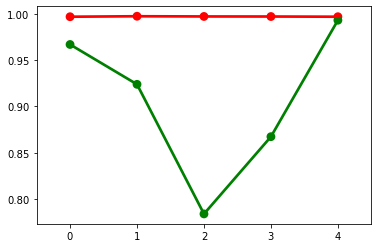

In [95]:
cv_res = cross_validate(cl, X_train[check_features], y_train, scoring= 'r2', n_jobs = -1, cv = cv_splitter, return_train_score = True, verbose = 0)

sns.pointplot(np.arange(n), cv_res['train_score'], color = 'r')
sns.pointplot(np.arange(n), cv_res['test_score'], color = 'g')
plt.show()

In [96]:
cl.fit(X_train[check_features], y_train)
imp = pd.Series(data = cl.feature_importances_, index = check_features)
imp.sort_values(ascending=False).head(10)

patient_id_count_age_category_shift_12          22
age_category_patient_sex_sum                    21
patient_id_count_age_category_shift_1           21
patient_id_count_age_category_count_shift_0     17
patient_id_count_age_category_mean_12           17
patient_id_count_patient_sex_count_shift_0      14
patient_id_count_age_category_count_growth_6    12
patient_id_count_age_category_mean_3            12
patient_id_count_age_category_count_growth_1    11
patient_id_count_age_category_growth_1          11
dtype: int32

In [97]:
metric_table = pd.DataFrame()

i = 0
for max_depth_rf in [None, 14, 12, 10, 8, 6]:
    for min_samples_leaf in [2]:
        for n_estimators_rf in [100]:
            # print (i)
            rf = RandomForestRegressor(
                n_jobs = -1, 
                max_depth = max_depth_rf, 
                min_samples_leaf = min_samples_leaf, 
                n_estimators = n_estimators_rf, 
                random_state=random_state)
            
            cv_res = cross_validate(rf, X_train[check_features], y_train, scoring= 'r2', n_jobs = -1, cv = cv_splitter, return_train_score = True, verbose = 0)
            
            cv_train = (cv_res['train_score'] * k).sum()
            cv_test = (cv_res['test_score'] * k).sum()
            
            
            metric_table.loc[i, 'cv_train'] = cv_train
            metric_table.loc[i, 'cv_test'] = cv_test
            metric_table.loc[i, 'max_depth'] = max_depth_rf
            metric_table.loc[i, 'n_estimators'] = n_estimators_rf
            metric_table.loc[i, 'min_samples_leaf'] = min_samples_leaf

            i +=1

            # cl.fit(X_train[check_features], y_train)
            # metric_table.loc[params, 'count_imp=0'] = np.where(cl.feature_importances_ == 1, 1, 0).sum()
            # imp = pd.Series(data = cl.feature_importances_, index = check_features)
            # sns.histplot(imp, bins = 20)
            # plt.show()
                
metric_table['cv_dif'] = metric_table['cv_train'] - metric_table['cv_test']

0
1
2
3
4
5


In [98]:
metric_table.sort_values(by = 'cv_test', ascending= False).head(10)

cv_train   cv_test  max_depth  n_estimators  min_samples_leaf    cv_dif
2  0.992640  0.783500       12.0         100.0               2.0  0.209140
0  0.992616  0.781694        NaN         100.0               2.0  0.210922
4  0.991565  0.781083        8.0         100.0               2.0  0.210482
3  0.992464  0.780891       10.0         100.0               2.0  0.211573
1  0.992611  0.780107       14.0         100.0               2.0  0.212504
5  0.985567  0.778929        6.0         100.0               2.0  0.206638

In [99]:
max_depth_rf = 12
n_estimators_rf = 100
min_samples_leaf = 2
rf = RandomForestRegressor(
                n_jobs = -1, 
                max_depth = max_depth_rf, 
                min_samples_leaf = min_samples_leaf, 
                n_estimators = n_estimators_rf, 
                random_state=random_state)

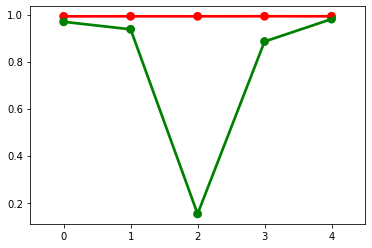

In [100]:
cv_res = cross_validate(rf, X_train[check_features], y_train, scoring= 'r2', n_jobs = -1, cv = cv_splitter, return_train_score = True, verbose = 0)

sns.pointplot(np.arange(n), cv_res['train_score'], color = 'r')
sns.pointplot(np.arange(n), cv_res['test_score'], color = 'g')
plt.show()

In [101]:
rf.fit(X_train[check_features], y_train)
imp = pd.Series(data = rf.feature_importances_, index = check_features)
imp.sort_values(ascending=False).head(10)

age_category_patient_sex_sum                      0.740465
patient_id_count_age_category_shift_1             0.083588
patient_id_count_count_shift_0                    0.045758
age_category_patient_sex_count                    0.042922
patient_id_count_age_category_count_shift_0       0.010955
patient_id_count_age_category_growth_12           0.004308
patient_id_count_age_category_mean_3              0.003805
patient_id_count_age_category_max_3               0.003566
patient_id_count_age_category_shift_12            0.003229
Запросов_на_млн_симптомы_коронавируса_shift_12    0.003138
dtype: float64

### LGBM. Последовательный отбор фичей

In [102]:
metric_fs_cons_train_prehype2 = pd.DataFrame()
metric_fs_cons_test_prehype2 = pd.DataFrame()

In [103]:
check_features = features

#### RF

In [104]:
fs_method = 'rf'

rf = RandomForestRegressor(
    n_jobs = -1, 
    random_state = random_state, 
    max_depth=max_depth_rf, 
    n_estimators = n_estimators_rf,
    min_samples_leaf=min_samples_leaf)

temp_features = check_features

for p in ps:

    rf.fit(X_train[temp_features], y_train)

    imp = pd.Series(data = rf.feature_importances_, index = temp_features)

    number_of_feats = len(temp_features)
    h = int(number_of_feats * step)

    temp_features = imp.sort_values().iloc[h:].index
    print (len(temp_features))

    cv_res = cross_validate(cl, X_train[temp_features], y_train, 
    scoring= 'r2', n_jobs = -1, cv = cv_splitter, 
    return_train_score = True, verbose = 0)

    cv_train = (cv_res['train_score'] * k).sum()
    cv_test = (cv_res['test_score'].mean() * k).sum()

    metric_fs_cons_train_prehype2.loc[fs_method, p] = cv_train
    metric_fs_cons_test_prehype2.loc[fs_method, p] = cv_test

rf_feats = temp_features

221
177
142
114
92
74
60
48
39
32
26
21
17
14
12
10


#### LGBM (base)

In [105]:
fs_method = 'lgbm'

temp_features = check_features

for p in ps:

    cl.fit(X_train[temp_features], y_train)

    imp = pd.Series(data = cl.feature_importances_, index = temp_features)

    number_of_feats = len(temp_features)
    h = int(number_of_feats * step)

    temp_features = imp.sort_values().iloc[h:].index
    print (len(temp_features))

    cv_res = cross_validate(cl, X_train[temp_features], y_train, 
    scoring= 'r2', n_jobs = -1, cv = cv_splitter, 
    return_train_score = True, verbose = 0)

    cv_train = (cv_res['train_score'] * k).sum()
    cv_test = (cv_res['test_score'].mean() * k).sum()

    metric_fs_cons_train_prehype2.loc[fs_method, p] = cv_train
    metric_fs_cons_test_prehype2.loc[fs_method, p] = cv_test

lgbm_feats = temp_features

221
177
142
114
92
74
60
48
39
32
26
21
17
14
12
10


#### LGBM (gain)

In [106]:
fs_method = 'lgbm_gain'

lg_gain = LGBMRegressor(
    n_jobs = -1, 
    min_child_samples= min_child_samples, 
    max_depth = max_depth, 
    importance_type = 'gain', 
    random_state=random_state,
    learning_rate=learning_rate)

temp_features = check_features

for p in ps:

    lg_gain.fit(X_train[temp_features], y_train)

    imp = pd.Series(data = lg_gain.feature_importances_, index = temp_features)

    number_of_feats = len(temp_features)
    h = int(number_of_feats * step)

    temp_features = imp.sort_values().iloc[h:].index
    print (len(temp_features))

    cv_res = cross_validate(cl, X_train[temp_features], y_train, 
    scoring= 'r2', n_jobs = -1, cv = cv_splitter, 
    return_train_score = True, verbose = 0)

    cv_train = (cv_res['train_score'] * k).sum()
    cv_test = (cv_res['test_score'].mean() * k).sum()

    metric_fs_cons_train_prehype2.loc[fs_method, p] = cv_train
    metric_fs_cons_test_prehype2.loc[fs_method, p] = cv_test

lgbm_gain_feats = temp_features

221
177
142
114
92
74
60
48
39
32
26
21
17
14
12
10


#### Permutation

In [107]:
fs_method = 'permut'

temp_features = check_features

for p in ps:

    cl.fit(X_train[temp_features], y_train)
    res = permutation_importance(cl, X_train[temp_features], y_train, n_repeats= 5, n_jobs = -1, random_state=random_state)
    imp = pd.Series(data = res.importances_mean, index = temp_features)
    
    number_of_feats = len(temp_features)
    h = int(number_of_feats * step)

    temp_features = imp.sort_values().iloc[h:].index
    print (len(temp_features))

    cv_res = cross_validate(cl, X_train[temp_features], y_train, 
    scoring= 'r2', n_jobs = -1, cv = cv_splitter, 
    return_train_score = True, verbose = 0)

    cv_train = (cv_res['train_score'] * k).sum()
    cv_test = (cv_res['test_score'].mean() * k).sum()

    metric_fs_cons_train_prehype2.loc[fs_method, p] = cv_train
    metric_fs_cons_test_prehype2.loc[fs_method, p] = cv_test

perm_feats = temp_features

221
177
142
114
92
74
60
48
39
32
26
21
17
14
12
10


#### Resume

In [108]:
metric_fs_cons_test_prehype2

1         2         3         4         5         6   \
rf         0.911632  0.895210  0.915478  0.888985  0.908597  0.924752   
lgbm       0.891668  0.914451  0.916694  0.920118  0.910916  0.933092   
lgbm_gain  0.891668  0.914451  0.915946  0.920773  0.923840  0.925298   
permut     0.891668  0.914451  0.910987  0.917557  0.912264  0.913998   

                 7         8         9         10        11        12  \
rf         0.932678  0.933431  0.926081  0.900073  0.900800  0.899927   
lgbm       0.907581  0.887215  0.897866  0.889732  0.912068  0.859035   
lgbm_gain  0.936695  0.937687  0.936074  0.944232  0.939931  0.935117   
permut     0.917611  0.916073  0.917486  0.917137  0.922551  0.923923   

                 13        14        15        16  
rf         0.924345  0.897699  0.914256  0.912604  
lgbm       0.886863  0.902166  0.891310  0.884372  
lgbm_gain  0.925187  0.902290  0.895444  0.923743  
permut     0.917219  0.918061  0.902443  0.906262

In [109]:
metric_fs_cons_dif_prehype2 = metric_fs_cons_train_prehype2 - metric_fs_cons_test_prehype2

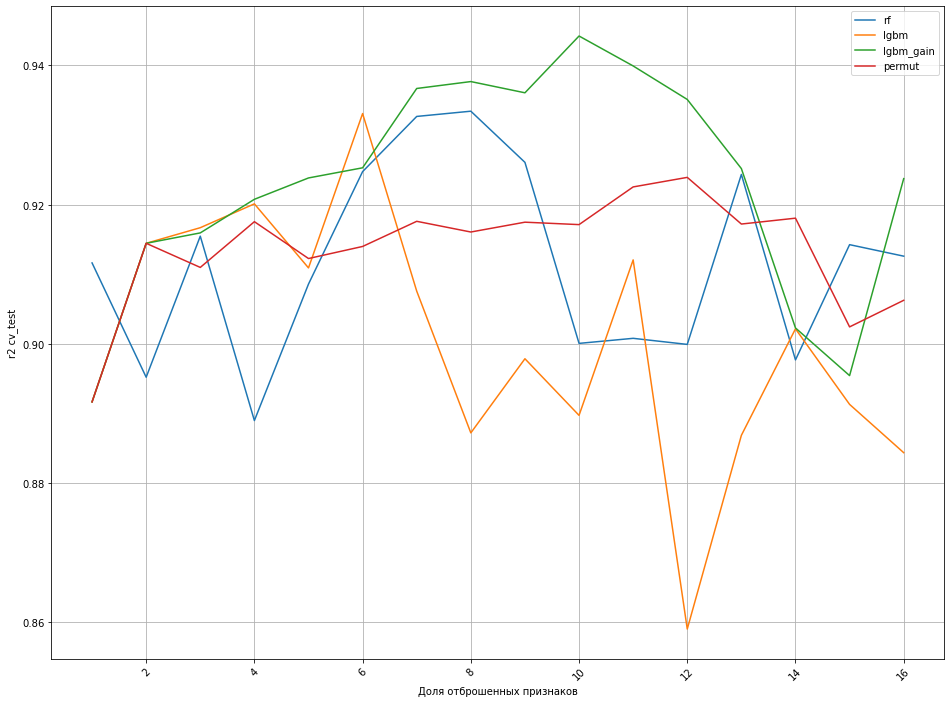

In [110]:
check_index = ['rf', 'lgbm','lgbm_gain','permut']
fig, ax = plt.subplots(figsize=(16, 12))
for i in check_index:
    ax.plot(np.array(metric_fs_cons_test_prehype2.columns), metric_fs_cons_test_prehype2.loc[i, :], label=i)
ax.legend()
ax.set_xlabel('Доля отброшенных признаков')
ax.set_ylabel('r2 cv_test')
ax.grid(True)
plt.xticks(rotation = 45)
plt.show()

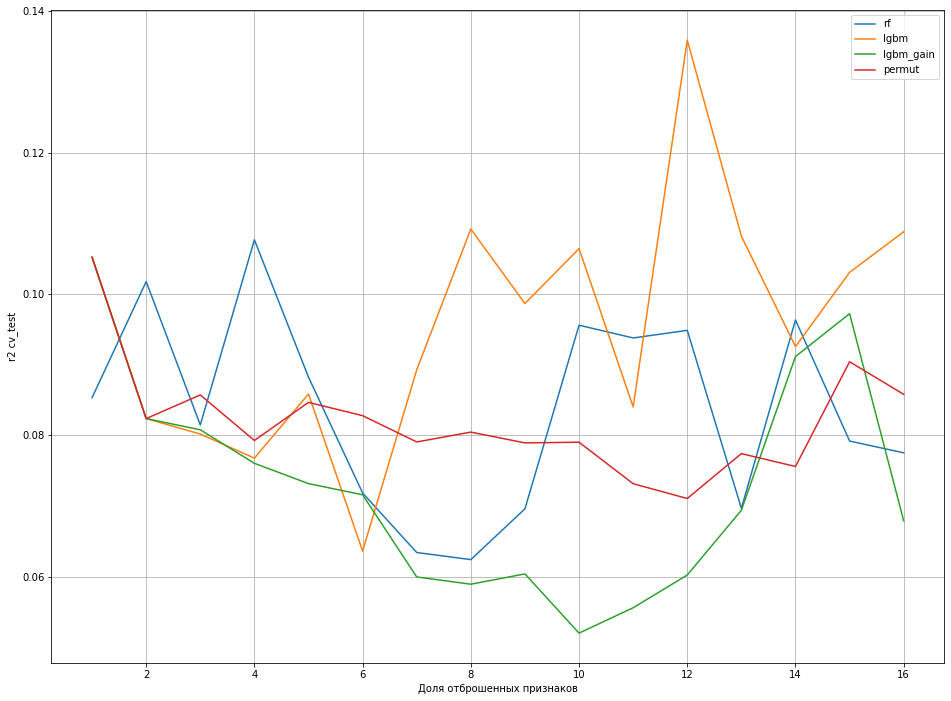

In [111]:
fig, ax = plt.subplots(figsize=(16, 12))
for i in check_index:
    ax.plot(metric_fs_cons_dif_prehype2.columns, metric_fs_cons_dif_prehype2.loc[i, :], label=i)
ax.legend()
ax.set_xlabel('Доля отброшенных признаков')
ax.set_ylabel('r2 cv_test')
ax.grid(True)
plt.show()

#### Докрутка

In [112]:
fs_method = 'lgbm_gain'

lg_gain = LGBMRegressor(
    n_jobs = -1, 
    min_child_samples= min_child_samples, 
    max_depth = max_depth, 
    importance_type = 'gain', 
    random_state=random_state,
    learning_rate=learning_rate)

temp_features = check_features

for p in range(1, 11):

    lg_gain.fit(X_train[temp_features], y_train)

    imp = pd.Series(data = lg_gain.feature_importances_, index = temp_features)

    number_of_feats = len(temp_features)
    h = int(number_of_feats * step)

    temp_features = imp.sort_values().iloc[h:].index
    print (len(temp_features))

    cv_res = cross_validate(cl, X_train[temp_features], y_train, 
    scoring= 'r2', n_jobs = -1, cv = cv_splitter, 
    return_train_score = True, verbose = 0)

    cv_train = (cv_res['train_score'] * k).sum()
    cv_test = (cv_res['test_score'].mean() * k).sum()

    metric_fs_cons_train_prehype2.loc[fs_method, p] = cv_train
    metric_fs_cons_test_prehype2.loc[fs_method, p] = cv_test

lgbm_gain_feats = temp_features

221
177
142
114
92
74
60
48
39
32


In [113]:
check_features = lgbm_gain_feats

In [118]:
metric_table = pd.DataFrame()

i = 0
for max_depth in [8, 7, 6, 5, 4, 3, 2]:
    for min_child_samples in [10, 20, 40, 80]:
        for learning_rate in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]:
            for n_estimators in [100]:
                print (i)
                cl = LGBMRegressor(
                    n_jobs = -1, 
                    max_depth = max_depth, 
                    min_child_samples = min_child_samples, 
                    learning_rate = learning_rate,
                    n_estimators = n_estimators,
                    random_state=random_state)
                
                cv_res = cross_validate(cl, X_train[check_features], y_train, scoring= 'r2', n_jobs = -1, cv = cv_splitter, return_train_score = True, verbose = 0)

                cv_train = (cv_res['train_score'] * k).sum()
                cv_test = (cv_res['test_score'] * k).sum()
                
                
                metric_table.loc[i, 'cv_train'] = cv_train
                metric_table.loc[i, 'cv_test'] = cv_test
                metric_table.loc[i, 'max_depth'] = max_depth
                metric_table.loc[i, 'learning_rate'] = learning_rate
                metric_table.loc[i, 'min_child_samples'] = min_child_samples
                metric_table.loc[i, 'n_estimators'] = n_estimators

                i +=1
                
metric_table['cv_dif'] = metric_table['cv_train'] - metric_table['cv_test']

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195


In [119]:
metric_table.sort_values(by = 'cv_test', ascending= False)

cv_train   cv_test  max_depth  learning_rate  min_child_samples  \
68   0.999957  0.954457        6.0            0.6               20.0   
130  0.998729  0.949361        4.0            0.5               40.0   
156  0.996231  0.949238        3.0            0.3               40.0   
120  0.998614  0.946635        4.0            0.2               20.0   
95   0.999843  0.944892        5.0            0.5               20.0   
..        ...       ...        ...            ...                ...   
180  0.996298  0.811561        2.0            0.6               20.0   
170  0.996267  0.793943        2.0            0.3               10.0   
173  0.996974  0.767508        2.0            0.6               10.0   
174  0.997462  0.758802        2.0            0.7               10.0   
181  0.996383  0.689429        2.0            0.7               20.0   

     n_estimators    cv_dif  
68          100.0  0.045500  
130         100.0  0.049368  
156         100.0  0.046994  
120         100.0  0.051979  
95          100.0  0.054951  
..            ...       ...  
180         100.0  0.184737  
170         100.0  0.202323  
173         100.0  0.229466  
174         100.0  0.238660  
181         100.0  0.306954  

[196 rows x 7 columns]

In [120]:
max_depth = 6
learning_rate = 0.6
min_child_samples = 20
n_estimators = 100
cl = LGBMRegressor(
    n_jobs = -1, 
    max_depth = max_depth, 
    min_child_samples= min_child_samples, 
    learning_rate = learning_rate, 
    n_estimators = n_estimators,
    random_state=random_state)

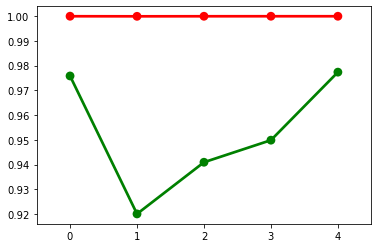

In [121]:
cv_res = cross_validate(cl, X_train[check_features], y_train, scoring= 'r2', n_jobs = -1, cv = cv_splitter, return_train_score = True, verbose = 0)

sns.pointplot(np.arange(n), cv_res['train_score'], color = 'r')
sns.pointplot(np.arange(n), cv_res['test_score'], color = 'g')
plt.show()

In [122]:
cl.fit(X_train[check_features], y_train)
imp = pd.Series(data = cl.feature_importances_, index = check_features)
imp.sort_values(ascending=False).head(10)

patient_id_count_patient_sex_count_shift_0      80
patient_id_count_age_category_growth%_1         74
patient_id_count_age_category_growth_6          72
patient_id_count_patient_sex_mean_3             63
patient_id_count_patient_sex_count_mean_12      62
patient_id_count_patient_sex_shift_12           61
patient_id_count_age_category_shift_12          56
patient_id_count_age_category_growth_3          56
patient_id_count_age_category_count_growth_1    53
patient_id_count_age_category_count_shift_0     51
dtype: int32

In [124]:
features_lgbm_sex_age = lgbm_gain_feats
features_lgbm_sex_age

Index(['patient_id_count_age_category_count_shift_6',
       'patient_id_count_patient_sex_mean_3',
       'Запросов_на_млн_что_делать_дома',
       'patient_id_count_age_category_growth%_1',
       'patient_id_count_age_category_growth_3', 'deaths_Москва',
       'patient_id_count_age_category_min_3',
       'Запросов_на_млн_вызвать_скорую_shift_3',
       'patient_id_count_patient_sex_shift_12',
       'Запросов_на_млн_купить_маску_и_респиратор',
       'patient_id_count_age_category_count_growth_1',
       'patient_id_count_age_category_count_max_12',
       'patient_id_count_age_category_mean_6', 'age_category_vc',
       'deaths_США_shift_6', 'patient_id_count_age_category_count_shift_1',
       'Запросов_на_млн_купить_маску_и_респиратор_growth_3',
       'patient_id_count_mean_12',
       'patient_id_count_age_category_count_min_12',
       'patient_id_count_age_category_mean_12',
       'patient_id_count_age_category_growth_6',
       'patient_id_count_patient_sex_count_mean_12'

Эти признаки мы оставим для итоговой модели.

#### Предикт

In [333]:
cl.fit(X_train[features_lgbm_sex_age], y_train)
sex_age_counts_predict = cl.predict(X_pred[features_lgbm_sex_age])

In [334]:
sex_age_df['patient_id_count_sex_age_lgbm'] = sex_age_df['patient_id_count']
sex_age_df.loc[sex_age_df.time_series == 51, 'patient_id_count_sex_age_lgbm'] = sex_age_counts_predict

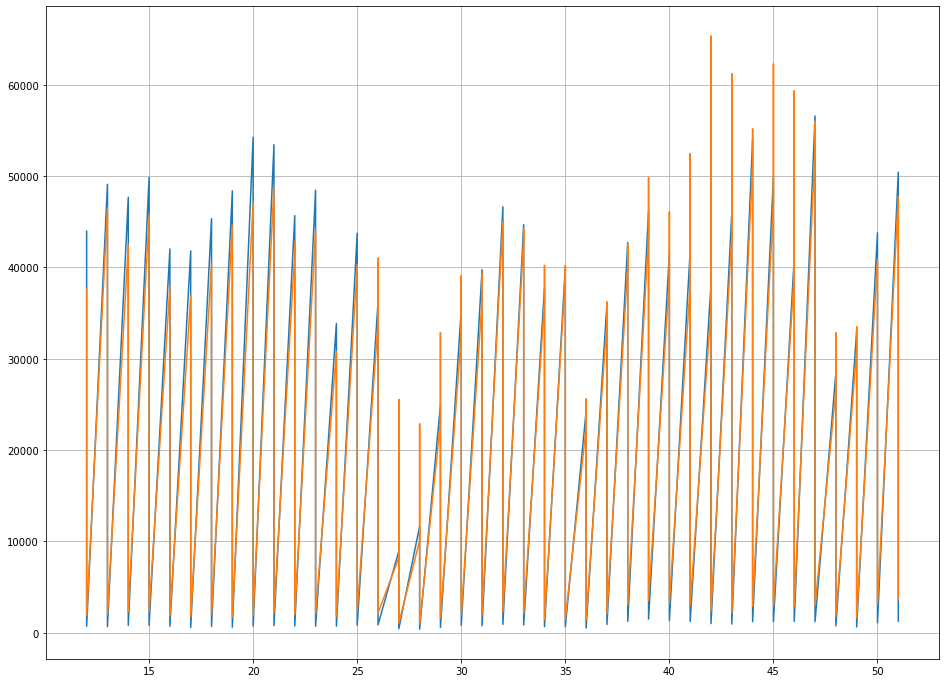

In [137]:
fig, ax = plt.subplots(figsize = (16, 12))

for point in sex_age_df.patient_sex.unique():
    plt.plot(sex_age_df[sex_age_df.patient_sex == point].time_series, sex_age_df[sex_age_df.patient_sex == point].patient_id_count_sex_age_lgbm, label = point)

# plt.xticks(df.groupby('time_series').patient_id_count.sum().index, df['visit_month_year'].unique(), rotation=45)
# plt.yscale('log')
# plt.legend()
plt.grid()
plt.show()

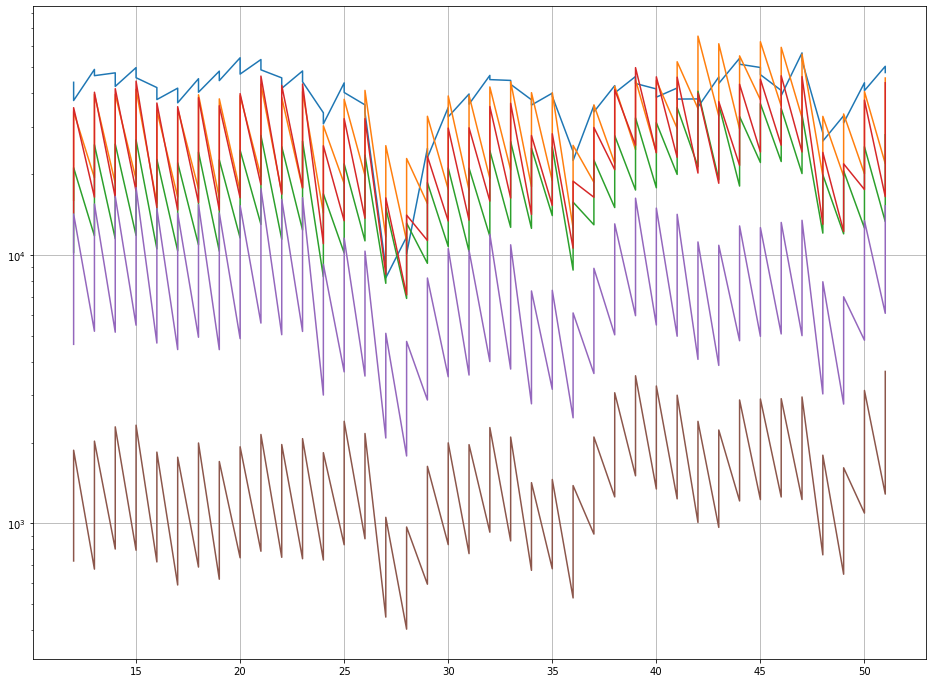

In [138]:
fig, ax = plt.subplots(figsize = (16, 12))

for point in sex_age_df.age_category.unique():
    plt.plot(sex_age_df[sex_age_df.age_category == point].time_series, sex_age_df[sex_age_df.age_category == point].patient_id_count_sex_age_lgbm, label = point)

# plt.xticks(df.groupby('time_series').patient_id_count.sum().index, df['visit_month_year'].unique(), rotation=45)
plt.yscale('log')
# plt.legend()
plt.grid()
plt.show()

In [346]:
# area_df = area_df.rename(columns={'patient_id_count':'patient_id_count_area_lgbm'})
df = df.merge(sex_age_df[['time_series', 'age_category', 'patient_sex', 'patient_id_count_sex_age_lgbm']], on = ['time_series', 'age_category', 'patient_sex'], how = 'left')

### RF. Последовательный отбор фичей

In [139]:
metric_fs_cons_train_prehype2 = pd.DataFrame()
metric_fs_cons_test_prehype2 = pd.DataFrame()

In [140]:
check_features = features

#### RF

In [141]:
fs_method = 'rf'

temp_features = check_features

for p in ps:

    rf.fit(X_train[temp_features], y_train)

    imp = pd.Series(data = rf.feature_importances_, index = temp_features)

    number_of_feats = len(temp_features)
    h = int(number_of_feats * step)

    temp_features = imp.sort_values().iloc[h:].index
    print (len(temp_features))

    cv_res = cross_validate(rf, X_train[temp_features], y_train, 
    scoring= 'r2', n_jobs = -1, cv = cv_splitter, 
    return_train_score = True, verbose = 0)

    cv_train = (cv_res['train_score'] * k).sum()
    cv_test = (cv_res['test_score'].mean() * k).sum()

    metric_fs_cons_train_prehype2.loc[fs_method, p] = cv_train
    metric_fs_cons_test_prehype2.loc[fs_method, p] = cv_test

rf_feats = temp_features

221
177
142
114
92
74
60
48
39
32
26
21
17
14
12
10


#### LGBM (base)

In [142]:
fs_method = 'lgbm'

temp_features = check_features

for p in ps:

    cl.fit(X_train[temp_features], y_train)

    imp = pd.Series(data = cl.feature_importances_, index = temp_features)

    number_of_feats = len(temp_features)
    h = int(number_of_feats * step)

    temp_features = imp.sort_values().iloc[h:].index
    print (len(temp_features))

    cv_res = cross_validate(rf, X_train[temp_features], y_train, 
    scoring= 'r2', n_jobs = -1, cv = cv_splitter, 
    return_train_score = True, verbose = 0)

    cv_train = (cv_res['train_score'] * k).sum()
    cv_test = (cv_res['test_score'].mean() * k).sum()

    metric_fs_cons_train_prehype2.loc[fs_method, p] = cv_train
    metric_fs_cons_test_prehype2.loc[fs_method, p] = cv_test

lgbm_feats = temp_features

221
177
142
114
92
74
60
48
39
32
26
21
17
14
12
10


#### LGBM (gain)

In [143]:
fs_method = 'lgbm_gain'

lg_gain = LGBMRegressor(
    n_jobs = -1, 
    min_child_samples= min_child_samples, 
    max_depth = max_depth, 
    importance_type = 'gain', 
    random_state=random_state,
    learning_rate=learning_rate)

temp_features = check_features

for p in ps:

    lg_gain.fit(X_train[temp_features], y_train)

    imp = pd.Series(data = lg_gain.feature_importances_, index = temp_features)

    number_of_feats = len(temp_features)
    h = int(number_of_feats * step)

    temp_features = imp.sort_values().iloc[h:].index
    print (len(temp_features))

    cv_res = cross_validate(rf, X_train[temp_features], y_train, 
    scoring= 'r2', n_jobs = -1, cv = cv_splitter, 
    return_train_score = True, verbose = 0)

    cv_train = (cv_res['train_score'] * k).sum()
    cv_test = (cv_res['test_score'].mean() * k).sum()

    metric_fs_cons_train_prehype2.loc[fs_method, p] = cv_train
    metric_fs_cons_test_prehype2.loc[fs_method, p] = cv_test

lgbm_gain_feats = temp_features

221
177
142
114
92
74
60
48
39
32
26
21
17
14
12
10


#### Permutation

In [144]:
fs_method = 'permut'

temp_features = check_features

for p in ps:

    rf.fit(X_train[temp_features], y_train)
    res = permutation_importance(rf, X_train[temp_features], y_train, n_repeats= 5, n_jobs = -1, random_state=random_state)
    imp = pd.Series(data = res.importances_mean, index = temp_features)
    
    number_of_feats = len(temp_features)
    h = int(number_of_feats * step)

    temp_features = imp.sort_values().iloc[h:].index
    print (len(temp_features))

    cv_res = cross_validate(rf, X_train[temp_features], y_train, 
    scoring= 'r2', n_jobs = -1, cv = cv_splitter, 
    return_train_score = True, verbose = 0)

    cv_train = (cv_res['train_score'] * k).sum()
    cv_test = (cv_res['test_score'].mean() * k).sum()

    metric_fs_cons_train_prehype2.loc[fs_method, p] = cv_train
    metric_fs_cons_test_prehype2.loc[fs_method, p] = cv_test

perm_feats = temp_features

221
177
142
114
92
74
60
48
39
32
26
21
17
14
12
10


#### Resume

In [145]:
metric_fs_cons_test_prehype2

1         2         3         4         5         6   \
rf         0.782419  0.787139  0.792529  0.793867  0.798456  0.799126   
lgbm       0.785939  0.801290  0.792999  0.806537  0.800510  0.801707   
lgbm_gain  0.784311  0.780131  0.787121  0.796306  0.795532  0.791368   
permut     0.789406  0.798311  0.782822  0.799514  0.802866  0.806626   

                 7         8         9         10        11        12  \
rf         0.802020  0.818274  0.820300  0.823851  0.839352  0.832102   
lgbm       0.812440  0.817615  0.759364  0.766178  0.770381  0.805815   
lgbm_gain  0.799899  0.804505  0.819949  0.824242  0.823257  0.808872   
permut     0.800145  0.817975  0.825028  0.828029  0.835225  0.840302   

                 13        14        15        16  
rf         0.841781  0.856221  0.874746  0.868021  
lgbm       0.800508  0.812440  0.800578  0.726545  
lgbm_gain  0.835865  0.843950  0.837076  0.826232  
permut     0.849263  0.880446  0.873384  0.866462

In [146]:
metric_fs_cons_dif_prehype2 = metric_fs_cons_train_prehype2 - metric_fs_cons_test_prehype2

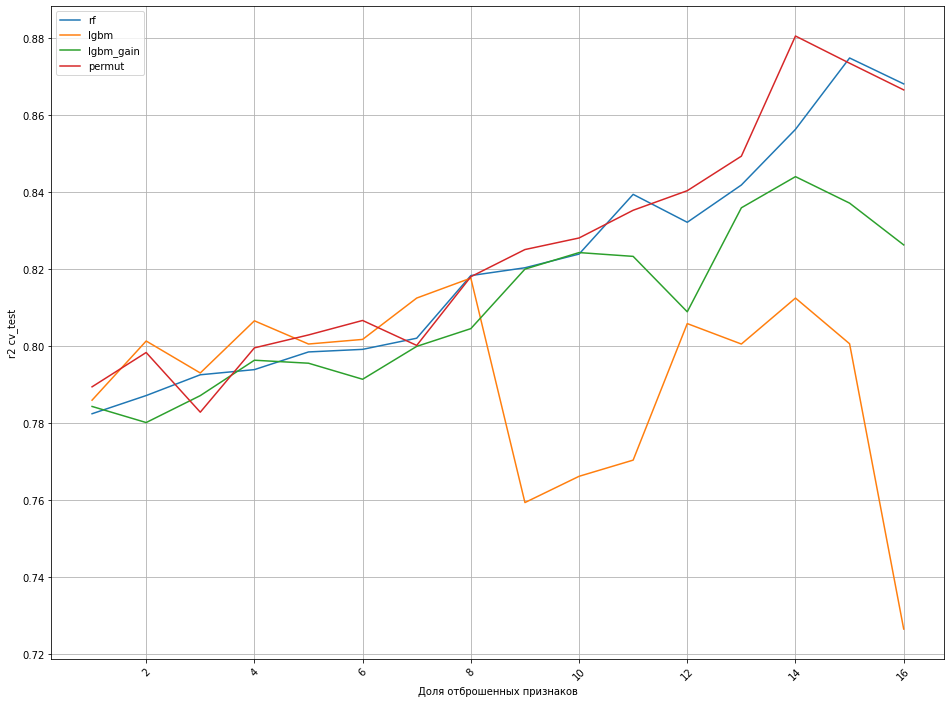

In [147]:
check_index = ['rf', 'lgbm','lgbm_gain','permut']
fig, ax = plt.subplots(figsize=(16, 12))
for i in check_index:
    ax.plot(np.array(metric_fs_cons_test_prehype2.columns), metric_fs_cons_test_prehype2.loc[i, :], label=i)
ax.legend()
ax.set_xlabel('Доля отброшенных признаков')
ax.set_ylabel('r2 cv_test')
ax.grid(True)
plt.xticks(rotation = 45)
plt.show()

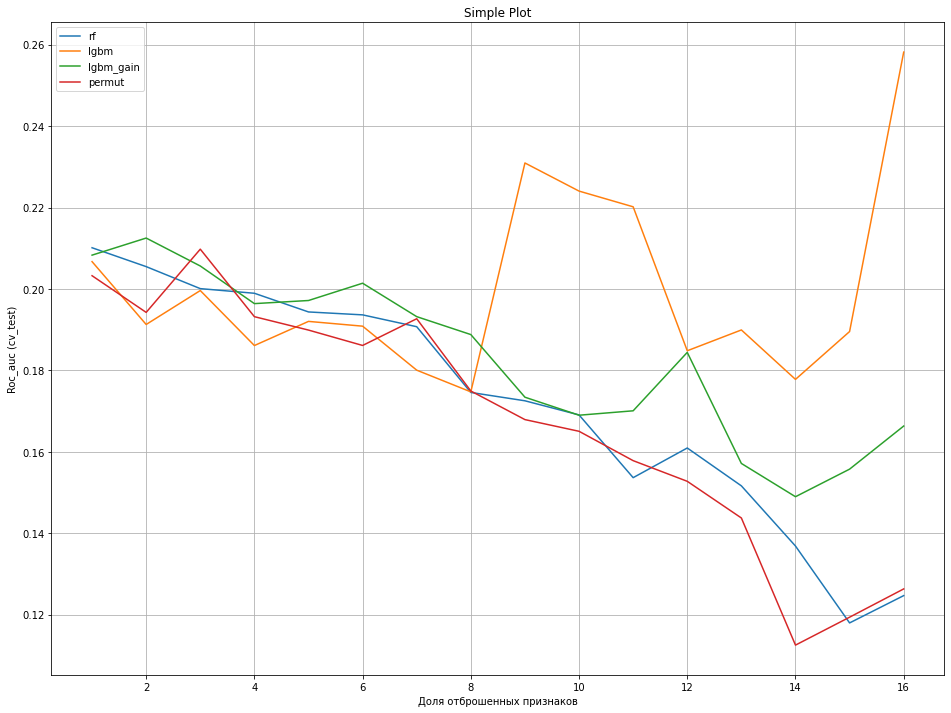

In [148]:
fig, ax = plt.subplots(figsize=(16, 12))
for i in check_index:
    ax.plot(metric_fs_cons_dif_prehype2.columns, metric_fs_cons_dif_prehype2.loc[i, :], label=i)
ax.legend()
plt.title("Simple Plot")
ax.set_xlabel('Доля отброшенных признаков')
ax.set_ylabel('Roc_auc (cv_test)')
ax.grid(True)
plt.show()

#### Докрутка

In [149]:
fs_method = 'permut'

temp_features = check_features

for p in range(1, 15):

    rf.fit(X_train[temp_features], y_train)
    res = permutation_importance(rf, X_train[temp_features], y_train, n_repeats= 5, n_jobs = -1, random_state=random_state)
    imp = pd.Series(data = res.importances_mean, index = temp_features)
    
    number_of_feats = len(temp_features)
    h = int(number_of_feats * step)

    temp_features = imp.sort_values().iloc[h:].index
    print (len(temp_features))

    cv_res = cross_validate(rf, X_train[temp_features], y_train, 
    scoring= 'r2', n_jobs = -1, cv = cv_splitter, 
    return_train_score = True, verbose = 0)

    cv_train = (cv_res['train_score'] * k).sum()
    cv_test = (cv_res['test_score'].mean() * k).sum()

    metric_fs_cons_train_prehype2.loc[fs_method, p] = cv_train
    metric_fs_cons_test_prehype2.loc[fs_method, p] = cv_test

perm_feats = temp_features

221
177
142
114
92
74
60
48
39
32
26
21
17
14


In [150]:
check_features = perm_feats

In [151]:
metric_table = pd.DataFrame()
i = 0
for max_depth_rf in [None, 12, 11, 10, 8, 6, 4]:
    for min_samples_leaf in [2, 16]:
            for n_estimators_rf in [100, 200, 400, 700]:

                print (i)

                rf = RandomForestRegressor(
                    n_jobs = -1, 
                    max_depth = max_depth_rf, 
                    min_samples_leaf = min_samples_leaf, 
                    n_estimators = n_estimators_rf,
                    random_state=random_state)
                
                cv_res = cross_validate(rf, X_train[check_features], y_train, scoring= 'r2', n_jobs = -1, cv = cv_splitter, return_train_score = True, verbose = 0)

                cv_train = (cv_res['train_score'].mean() * k).sum()
                cv_test = (cv_res['test_score'].mean() * k).sum()
                
                metric_table.loc[i, 'max_depth'] = max_depth_rf
                metric_table.loc[i, 'min_samples_leaf'] = min_samples_leaf
                metric_table.loc[i, 'n_estimators'] = n_estimators_rf
                
                metric_table.loc[i, 'cv_train'] = cv_train
                metric_table.loc[i, 'cv_test'] = cv_test

                i+=1
                        
metric_table['cv_dif'] = metric_table['cv_train'] - metric_table['cv_test']

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55


In [152]:
metric_table.sort_values(by = 'cv_test', ascending = False)

max_depth  min_samples_leaf  n_estimators  cv_train   cv_test    cv_dif
19       11.0               2.0         700.0  0.993537  0.882847  0.110690
3         NaN               2.0         700.0  0.993598  0.882697  0.110900
11       12.0               2.0         700.0  0.993575  0.882374  0.111201
35        8.0               2.0         700.0  0.991934  0.880647  0.111287
17       11.0               2.0         200.0  0.993282  0.880576  0.112706
9        12.0               2.0         200.0  0.993339  0.880447  0.112891
8        12.0               2.0         100.0  0.992909  0.880446  0.112463
1         NaN               2.0         200.0  0.993363  0.880074  0.113289
27       10.0               2.0         700.0  0.993380  0.879464  0.113916
2         NaN               2.0         400.0  0.993647  0.877790  0.115857
43        6.0               2.0         700.0  0.985145  0.876226  0.108919
18       11.0               2.0         400.0  0.993583  0.876094  0.117489
10       12.0               2.0         400.0  0.993627  0.875844  0.117783
0         NaN               2.0         100.0  0.992921  0.875727  0.117194
16       11.0               2.0         100.0  0.992824  0.875626  0.117198
34        8.0               2.0         400.0  0.991976  0.875437  0.116539
7         NaN              16.0         700.0  0.941636  0.874880  0.066756
39        8.0              16.0         700.0  0.941636  0.874880  0.066756
31       10.0              16.0         700.0  0.941636  0.874880  0.066756
23       11.0              16.0         700.0  0.941636  0.874880  0.066756
15       12.0              16.0         700.0  0.941636  0.874880  0.066756
47        6.0              16.0         700.0  0.941633  0.874861  0.066772
25       10.0               2.0         200.0  0.993134  0.874682  0.118452
33        8.0               2.0         200.0  0.991715  0.874399  0.117315
26       10.0               2.0         400.0  0.993431  0.873675  0.119756
6         NaN              16.0         400.0  0.941608  0.873090  0.068519
30       10.0              16.0         400.0  0.941608  0.873090  0.068519
14       12.0              16.0         400.0  0.941608  0.873090  0.068519
22       11.0              16.0         400.0  0.941608  0.873090  0.068519
38        8.0              16.0         400.0  0.941608  0.873090  0.068519
46        6.0              16.0         400.0  0.941603  0.873060  0.068544
5         NaN              16.0         200.0  0.941434  0.872578  0.068856
29       10.0              16.0         200.0  0.941434  0.872578  0.068856
21       11.0              16.0         200.0  0.941434  0.872578  0.068856
37        8.0              16.0         200.0  0.941434  0.872578  0.068856
13       12.0              16.0         200.0  0.941434  0.872578  0.068856
45        6.0              16.0         200.0  0.941429  0.872534  0.068895
28       10.0              16.0         100.0  0.940657  0.871874  0.068783
36        8.0              16.0         100.0  0.940657  0.871874  0.068783
20       11.0              16.0         100.0  0.940657  0.871874  0.068783
12       12.0              16.0         100.0  0.940657  0.871874  0.068783
4         NaN              16.0         100.0  0.940657  0.871874  0.068783
44        6.0              16.0         100.0  0.940648  0.871782  0.068866
24       10.0               2.0         100.0  0.992716  0.871528  0.121188
41        6.0               2.0         200.0  0.984885  0.870996  0.113890
55        4.0              16.0         700.0  0.937744  0.869889  0.067854
40        6.0               2.0         100.0  0.984275  0.869124  0.115151
32        8.0               2.0         100.0  0.991275  0.868980  0.122295
54        4.0              16.0         400.0  0.937747  0.868336  0.069411
53        4.0              16.0         200.0  0.937575  0.868235  0.069340
52        4.0              16.0         100.0  0.936684  0.867578  0.069106
42        6.0               2.0         400.0  0.985

In [153]:
max_depth_rf = 11
min_samples_leaf = 2
n_estimators_rf = 700
rf = RandomForestRegressor(
    n_jobs = -1, 
    max_depth = max_depth_rf, 
    min_samples_leaf = min_samples_leaf, 
    n_estimators = n_estimators_rf,
    random_state=random_state)

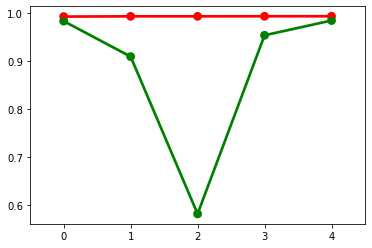

In [154]:
cv_res = cross_validate(rf, X_train[check_features], y_train, scoring= 'r2', n_jobs = -1, cv = cv_splitter, return_train_score = True, verbose = 0)

sns.pointplot(np.arange(n), cv_res['train_score'], color = 'r')
sns.pointplot(np.arange(n), cv_res['test_score'], color = 'g')
plt.show()

In [155]:
rf.fit(X_train[check_features], y_train)
imp = pd.Series(data = rf.feature_importances_, index = check_features)
imp.sort_values(ascending=False).head(10)

age_category_patient_sex_sum                   0.729103
patient_id_count_age_category_shift_1          0.086813
patient_id_count_count_shift_0                 0.056933
age_category_patient_sex_count                 0.055038
patient_id_count_age_category_count_shift_0    0.016082
patient_id_count_age_category_growth_12        0.010803
patient_id_count_age_category_shift_12         0.009416
patient_id_count_age_category_mean_3           0.007482
patient_id_count_age_category_max_3            0.006676
patient_id_count_patient_sex_count_shift_0     0.005331
dtype: float64

In [156]:
features_rf_sex_age = perm_feats
features_rf_sex_age

Index(['patient_id_count_age_category_growth_12',
       'Запросов_на_млн_купить_маску_и_респиратор_shift_12',
       'Запросов_на_млн_что_делать_дома',
       'Запросов_на_млн_симптомы_коронавируса_shift_12',
       'patient_id_count_age_category_mean_3',
       'patient_id_count_patient_sex_count_shift_0',
       'patient_id_count_age_category_max_3', 'age_category_young',
       'patient_id_count_age_category_shift_12',
       'patient_id_count_age_category_count_shift_0',
       'age_category_patient_sex_count', 'patient_id_count_count_shift_0',
       'patient_id_count_age_category_shift_1',
       'age_category_patient_sex_sum'],
      dtype='object')

Эти признаки мы оставим для итоговой модели.

# Отбор признаков по первой букве кода МКБ-10

In [189]:
cols4 = list(df.loc[:10, 'patient_id_count_litera_mkb_code_shift_1':'patient_id_count_litera_mkb_code_count_max_12'].columns)

cols3 = list(df.loc[:10, 'patient_id_count_shift_1':'patient_id_count_count_max_12'].columns)
cols2 = list(df.loc[:10, 'deaths_Россия':'Запросов_на_млн_купить_маску_и_респиратор'].columns)
cols = list(df.loc[:10, 'deaths_Россия_shift_1':'Запросов_на_млн_купить_маску_и_респиратор_max_12'].columns)

In [195]:
mkb_df = df.fillna(0).groupby(['time_series','time_series_24_flag', 
'litera_mkb_code', 'not_full_mkb_code', 'month', 'year',
] + cols + cols2 + cols3 + cols4 + ['litera_mkb_code_vc'], as_index = False).patient_id_count.sum()

In [196]:
bt = mkb_df.sort_values(by = ['time_series'])

In [212]:
features = bt.columns.drop(['patient_id_count', 'litera_mkb_code'])
bt.drop((bt == np.inf).sum()[(bt == np.inf).sum() > 0].index, axis = 1, inplace = True)
features = bt.columns.drop(['patient_id_count', 'litera_mkb_code'])

In [213]:
bt.shape

(1712, 223)

In [214]:
scl = StandardScaler()

bt[features] = scl.fit_transform(bt[features])

In [215]:
X_train = bt[mkb_df.time_series != 51][features].sort_index()
X_pred = bt[mkb_df.time_series == 51][features].sort_index()

y_train = bt.loc[mkb_df.time_series != 51, ['patient_id_count']].sort_index()

In [216]:
len(X_pred)

44

In [217]:
random_state = 42
# cv_splitter = KFold(n_splits=4, shuffle = True, random_state=random_state)
n = 5
cv_splitter = TimeSeriesSplit(n_splits=n, test_size=len(X_pred))
ps = np.arange(1, 15, 1)
step = 0.2
k = np.array([0.1, 0.15, 0.2, 0.25, 0.3])

# features_reg = features
check_features = features

In [218]:
metric_table = pd.DataFrame()

i = 0
for max_depth in [-1, 8, 6, 4, 2]:
    for min_child_samples in [10, 20, 40, 80]:
        for learning_rate in [0.1, 0.3]:
            print (i)
            
            cl = LGBMRegressor(
                # n_jobs = -1, 
                max_depth = max_depth, 
                min_child_samples = min_child_samples, 
                learning_rate = learning_rate, 
                random_state=random_state)
            
            cv_res = cross_validate(cl, X_train[check_features], y_train, scoring= 'r2', n_jobs = -1, cv = cv_splitter, return_train_score = True, verbose = 0)

            cv_train = (cv_res['train_score'] * k).sum()
            cv_test = (cv_res['test_score'] * k).sum()
            
            
            metric_table.loc[i, 'cv_train'] = cv_train
            metric_table.loc[i, 'cv_test'] = cv_test
            metric_table.loc[i, 'max_depth'] = max_depth
            metric_table.loc[i, 'learning_rate'] = learning_rate
            metric_table.loc[i, 'min_child_samples'] = min_child_samples

            i +=1

            # cl.fit(X_train[check_features], y_train)
            # metric_table.loc[params, 'count_imp=0'] = np.where(cl.feature_importances_ == 1, 1, 0).sum()
            # imp = pd.Series(data = cl.feature_importances_, index = check_features)
            # sns.histplot(imp, bins = 20)
            # plt.show()
                
metric_table['cv_dif'] = metric_table['cv_train'] - metric_table['cv_test']

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


In [219]:
metric_table.sort_values(by = 'cv_test', ascending= False)

cv_train   cv_test  max_depth  learning_rate  min_child_samples    cv_dif
1   0.999437  0.852733       -1.0            0.3               10.0  0.146703
23  0.941526  0.844182        6.0            0.3               80.0  0.097344
31  0.939096  0.837480        4.0            0.3               80.0  0.101616
9   0.999606  0.836702        8.0            0.3               10.0  0.162904
26  0.960252  0.829608        4.0            0.1               20.0  0.130644
34  0.939200  0.827263        2.0            0.1               20.0  0.111937
15  0.940264  0.824935        8.0            0.3               80.0  0.115328
7   0.939505  0.822859       -1.0            0.3               80.0  0.116647
17  0.999606  0.819792        6.0            0.3               10.0  0.179814
25  0.998796  0.814042        4.0            0.3               10.0  0.184754
10  0.960866  0.812999        8.0            0.1               20.0  0.147867
39  0.894835  0.812539        2.0            0.3               80.0  0.082296
2   0.960308  0.812261       -1.0            0.1               20.0  0.148047
8   0.993157  0.811726        8.0            0.1               10.0  0.181430
0   0.993172  0.808330       -1.0            0.1               10.0  0.184841
18  0.959896  0.805547        6.0            0.1               20.0  0.154348
16  0.993293  0.803370        6.0            0.1               10.0  0.189924
32  0.966817  0.798099        2.0            0.1               10.0  0.168718
5   0.976497  0.797987       -1.0            0.3               40.0  0.178511
35  0.954301  0.796456        2.0            0.3               20.0  0.157845
36  0.904460  0.794944        2.0            0.1               40.0  0.109515
24  0.994908  0.794878        4.0            0.1               10.0  0.200030
27  0.992703  0.787822        4.0            0.3               20.0  0.204880
14  0.837946  0.787441        8.0            0.1               80.0  0.050505
21  0.974382  0.782602        6.0            0.3               40.0  0.191780
38  0.853195  0.781682        2.0            0.1               80.0  0.071513
30  0.835636  0.781260        4.0            0.1               80.0  0.054376
6   0.835328  0.780834       -1.0            0.1               80.0  0.054495
37  0.933217  0.780810        2.0            0.3               40.0  0.152407
22  0.837552  0.779777        6.0            0.1               80.0  0.057774
33  0.974442  0.773299        2.0            0.3               10.0  0.201143
13  0.975820  0.770576        8.0            0.3               40.0  0.205244
19  0.994423  0.769186        6.0            0.3               20.0  0.225237
28  0.894545  0.767813        4.0            0.1               40.0  0.126732
20  0.894913  0.766649        6.0            0.1               40.0  0.128264
4   0.896344  0.766428       -1.0            0.1               40.0  0.129916
12  0.895558  0.758260        8.0            0.1               40.0  0.137298
29  0.971802  0.751740        4.0            0.3               40.0  0.220062
11  0.993889  0.732767        8.0            0.3               20.0  0.261122
3   0.993979  0.714402       -1.0            0.3               20.0  0.279577

In [220]:
max_depth = -1
learning_rate = 0.3
min_child_samples = 10
cl = LGBMRegressor(
    n_jobs = -1, 
    max_depth = max_depth, 
    min_child_samples= min_child_samples, 
    learning_rate = learning_rate, 
    random_state=random_state)

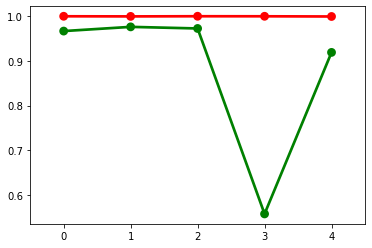

In [221]:
cv_res = cross_validate(cl, X_train[check_features], y_train, scoring= 'r2', #n_jobs = -1, 
cv = cv_splitter, return_train_score = True, verbose = 0)

sns.pointplot(np.arange(n), cv_res['train_score'], color = 'r')
sns.pointplot(np.arange(n), cv_res['test_score'], color = 'g')
plt.show()

In [222]:
cl.fit(X_train[check_features], y_train)
imp = pd.Series(data = cl.feature_importances_, index = check_features)
imp.sort_values(ascending=False).head(10)

not_full_mkb_code                                 322
patient_id_count_litera_mkb_code_growth_12        137
patient_id_count_litera_mkb_code_shift_1          133
patient_id_count_litera_mkb_code_growth_1         132
patient_id_count_litera_mkb_code_growth_6         129
patient_id_count_litera_mkb_code_shift_12         117
patient_id_count_litera_mkb_code_shift_6          105
patient_id_count_litera_mkb_code_count_shift_0    104
patient_id_count_litera_mkb_code_max_3            100
patient_id_count_litera_mkb_code_mean_3            98
dtype: int32

In [223]:
metric_table = pd.DataFrame()

i = 0
for max_depth_rf in [None, 12, 10, 8, 6]:
    for min_samples_leaf in [2, 16]:
        for n_estimators_rf in [100]:
            print (i)
            rf = RandomForestRegressor(
                n_jobs = -1, 
                max_depth = max_depth_rf, 
                min_samples_leaf = min_samples_leaf, 
                n_estimators = n_estimators_rf, 
                random_state=random_state)
            
            cv_res = cross_validate(rf, X_train[check_features], y_train, scoring= 'r2', #n_jobs = -1, 
            cv = cv_splitter, return_train_score = True, verbose = 0)
            
            cv_train = (cv_res['train_score'] * k).sum()
            cv_test = (cv_res['test_score'] * k).sum()
            
            
            metric_table.loc[i, 'cv_train'] = cv_train
            metric_table.loc[i, 'cv_test'] = cv_test
            metric_table.loc[i, 'max_depth'] = max_depth_rf
            metric_table.loc[i, 'n_estimators'] = n_estimators_rf
            metric_table.loc[i, 'min_samples_leaf'] = min_samples_leaf

            i +=1
                
metric_table['cv_dif'] = metric_table['cv_train'] - metric_table['cv_test']

0
1
2
3
4
5
6
7
8
9


In [225]:
metric_table.sort_values(by = 'cv_test', ascending= False).head(10)

cv_train   cv_test  max_depth  n_estimators  min_samples_leaf    cv_dif
1  0.852086  0.812910        NaN         100.0              16.0  0.039176
3  0.852086  0.812910       12.0         100.0              16.0  0.039176
9  0.851759  0.812337        6.0         100.0              16.0  0.039422
5  0.852081  0.811446       10.0         100.0              16.0  0.040635
7  0.852061  0.811363        8.0         100.0              16.0  0.040698
6  0.990480  0.778590        8.0         100.0               2.0  0.211890
2  0.991173  0.774230       12.0         100.0               2.0  0.216943
0  0.991021  0.769279        NaN         100.0               2.0  0.221743
8  0.987922  0.763726        6.0         100.0               2.0  0.224196
4  0.990901  0.761255       10.0         100.0               2.0  0.229646

In [226]:
max_depth_rf = None
n_estimators_rf = 100
min_samples_leaf = 16
rf = RandomForestRegressor(
                n_jobs = -1, 
                max_depth = max_depth_rf, 
                min_samples_leaf = min_samples_leaf, 
                n_estimators = n_estimators_rf, 
                random_state=random_state)

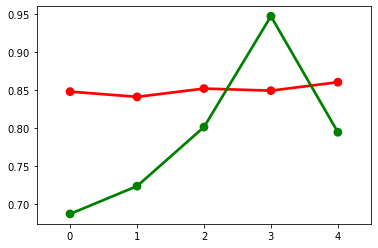

In [227]:
cv_res = cross_validate(rf, X_train[check_features], y_train, scoring= 'r2', n_jobs = -1, cv = cv_splitter, return_train_score = True, verbose = 0)

sns.pointplot(np.arange(n), cv_res['train_score'], color = 'r')
sns.pointplot(np.arange(n), cv_res['test_score'], color = 'g')
plt.show()

In [228]:
rf.fit(X_train[check_features], y_train)
imp = pd.Series(data = rf.feature_importances_, index = check_features)
imp.sort_values(ascending=False).head(10)

not_full_mkb_code                                 0.404220
patient_id_count_litera_mkb_code_shift_1          0.223891
patient_id_count_litera_mkb_code_count_shift_0    0.062011
patient_id_count_litera_mkb_code_shift_12         0.055187
patient_id_count_litera_mkb_code_mean_12          0.053124
patient_id_count_litera_mkb_code_mean_3           0.047403
patient_id_count_litera_mkb_code_min_3            0.026744
patient_id_count_litera_mkb_code_max_12           0.021319
patient_id_count_litera_mkb_code_shift_3          0.017033
patient_id_count_litera_mkb_code_max_3            0.016563
dtype: float64

### LGBM. Последовательный отбор фичей

In [229]:
metric_fs_cons_train_prehype2 = pd.DataFrame()
metric_fs_cons_test_prehype2 = pd.DataFrame()

In [230]:
check_features = features

#### RF

In [232]:
fs_method = 'rf'

rf = RandomForestRegressor(
    n_jobs = -1, 
    random_state = random_state, 
    max_depth=max_depth_rf, 
    n_estimators = n_estimators_rf,
    min_samples_leaf=min_samples_leaf)

temp_features = check_features

for p in ps:

    rf.fit(X_train[temp_features], y_train)

    imp = pd.Series(data = rf.feature_importances_, index = temp_features)

    number_of_feats = len(temp_features)
    h = int(number_of_feats * step)

    temp_features = imp.sort_values().iloc[h:].index
    print (len(temp_features))

    cv_res = cross_validate(cl, X_train[temp_features], y_train, 
    scoring= 'r2', 
    #n_jobs = -1, 
    cv = cv_splitter, 
    return_train_score = True, verbose = 0)

    cv_train = (cv_res['train_score'] * k).sum()
    cv_test = (cv_res['test_score'].mean() * k).sum()

    metric_fs_cons_train_prehype2.loc[fs_method, p] = cv_train
    metric_fs_cons_test_prehype2.loc[fs_method, p] = cv_test

rf_feats = temp_features

177
142
114
92
74
60
48
39
32
26
21
17
14
12


#### LGBM (base)

In [233]:
fs_method = 'lgbm'

temp_features = check_features

for p in ps:

    cl.fit(X_train[temp_features], y_train)

    imp = pd.Series(data = cl.feature_importances_, index = temp_features)

    number_of_feats = len(temp_features)
    h = int(number_of_feats * step)

    temp_features = imp.sort_values().iloc[h:].index
    print (len(temp_features))

    cv_res = cross_validate(cl, X_train[temp_features], y_train, 
    scoring= 'r2', n_jobs = -1, cv = cv_splitter, 
    return_train_score = True, verbose = 0)

    cv_train = (cv_res['train_score'] * k).sum()
    cv_test = (cv_res['test_score'].mean() * k).sum()

    metric_fs_cons_train_prehype2.loc[fs_method, p] = cv_train
    metric_fs_cons_test_prehype2.loc[fs_method, p] = cv_test

lgbm_feats = temp_features

177
142
114
92
74
60
48
39
32
26
21
17
14
12


#### LGBM (gain)

In [234]:
fs_method = 'lgbm_gain'

lg_gain = LGBMRegressor(
    n_jobs = -1, 
    min_child_samples= min_child_samples, 
    max_depth = max_depth, 
    importance_type = 'gain', 
    random_state=random_state,
    learning_rate=learning_rate)

temp_features = check_features

for p in ps:

    lg_gain.fit(X_train[temp_features], y_train)

    imp = pd.Series(data = lg_gain.feature_importances_, index = temp_features)

    number_of_feats = len(temp_features)
    h = int(number_of_feats * step)

    temp_features = imp.sort_values().iloc[h:].index
    print (len(temp_features))

    cv_res = cross_validate(cl, X_train[temp_features], y_train, 
    scoring= 'r2', n_jobs = -1, cv = cv_splitter, 
    return_train_score = True, verbose = 0)

    cv_train = (cv_res['train_score'] * k).sum()
    cv_test = (cv_res['test_score'].mean() * k).sum()

    metric_fs_cons_train_prehype2.loc[fs_method, p] = cv_train
    metric_fs_cons_test_prehype2.loc[fs_method, p] = cv_test

lgbm_gain_feats = temp_features

177
142
114
92
74
60
48
39
32
26
21
17
14
12


#### Permutation

In [235]:
fs_method = 'permut'

temp_features = check_features

for p in ps:

    cl.fit(X_train[temp_features], y_train)
    res = permutation_importance(cl, X_train[temp_features], y_train, n_repeats= 5, 
    #n_jobs = -1, 
    random_state=random_state)
    imp = pd.Series(data = res.importances_mean, index = temp_features)
    
    number_of_feats = len(temp_features)
    h = int(number_of_feats * step) 

    temp_features = imp.sort_values().iloc[h:].index
    print (len(temp_features))

    cv_res = cross_validate(cl, X_train[temp_features], y_train, 
    scoring= 'r2', n_jobs = -1, cv = cv_splitter, 
    return_train_score = True, verbose = 0)

    cv_train = (cv_res['train_score'] * k).sum()
    cv_test = (cv_res['test_score'].mean() * k).sum()

    metric_fs_cons_train_prehype2.loc[fs_method, p] = cv_train
    metric_fs_cons_test_prehype2.loc[fs_method, p] = cv_test

perm_feats = temp_features

177
142
114
92
74
60
48
39
32
26
21
17
14
12


#### Resume

In [236]:
metric_fs_cons_test_prehype2

1         2         3         4         5         6   \
rf         0.862083  0.835832  0.839843  0.840515  0.825036  0.816696   
lgbm       0.854881  0.847138  0.850102  0.830125  0.809074  0.818733   
lgbm_gain  0.856951  0.870864  0.849644  0.851454  0.849077  0.845557   
permut     0.856202  0.848154  0.840995  0.850076  0.855040  0.833943   

                 7         8         9         10        11        12  \
rf         0.823575  0.810987  0.830972  0.821222  0.822621  0.826021   
lgbm       0.822266  0.811309  0.856486  0.829783  0.822374  0.829911   
lgbm_gain  0.808420  0.814840  0.810244  0.850654  0.823993  0.852132   
permut     0.846400  0.833689  0.822855  0.851686  0.846081  0.864289   

                 13        14  
rf         0.811630  0.805264  
lgbm       0.830710  0.823721  
lgbm_gain  0.811304  0.817935  
permut     0.819938  0.785390

In [237]:
metric_fs_cons_dif_prehype2 = metric_fs_cons_train_prehype2 - metric_fs_cons_test_prehype2

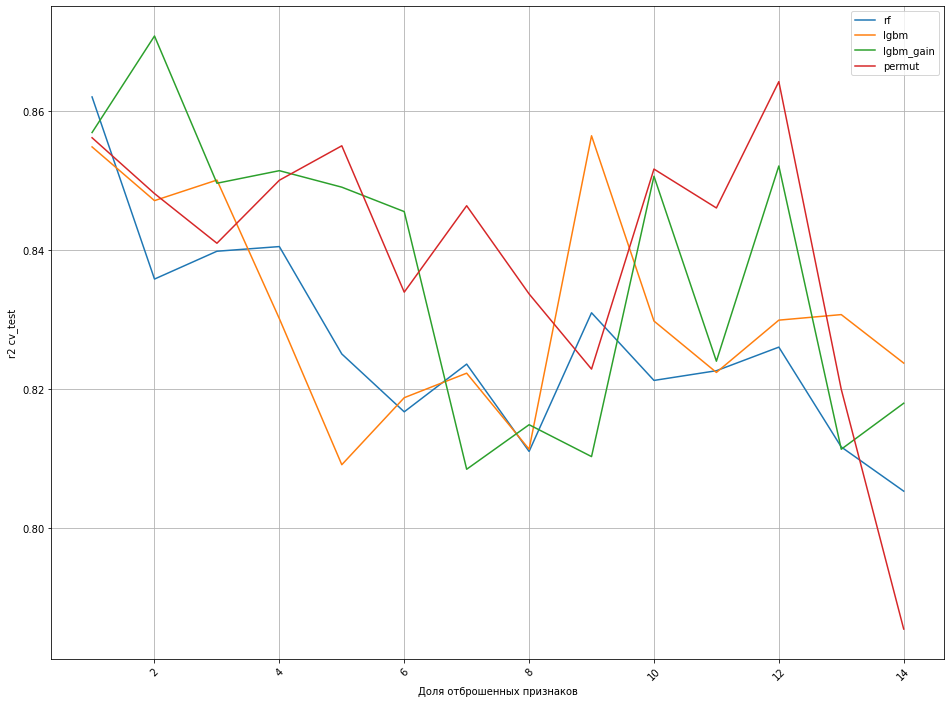

In [239]:
check_index = ['rf', 'lgbm','lgbm_gain','permut']
fig, ax = plt.subplots(figsize=(16, 12))
for i in check_index:
    ax.plot(np.array(metric_fs_cons_test_prehype2.columns), metric_fs_cons_test_prehype2.loc[i, :], label=i)
ax.legend()
ax.set_xlabel('Доля отброшенных признаков')
ax.set_ylabel('r2 cv_test')
ax.grid(True)
plt.xticks(rotation = 45)
plt.show()

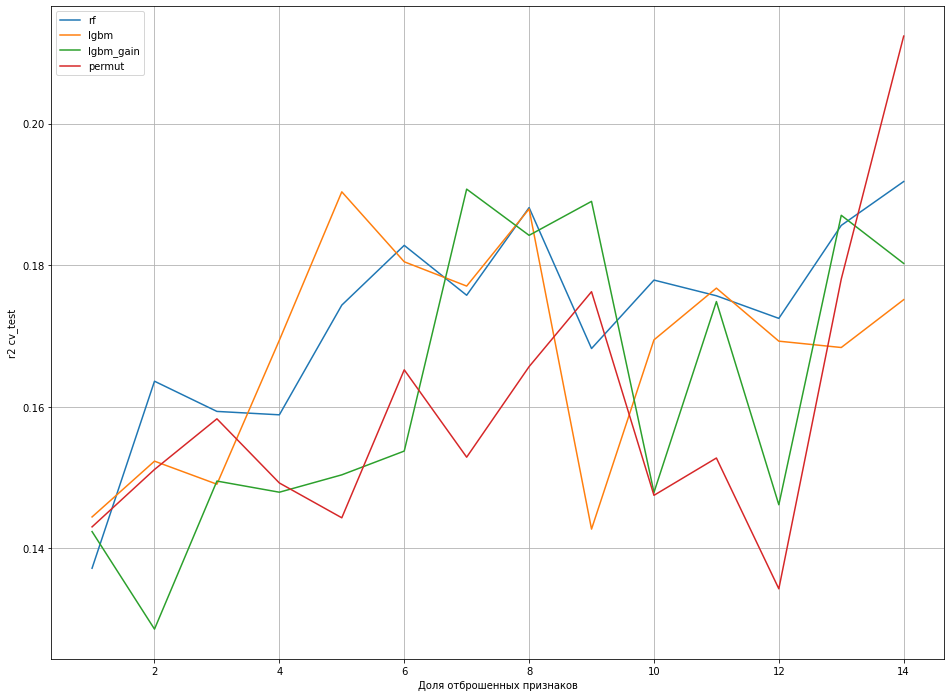

In [240]:
fig, ax = plt.subplots(figsize=(16, 12))
for i in check_index:
    ax.plot(metric_fs_cons_dif_prehype2.columns, metric_fs_cons_dif_prehype2.loc[i, :], label=i)
ax.legend()
ax.set_xlabel('Доля отброшенных признаков')
ax.set_ylabel('r2 cv_test')
ax.grid(True)
plt.show()

#### Докрутка

In [241]:
fs_method = 'lgbm_gain'

lg_gain = LGBMRegressor(
    n_jobs = -1, 
    min_child_samples= min_child_samples, 
    max_depth = max_depth, 
    importance_type = 'gain', 
    random_state=random_state,
    learning_rate=learning_rate)

temp_features = check_features

for p in range(1,3):

    lg_gain.fit(X_train[temp_features], y_train)

    imp = pd.Series(data = lg_gain.feature_importances_, index = temp_features)

    number_of_feats = len(temp_features)
    h = int(number_of_feats * step)

    temp_features = imp.sort_values().iloc[h:].index
    print (len(temp_features))

    cv_res = cross_validate(cl, X_train[temp_features], y_train, 
    scoring= 'r2', n_jobs = -1, cv = cv_splitter, 
    return_train_score = True, verbose = 0)

    cv_train = (cv_res['train_score'] * k).sum()
    cv_test = (cv_res['test_score'].mean() * k).sum()

    metric_fs_cons_train_prehype2.loc[fs_method, p] = cv_train
    metric_fs_cons_test_prehype2.loc[fs_method, p] = cv_test

lgbm_gain_feats = temp_features

177
142


In [242]:
check_features = lgbm_gain_feats

In [247]:
len(check_features)

142

In [249]:
metric_table = pd.DataFrame()

i = 0
for max_depth in [-1, 10, 8, 6, 5, 4]:
    for min_child_samples in [10, 20, 40, 80]:
        for learning_rate in [0.1, 0.3]:
            for n_estimators in [100]:
                print (i)
                cl = LGBMRegressor(
                    n_jobs = -1, 
                    max_depth = max_depth, 
                    min_child_samples = min_child_samples, 
                    learning_rate = learning_rate,
                    n_estimators = n_estimators,
                    random_state=random_state)
                
                cv_res = cross_validate(cl, X_train[check_features], y_train, scoring= 'r2', n_jobs = 4, 
                cv = cv_splitter, return_train_score = True, verbose = 0)

                cv_train = (cv_res['train_score'] * k).sum()
                cv_test = (cv_res['test_score'] * k).sum()
                
                
                metric_table.loc[i, 'cv_train'] = cv_train
                metric_table.loc[i, 'cv_test'] = cv_test
                metric_table.loc[i, 'max_depth'] = max_depth
                metric_table.loc[i, 'learning_rate'] = learning_rate
                metric_table.loc[i, 'min_child_samples'] = min_child_samples
                metric_table.loc[i, 'n_estimators'] = n_estimators

                i +=1
                
metric_table['cv_dif'] = metric_table['cv_train'] - metric_table['cv_test']

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47


In [250]:
metric_table.sort_values(by = 'cv_test', ascending= False).head(10)

cv_train   cv_test  max_depth  learning_rate  min_child_samples  \
1   0.999451  0.843943       -1.0            0.3               10.0   
47  0.938859  0.840351        4.0            0.3               80.0   
39  0.938952  0.839172        5.0            0.3               80.0   
9   0.999205  0.838392       10.0            0.3               10.0   
7   0.940974  0.837560       -1.0            0.3               80.0   
42  0.960988  0.834848        4.0            0.1               20.0   
33  0.999507  0.833572        5.0            0.3               10.0   
31  0.940673  0.832625        6.0            0.3               80.0   
15  0.942514  0.831273       10.0            0.3               80.0   
17  0.999478  0.828614        8.0            0.3               10.0   

    n_estimators    cv_dif  
1          100.0  0.155508  
47         100.0  0.098508  
39         100.0  0.099780  
9          100.0  0.160813  
7          100.0  0.103414  
42         100.0  0.126140  
33         100.0  0.165935  
31         100.0  0.108048  
15         100.0  0.111241  
17         100.0  0.170864

In [251]:
max_depth = 4
learning_rate = 0.3
min_child_samples = 80
n_estimators = 100
cl = LGBMRegressor(
    n_jobs = -1, 
    max_depth = max_depth, 
    min_child_samples= min_child_samples, 
    learning_rate = learning_rate, 
    n_estimators = n_estimators,
    random_state=random_state)

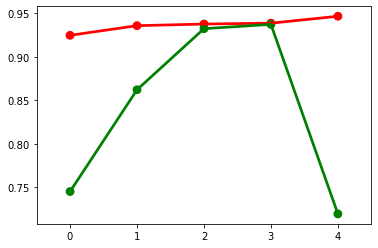

In [252]:
cv_res = cross_validate(cl, X_train[check_features], y_train, scoring= 'r2', n_jobs = -1, cv = cv_splitter, return_train_score = True, verbose = 0)

sns.pointplot(np.arange(n), cv_res['train_score'], color = 'r')
sns.pointplot(np.arange(n), cv_res['test_score'], color = 'g')
plt.show()

In [253]:
cl.fit(X_train[check_features], y_train)
imp = pd.Series(data = cl.feature_importances_, index = check_features)
imp.sort_values(ascending=False).head(10)

not_full_mkb_code                                 82
patient_id_count_litera_mkb_code_count_shift_0    43
patient_id_count_litera_mkb_code_count_max_12     35
patient_id_count_litera_mkb_code_shift_1          25
patient_id_count_litera_mkb_code_min_12           22
patient_id_count_litera_mkb_code_shift_6          21
patient_id_count_litera_mkb_code_count_min_12     18
patient_id_count_litera_mkb_code_growth_6         18
patient_id_count_litera_mkb_code_count_mean_12    17
patient_id_count_litera_mkb_code_shift_12         16
dtype: int32

#### RF

In [254]:
fs_method = 'rf'

rf = RandomForestRegressor(
    n_jobs = -1, 
    random_state = random_state, 
    max_depth=max_depth_rf, 
    n_estimators = n_estimators_rf,
    min_samples_leaf=min_samples_leaf)

temp_features = check_features

for p in ps:

    rf.fit(X_train[temp_features], y_train)

    imp = pd.Series(data = rf.feature_importances_, index = temp_features)

    number_of_feats = len(temp_features)
    h = int(number_of_feats * step)

    temp_features = imp.sort_values().iloc[h:].index
    print (len(temp_features))

    cv_res = cross_validate(cl, X_train[temp_features], y_train, 
    scoring= 'r2', 
    #n_jobs = -1, 
    cv = cv_splitter, 
    return_train_score = True, verbose = 0)

    cv_train = (cv_res['train_score'] * k).sum()
    cv_test = (cv_res['test_score'].mean() * k).sum()

    metric_fs_cons_train_prehype2.loc[fs_method, p] = cv_train
    metric_fs_cons_test_prehype2.loc[fs_method, p] = cv_test

rf_feats = temp_features

114
92
74
60
48
39
32
26
21
17
14
12
10
8


#### LGBM (base)

In [255]:
fs_method = 'lgbm'

temp_features = check_features

for p in ps:

    cl.fit(X_train[temp_features], y_train)

    imp = pd.Series(data = cl.feature_importances_, index = temp_features)

    number_of_feats = len(temp_features)
    h = int(number_of_feats * step)

    temp_features = imp.sort_values().iloc[h:].index
    print (len(temp_features))

    cv_res = cross_validate(cl, X_train[temp_features], y_train, 
    scoring= 'r2', n_jobs = -1, cv = cv_splitter, 
    return_train_score = True, verbose = 0)

    cv_train = (cv_res['train_score'] * k).sum()
    cv_test = (cv_res['test_score'].mean() * k).sum()

    metric_fs_cons_train_prehype2.loc[fs_method, p] = cv_train
    metric_fs_cons_test_prehype2.loc[fs_method, p] = cv_test

lgbm_feats = temp_features

114
92
74
60
48
39
32
26
21
17
14
12
10
8


#### LGBM (gain)

In [256]:
fs_method = 'lgbm_gain'

lg_gain = LGBMRegressor(
    n_jobs = -1, 
    min_child_samples= min_child_samples, 
    max_depth = max_depth, 
    importance_type = 'gain', 
    random_state=random_state,
    learning_rate=learning_rate)

temp_features = check_features

for p in ps:

    lg_gain.fit(X_train[temp_features], y_train)

    imp = pd.Series(data = lg_gain.feature_importances_, index = temp_features)

    number_of_feats = len(temp_features)
    h = int(number_of_feats * step)

    temp_features = imp.sort_values().iloc[h:].index
    print (len(temp_features))

    cv_res = cross_validate(cl, X_train[temp_features], y_train, 
    scoring= 'r2', n_jobs = -1, cv = cv_splitter, 
    return_train_score = True, verbose = 0)

    cv_train = (cv_res['train_score'] * k).sum()
    cv_test = (cv_res['test_score'].mean() * k).sum()

    metric_fs_cons_train_prehype2.loc[fs_method, p] = cv_train
    metric_fs_cons_test_prehype2.loc[fs_method, p] = cv_test

lgbm_gain_feats = temp_features

114
92
74
60
48
39
32
26
21
17
14
12
10
8


#### Permutation

In [257]:
fs_method = 'permut'

temp_features = check_features

for p in ps:

    cl.fit(X_train[temp_features], y_train)
    res = permutation_importance(cl, X_train[temp_features], y_train, n_repeats= 5, 
    #n_jobs = -1, 
    random_state=random_state)
    imp = pd.Series(data = res.importances_mean, index = temp_features)
    
    number_of_feats = len(temp_features)
    h = int(number_of_feats * step) 

    temp_features = imp.sort_values().iloc[h:].index
    print (len(temp_features))

    cv_res = cross_validate(cl, X_train[temp_features], y_train, 
    scoring= 'r2', n_jobs = -1, cv = cv_splitter, 
    return_train_score = True, verbose = 0)

    cv_train = (cv_res['train_score'] * k).sum()
    cv_test = (cv_res['test_score'].mean() * k).sum()

    metric_fs_cons_train_prehype2.loc[fs_method, p] = cv_train
    metric_fs_cons_test_prehype2.loc[fs_method, p] = cv_test

perm_feats = temp_features

114
92
74
60
48
39
32
26
21
17
14
12
10
8


#### Resume

In [258]:
metric_fs_cons_test_prehype2

1         2         3         4         5         6   \
rf         0.840598  0.835667  0.837679  0.842747  0.846585  0.839162   
lgbm       0.835759  0.837109  0.834690  0.847794  0.838428  0.842656   
lgbm_gain  0.828790  0.817859  0.837839  0.834416  0.826952  0.838089   
permut     0.831820  0.842549  0.831687  0.840380  0.852880  0.837840   

                 7         8         9         10        11        12  \
rf         0.846566  0.850545  0.877608  0.821921  0.847939  0.858186   
lgbm       0.834237  0.852698  0.863863  0.865498  0.857923  0.862292   
lgbm_gain  0.845318  0.840401  0.858295  0.855944  0.856398  0.870407   
permut     0.845318  0.860584  0.859023  0.875985  0.876476  0.866906   

                 13        14  
rf         0.849511  0.843041  
lgbm       0.875597  0.876384  
lgbm_gain  0.867605  0.869584  
permut     0.875597  0.868402

In [259]:
metric_fs_cons_dif_prehype2 = metric_fs_cons_train_prehype2 - metric_fs_cons_test_prehype2

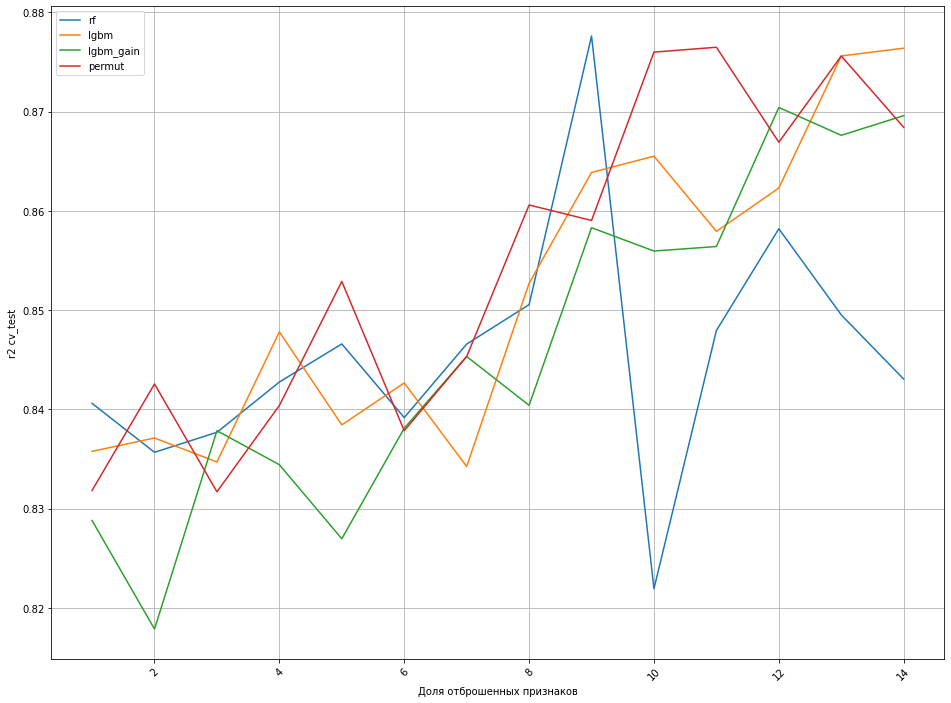

In [260]:
check_index = ['rf', 'lgbm','lgbm_gain','permut']
fig, ax = plt.subplots(figsize=(16, 12))
for i in check_index:
    ax.plot(np.array(metric_fs_cons_test_prehype2.columns), metric_fs_cons_test_prehype2.loc[i, :], label=i)
ax.legend()
ax.set_xlabel('Доля отброшенных признаков')
ax.set_ylabel('r2 cv_test')
ax.grid(True)
plt.xticks(rotation = 45)
plt.show()

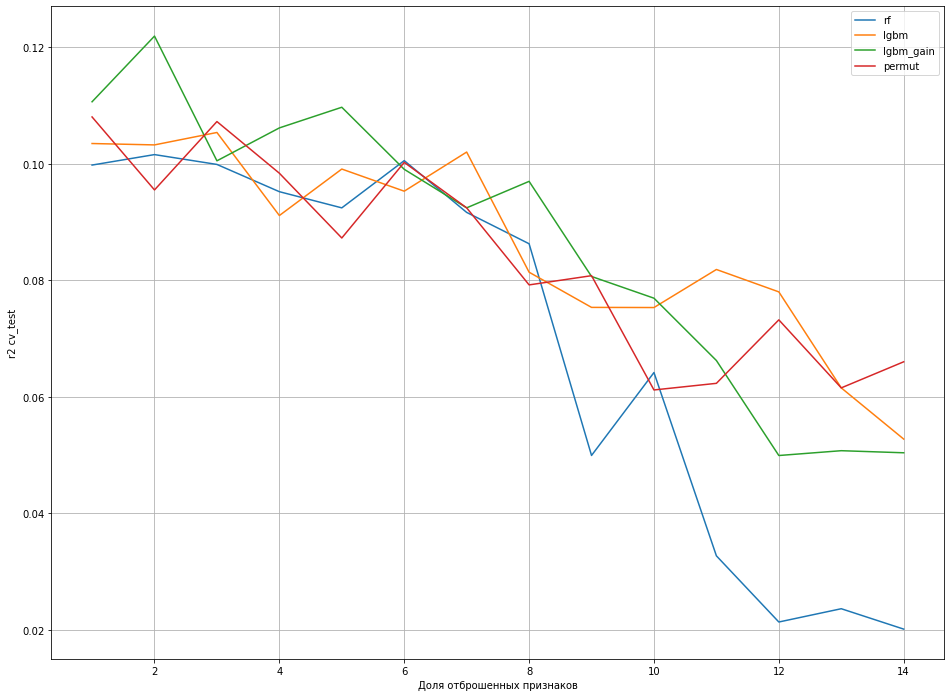

In [261]:
fig, ax = plt.subplots(figsize=(16, 12))
for i in check_index:
    ax.plot(metric_fs_cons_dif_prehype2.columns, metric_fs_cons_dif_prehype2.loc[i, :], label=i)
ax.legend()
ax.set_xlabel('Доля отброшенных признаков')
ax.set_ylabel('r2 cv_test')
ax.grid(True)
plt.show()

In [274]:
features_lgbm_mkb1 = lgbm_feats
features_lgbm_mkb1

Index(['patient_id_count_litera_mkb_code_growth_6',
       'patient_id_count_litera_mkb_code_mean_12',
       'patient_id_count_litera_mkb_code_count_mean_12',
       'patient_id_count_litera_mkb_code_shift_6',
       'patient_id_count_litera_mkb_code_shift_1',
       'patient_id_count_litera_mkb_code_count_max_12',
       'patient_id_count_litera_mkb_code_count_shift_0', 'not_full_mkb_code'],
      dtype='object')

Эти признаки мы оставим для итоговой модели.

In [275]:
# cl.fit(X_train[features_lgbm_mkb1], y_train)
# mkb_counts_predict = cl.predict(X_pred[features_lgbm_mkb1])

In [278]:
# mkb_df['patient_id_count_mkb1'] = mkb_df['patient_id_count']
# mkb_df.loc[mkb_df.time_series == 51, 'patient_id_count_mkb'] = mkb_counts_predict

In [ ]:
# fig, ax = plt.subplots(figsize = (16, 12))

# for point in mkb_df.litera_mkb_code.unique():
#     plt.plot(mkb_df[mkb_df.litera_mkb_code == point].time_series, mkb_df[mkb_df.litera_mkb_code == point].patient_id_count_mkb1, label = point)

# # plt.xticks(df.groupby('time_series').patient_id_count.sum().index, df['visit_month_year'].unique(), rotation=45)
# # plt.yscale('log')
# # plt.legend()
# plt.grid()
# plt.show()

In [ ]:
# area_df = area_df.rename(columns={'patient_id_count':'patient_id_count_area_lgbm'})
# df.merge(mkb_df[['time_series', 'patient_id_count_mkb1']], on = ['time_series', 'mkb_code'], how = 'left')

### RF. Последовательный отбор фичей

In [281]:
metric_fs_cons_train_prehype2 = pd.DataFrame()
metric_fs_cons_test_prehype2 = pd.DataFrame()

In [282]:
check_features = features

#### RF

In [283]:
rf

RandomForestRegressor(min_samples_leaf=16, n_jobs=-1, random_state=42)

In [284]:
fs_method = 'rf'

temp_features = check_features

for p in ps:

    rf.fit(X_train[temp_features], y_train)

    imp = pd.Series(data = rf.feature_importances_, index = temp_features)

    number_of_feats = len(temp_features)
    h = int(number_of_feats * step)

    temp_features = imp.sort_values().iloc[h:].index
    print (len(temp_features))

    cv_res = cross_validate(rf, X_train[temp_features], y_train, 
    scoring= 'r2', n_jobs = -1, cv = cv_splitter, 
    return_train_score = True, verbose = 0)

    cv_train = (cv_res['train_score'] * k).sum()
    cv_test = (cv_res['test_score'].mean() * k).sum()

    metric_fs_cons_train_prehype2.loc[fs_method, p] = cv_train
    metric_fs_cons_test_prehype2.loc[fs_method, p] = cv_test

rf_feats = temp_features

177
142
114
92
74
60
48
39
32
26
21
17
14
12


#### LGBM (base)

In [290]:
fs_method = 'lgbm'

temp_features = check_features

for p in ps:

    cl.fit(X_train[temp_features], y_train)

    imp = pd.Series(data = cl.feature_importances_, index = temp_features)

    number_of_feats = len(temp_features)
    h = int(number_of_feats * step)

    temp_features = imp.sort_values().iloc[h:].index
    print (len(temp_features))

    cv_res = cross_validate(rf, X_train[temp_features], y_train, 
    scoring= 'r2', n_jobs = -1, cv = cv_splitter, 
    return_train_score = True, verbose = 0)

    cv_train = (cv_res['train_score'] * k).sum()
    cv_test = (cv_res['test_score'].mean() * k).sum()

    metric_fs_cons_train_prehype2.loc[fs_method, p] = cv_train
    metric_fs_cons_test_prehype2.loc[fs_method, p] = cv_test

lgbm_feats = temp_features

177
142
114
92
74
60
48
39
32
26
21
17
14
12


#### LGBM (gain)

In [292]:
fs_method = 'lgbm_gain'

lg_gain = LGBMRegressor(
    n_jobs = -1, 
    min_child_samples= min_child_samples, 
    max_depth = max_depth, 
    importance_type = 'gain', 
    random_state=random_state,
    learning_rate=learning_rate)

temp_features = check_features

for p in ps:

    lg_gain.fit(X_train[temp_features], y_train)

    imp = pd.Series(data = lg_gain.feature_importances_, index = temp_features)

    number_of_feats = len(temp_features)
    h = int(number_of_feats * step)

    temp_features = imp.sort_values().iloc[h:].index
    print (len(temp_features))

    cv_res = cross_validate(rf, X_train[temp_features], y_train, 
    scoring= 'r2', n_jobs = -1, cv = cv_splitter, 
    return_train_score = True, verbose = 0)

    cv_train = (cv_res['train_score'] * k).sum()
    cv_test = (cv_res['test_score'].mean() * k).sum()

    metric_fs_cons_train_prehype2.loc[fs_method, p] = cv_train
    metric_fs_cons_test_prehype2.loc[fs_method, p] = cv_test

lgbm_gain_feats = temp_features

177
142
114
92
74
60
48
39
32
26
21
17
14
12


#### Permutation

In [287]:
fs_method = 'permut'

temp_features = check_features

for p in ps:

    rf.fit(X_train[temp_features], y_train)
    res = permutation_importance(rf, X_train[temp_features], y_train, n_repeats= 5, n_jobs = -1, random_state=random_state)
    imp = pd.Series(data = res.importances_mean, index = temp_features)
    
    number_of_feats = len(temp_features)
    h = int(number_of_feats * step)

    temp_features = imp.sort_values().iloc[h:].index
    print (len(temp_features))

    cv_res = cross_validate(rf, X_train[temp_features], y_train, 
    scoring= 'r2', n_jobs = -1, cv = cv_splitter, 
    return_train_score = True, verbose = 0)

    cv_train = (cv_res['train_score'] * k).sum()
    cv_test = (cv_res['test_score'].mean() * k).sum()

    metric_fs_cons_train_prehype2.loc[fs_method, p] = cv_train
    metric_fs_cons_test_prehype2.loc[fs_method, p] = cv_test

perm_feats = temp_features

177
142
114
92
74
60
48
39
32
26
21
17
14
12


#### Resume

In [293]:
metric_fs_cons_test_prehype2

1         2         3         4         5         6   \
rf         0.790142  0.791198  0.790451  0.790603  0.790565  0.790956   
lgbm       0.790053  0.790850  0.790106  0.790903  0.791703  0.791573   
lgbm_gain  0.791773  0.791266  0.791178  0.791794  0.790938  0.791196   
permut     0.790408  0.791530  0.790626  0.790478  0.790736  0.790199   

                 7         8         9         10        11        12  \
rf         0.791732  0.790522  0.790906  0.791488  0.791132  0.791199   
lgbm       0.792217  0.794014  0.795535  0.794041  0.810259  0.811945   
lgbm_gain  0.791020  0.793346  0.792465  0.799599  0.799688  0.801347   
permut     0.790276  0.790842  0.792163  0.791148  0.792306  0.791875   

                 13        14  
rf         0.792485  0.793476  
lgbm       0.812048  0.811329  
lgbm_gain  0.802619  0.804289  
permut     0.792499  0.791854

In [294]:
metric_fs_cons_dif_prehype2

1         2         3         4         5         6   \
rf         0.099785  0.101583  0.099893  0.095215  0.092437  0.100547   
lgbm       0.103484  0.103246  0.105380  0.091120  0.099102  0.095300   
lgbm_gain  0.110651  0.121926  0.100514  0.106164  0.109710  0.099055   
permut     0.108047  0.095515  0.107253  0.098386  0.087265  0.100248   

                 7         8         9         10        11        12  \
rf         0.091658  0.086275  0.049929  0.064168  0.032697  0.021336   
lgbm       0.102020  0.081390  0.075351  0.075325  0.081858  0.078012   
lgbm_gain  0.092440  0.096988  0.080659  0.076930  0.066230  0.049920   
permut     0.092440  0.079211  0.080795  0.061174  0.062312  0.073211   

                 13        14  
rf         0.023616  0.020115  
lgbm       0.061532  0.052740  
lgbm_gain  0.050746  0.050388  
permut     0.061532  0.066011

In [295]:
metric_fs_cons_dif_prehype2 = metric_fs_cons_train_prehype2 - metric_fs_cons_test_prehype2

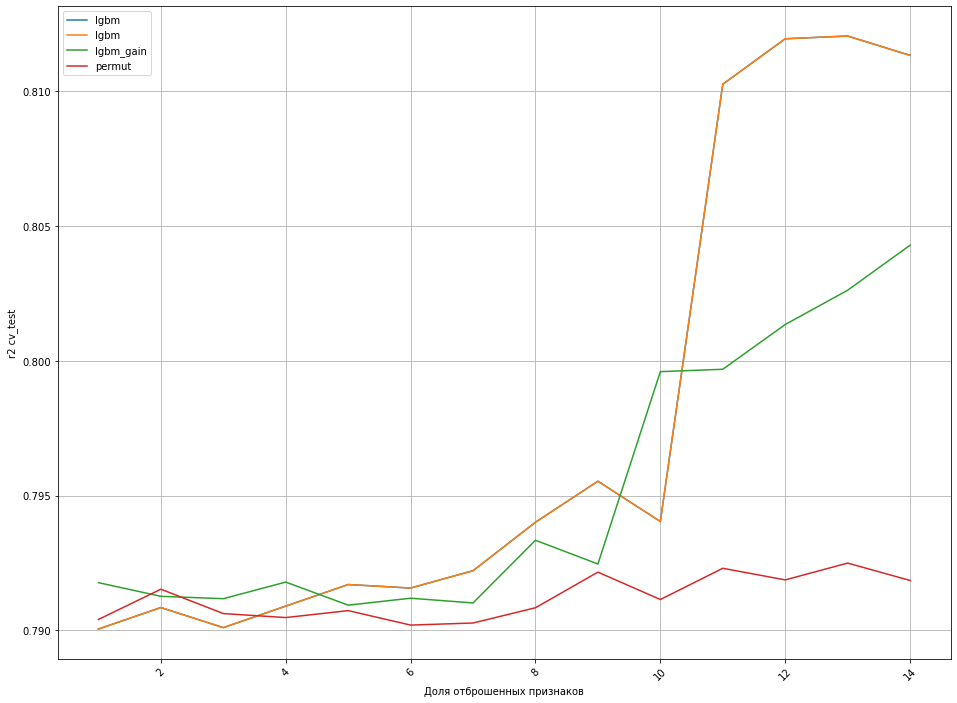

In [297]:
check_index = ['lgbm', 'lgbm','lgbm_gain','permut']
fig, ax = plt.subplots(figsize=(16, 12))
for i in check_index:
    ax.plot(np.array(metric_fs_cons_test_prehype2.columns), metric_fs_cons_test_prehype2.loc[i, :], label=i)
ax.legend()
ax.set_xlabel('Доля отброшенных признаков')
ax.set_ylabel('r2 cv_test')
ax.grid(True)
plt.xticks(rotation = 45)
plt.show()

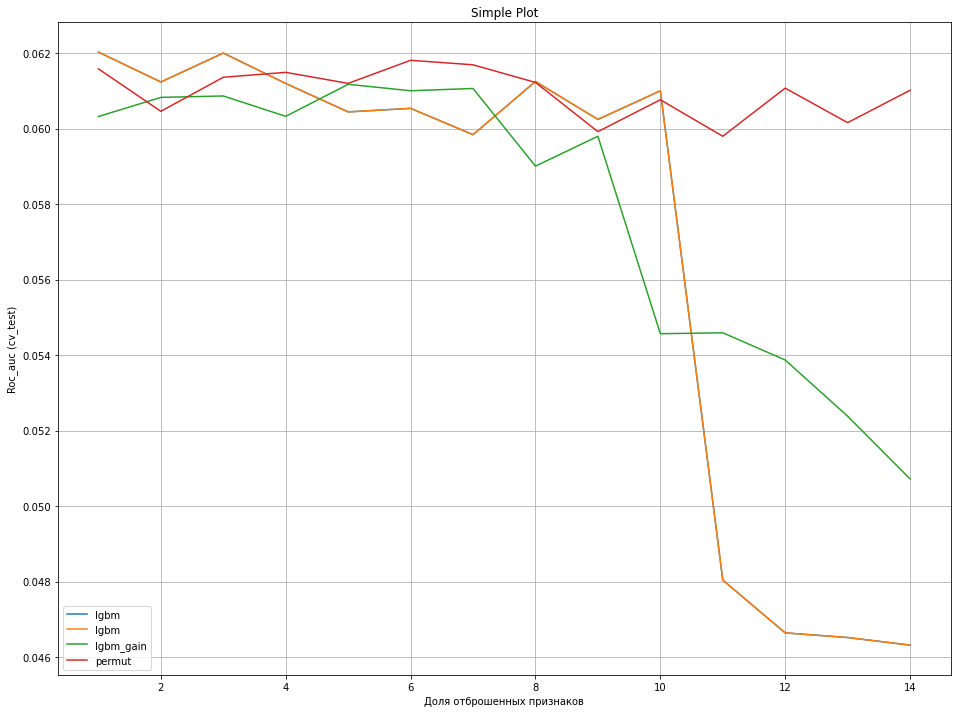

In [298]:
fig, ax = plt.subplots(figsize=(16, 12))
for i in check_index:
    ax.plot(metric_fs_cons_dif_prehype2.columns, metric_fs_cons_dif_prehype2.loc[i, :], label=i)
ax.legend()
plt.title("Simple Plot")
ax.set_xlabel('Доля отброшенных признаков')
ax.set_ylabel('Roc_auc (cv_test)')
ax.grid(True)
plt.show()

In [308]:
features_rf_mkb1 = lgbm_feats
features_rf_mkb1

Index(['patient_id_count_litera_mkb_code_count_growth_1',
       'patient_id_count_litera_mkb_code_count_growth_12',
       'patient_id_count_count_shift_0',
       'patient_id_count_litera_mkb_code_min_12',
       'patient_id_count_litera_mkb_code_count_mean_3',
       'patient_id_count_litera_mkb_code_count_min_3', 'deaths_Россия',
       'patient_id_count_litera_mkb_code_growth_6',
       'patient_id_count_litera_mkb_code_count_min_12',
       'patient_id_count_litera_mkb_code_count_max_12',
       'patient_id_count_litera_mkb_code_shift_6',
       'patient_id_count_litera_mkb_code_shift_12',
       'patient_id_count_litera_mkb_code_mean_12',
       'patient_id_count_litera_mkb_code_growth_12',
       'patient_id_count_litera_mkb_code_shift_1', 'not_full_mkb_code',
       'patient_id_count_litera_mkb_code_count_shift_0'],
      dtype='object')

Эти признаки мы оставим для итоговой модели.

# Формирование признаков для обучения

Соберём воедино все признаки: общие признаки, признаки по городу, признаки по полу и позрасту, признаки по первой букве кода, мета фичи

In [92]:
new_feats = list(set(['patient_id_count_area_count_shift_0', 'patient_id_count_area_growth_3',
       'patient_id_count_count_shift_0', 'patient_id_count_area_growth_12',
       'patient_id_count_area_shift_1', 'patient_id_count_area_shift_6',
       'patient_id_count_area_count_mean_3', 'patient_id_count_area_min_3',
       'patient_id_count_area_shift_12'] + ['Запросов_на_млн_вызвать_скорую_shift_1',
       'patient_id_count_patient_sex_min_3',
       'Запросов_на_млн_купить_маску_и_респиратор_growth_1', 'time_series',
       'patient_id_count_patient_sex_shift_6', 'patient_id_count_shift_1',
       'Запросов_на_млн_вызвать_скорую_growth_12',
       'patient_id_count_patient_sex_count_shift_6',
       'patient_id_count_patient_sex_mean_3',
       'Запросов_на_млн_купить_маску_и_респиратор_shift_12',
       'Запросов_на_млн_симптомы_коронавируса_shift_12',
       'Запросов_на_млн_как_не_заразиться_mean_3',
       'patient_id_count_patient_sex_count_shift_1',
       'patient_id_count_shift_12', 'patient_id_count_growth_12',
       'patient_id_count_patient_sex_growth_12',
       'patient_id_count_patient_sex_shift_12', 'patient_id_count_growth_6',
       'patient_id_count_shift_6', 'patient_id_count_count_mean_12',
       'patient_id_count_patient_sex_shift_1',
       'patient_id_count_count_shift_0', 'area_Гурьевск',
       'patient_id_count_patient_sex_growth%_12', 'area_Калининград',
       'popul_cf', 'popul_log_cf',
       'patient_id_count_patient_sex_count_shift_0', 'area_vc'] + 
       ['patient_id_count_age_category_count_shift_6',
       'patient_id_count_patient_sex_mean_3',
       'Запросов_на_млн_что_делать_дома',
       'patient_id_count_age_category_growth%_1',
       'patient_id_count_age_category_growth_3', 'deaths_Москва',
       'patient_id_count_age_category_min_3',
       'Запросов_на_млн_вызвать_скорую_shift_3',
       'patient_id_count_patient_sex_shift_12',
       'Запросов_на_млн_купить_маску_и_респиратор',
       'patient_id_count_age_category_count_growth_1',
       'patient_id_count_age_category_count_max_12',
       'patient_id_count_age_category_mean_6', 'age_category_vc',
       'deaths_США_shift_6', 'patient_id_count_age_category_count_shift_1',
       'Запросов_на_млн_купить_маску_и_респиратор_growth_3',
       'patient_id_count_mean_12',
       'patient_id_count_age_category_count_min_12',
       'patient_id_count_age_category_mean_12',
       'patient_id_count_age_category_growth_6',
       'patient_id_count_patient_sex_count_mean_12',
       'patient_id_count_age_category_shift_12',
       'patient_id_count_age_category_mean_3',
       'patient_id_count_age_category_max_6',
       'patient_id_count_patient_sex_count_shift_0',
       'Запросов_на_млн_симптомы_коронавируса_shift_12',
       'patient_id_count_age_category_count_shift_0',
       'patient_id_count_count_shift_0', 'age_category_patient_sex_count',
       'patient_id_count_age_category_shift_1',
       'age_category_patient_sex_sum'] + 
       ['patient_id_count_age_category_growth_12',
       'Запросов_на_млн_купить_маску_и_респиратор_shift_12',
       'Запросов_на_млн_что_делать_дома',
       'Запросов_на_млн_симптомы_коронавируса_shift_12',
       'patient_id_count_age_category_mean_3',
       'patient_id_count_patient_sex_count_shift_0',
       'patient_id_count_age_category_max_3', 'age_category_young',
       'patient_id_count_age_category_shift_12',
       'patient_id_count_age_category_count_shift_0',
       'age_category_patient_sex_count', 'patient_id_count_count_shift_0',
       'patient_id_count_age_category_shift_1',
       'age_category_patient_sex_sum'] + ['patient_id_count_litera_mkb_code_growth_6',
       'patient_id_count_litera_mkb_code_mean_12',
       'patient_id_count_litera_mkb_code_count_mean_12',
       'patient_id_count_litera_mkb_code_shift_6',
       'patient_id_count_litera_mkb_code_shift_1',
       'patient_id_count_litera_mkb_code_count_max_12',
       'patient_id_count_litera_mkb_code_count_shift_0', 'not_full_mkb_code'] + 
       ['patient_id_count_litera_mkb_code_count_growth_1',
       'patient_id_count_litera_mkb_code_count_growth_12',
       'patient_id_count_count_shift_0',
       'patient_id_count_litera_mkb_code_min_12',
       'patient_id_count_litera_mkb_code_count_mean_3',
       'patient_id_count_litera_mkb_code_count_min_3', 'deaths_Россия',
       'patient_id_count_litera_mkb_code_growth_6',
       'patient_id_count_litera_mkb_code_count_min_12',
       'patient_id_count_litera_mkb_code_count_max_12',
       'patient_id_count_litera_mkb_code_shift_6',
       'patient_id_count_litera_mkb_code_shift_12',
       'patient_id_count_litera_mkb_code_mean_12',
       'patient_id_count_litera_mkb_code_growth_12',
       'patient_id_count_litera_mkb_code_shift_1', 'not_full_mkb_code',
       'patient_id_count_litera_mkb_code_count_shift_0']))

In [351]:
# используем мета признаки
df['mean_id_count_area'] = df['patient_id_count_area_lgbm'] / df['patient_id_count_area_count_shift_0']
df['mean_id_count_sex_age_1'] = df['patient_id_count_sex_age_lgbm'] / df['patient_id_count_age_category_count_shift_0']
df['mean_id_count_sex_age_2'] = df['patient_id_count_sex_age_lgbm'] / df['patient_id_count_patient_sex_count_shift_0']

meta_feats = ['mean_id_count_area', 'mean_id_count_sex_age_1','mean_id_count_sex_age_2','patient_id_count_area_lgbm','patient_id_count_sex_age_lgbm']

base_feats = list(df.loc[:10, 'area_age_category_count' : 'litera_mkb_code_litera_2nums_mkb_code_sum_norm'].columns)

In [4]:
features = set( new_feats + meta_feats + base_feats +
['mkb_code_vc', 'litera_2nums_mkb_code_vc', 'litera_mkb_code_vc',
       'age_category_vc', 'area_vc'] +

['area', 'age_category', 'patient_sex', 'mkb_code',
       'test', 'patient_id_count', 'time_series', 'litera_mkb_code', 'litera_2nums_mkb_code']
       )

In [368]:
new_df = df[set(df.columns).intersection(features)]

In [2]:
# new_df.to_csv('predict_data_26.08.csv', index = False)
# new_df = pd.read_csv('predict_data_26.08.csv')

# Предподготовка данных под обучение

In [3]:
bt = new_df.sort_values(by = ['test', 'time_series'])

In [4]:
#избавимся от пропусков в признаках
features = bt.columns.drop(['test','patient_id_count', 'mkb_code', 'litera_2nums_mkb_code', 'age_category','patient_sex','area', 'litera_2nums_mkb_code', 'litera_mkb_code', 'area']) # + 'litera_mkb_code'
bt.drop(bt[features].isna().sum()[bt[features].isna().sum().sort_values() > 0].index, axis = 1, inplace = True)
features = bt.columns.drop(['test','patient_id_count', 'mkb_code', 'litera_2nums_mkb_code', 'age_category','patient_sex','area', 'litera_2nums_mkb_code', 'litera_mkb_code', 'area'])
bt.shape

(1301733, 145)

In [5]:
# логарифмируем таргет
bt['patient_id_count'] = np.log(bt['patient_id_count'])

In [6]:
# стандартизируем признаки
scl = StandardScaler()
bt[features[:80]] = scl.fit_transform(bt[features[:80]])
bt[features[80:]] = scl.fit_transform(bt[features[80:]])

In [7]:
# делим на обучение и данные под предикт
X_train = bt[bt.test == -1][features]
y_train = bt.loc[bt.test == -1, ['patient_id_count']]

X_sub = bt[bt.test > -1][features]

# Второе и третье признаковое пространство под предикт

features - наше первое признаковое пространство.  
Сформируем ещё два. Одно создадим отбором при помощи LGBM, а второе при помощи LGBM с параметром importance_type = 'gain'  
Для этого немного подкрутим параметры, чтобы модель лучше различала важность признаков.

In [8]:
len(X_sub)

39353

In [9]:
random_state = 42
n = 4
ps = range(1, 15)
cv_splitter = TimeSeriesSplit(n_splits=n, test_size = 40000)
step = 0.2
k = np.array([0.1, 0.2, 0.3, 0.4])

In [10]:
check_features = features

0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=20. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=20. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=20. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=20. Current value: min_data_in_leaf=20
0.7409568358305143


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   51.2s finished


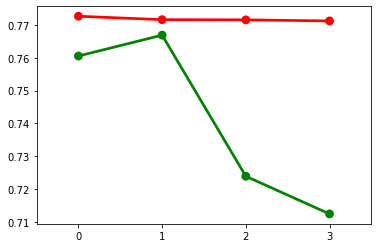

1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=80. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=80. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=80. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=80. Current value: min_data_in_leaf=80
0.739172185473915


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   49.4s finished


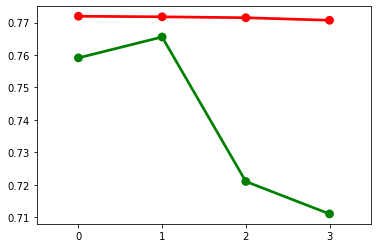

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


2
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=20. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=20. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=20. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=20. Current value: min_data_in_leaf=20
0.756857393408007


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   57.3s finished


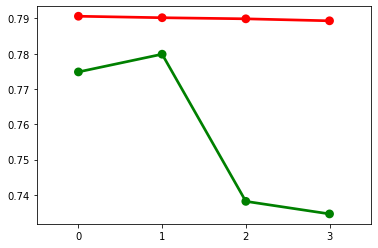

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


3
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=80. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=80. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=80. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=80. Current value: min_data_in_leaf=80
0.7575293515199805


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   54.1s finished


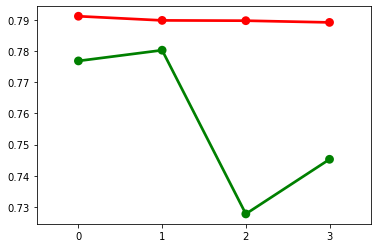

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


4
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=20. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=20. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=20. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=20. Current value: min_data_in_leaf=20
0.7589575112844298


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   53.0s finished


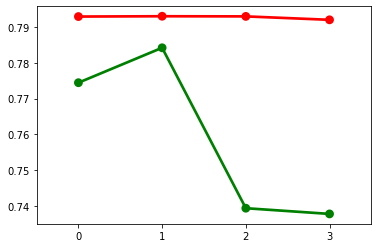

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


5
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=80. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=80. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=80. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=80. Current value: min_data_in_leaf=80
0.761466174993052


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   53.5s finished


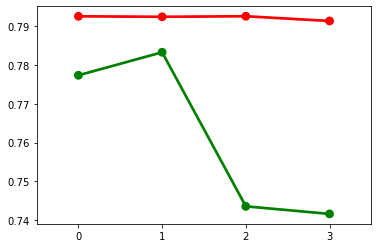

6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=20. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=20. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=20. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=20. Current value: min_data_in_leaf=20
0.7560657055539668


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   56.6s finished


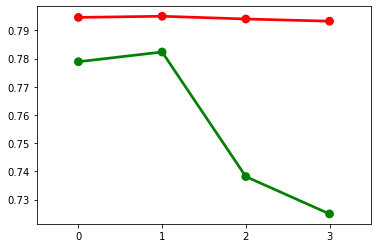

7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=80. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=80. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=80. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=80. Current value: min_data_in_leaf=80
0.7589983573772154


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   54.6s finished


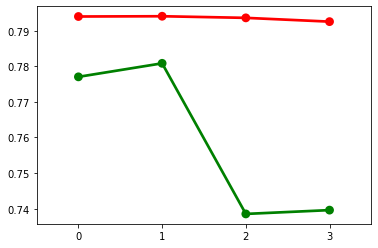

In [15]:
metric_table = pd.DataFrame()

i = 0

for max_depth in [4, 6, 8, -1]:
    for min_samples_leaf in [20, 80]:
        for n_estimators in [100]:
            for learning_rate in [0.3]:
                print (i)

                cl = LGBMRegressor(
                    n_jobs = -1, 
                    max_depth = max_depth, 
                    random_state=random_state, 
                    min_samples_leaf=min_samples_leaf,
                    learning_rate = learning_rate,
                    n_estimators=n_estimators)
                
                cv_res = cross_validate(cl, X_train[check_features], y_train, scoring= 'r2', cv = cv_splitter, return_train_score = True, verbose = 1, #n_jobs=-1
                )

                cv_train = (cv_res['train_score'].mean() * k).sum()
                cv_test = (cv_res['test_score'].mean() * k).sum()
                
                metric_table.loc[i, 'max_depth'] = max_depth
                metric_table.loc[i, 'min_samples_leaf'] = min_samples_leaf
                metric_table.loc[i, 'n_estimators'] = n_estimators
                metric_table.loc[i, 'learning_rate'] = learning_rate
                
                metric_table.loc[i, 'cv_train'] = cv_train
                metric_table.loc[i, 'cv_test'] = cv_test

                print (cv_test)

                sns.pointplot(np.arange(n), cv_res['train_score'], color = 'r')
                sns.pointplot(np.arange(n), cv_res['test_score'], color = 'g')
                plt.show()

                i +=1
                    
metric_table['cv_dif'] = metric_table['cv_train'] - metric_table['cv_test']

In [16]:
metric_table.sort_values(by = 'cv_test', ascending = False)

max_depth  min_samples_leaf  n_estimators  learning_rate  cv_train  \
5        8.0              80.0         100.0            0.3  0.792293   
7       -1.0              80.0         100.0            0.3  0.793541   
4        8.0              20.0         100.0            0.3  0.792692   
3        6.0              80.0         100.0            0.3  0.789939   
2        6.0              20.0         100.0            0.3  0.790016   
6       -1.0              20.0         100.0            0.3  0.794199   
0        4.0              20.0         100.0            0.3  0.771754   
1        4.0              80.0         100.0            0.3  0.771469   

    cv_test    cv_dif  
5  0.761466  0.030827  
7  0.758998  0.034543  
4  0.758958  0.033735  
3  0.757529  0.032409  
2  0.756857  0.033159  
6  0.756066  0.038133  
0  0.740957  0.030797  
1  0.739172  0.032297

In [11]:
min_child_samples = 80
learning_rate = 0.3
max_depth = 8

cl = LGBMRegressor(
    n_jobs = -1, 
    min_child_samples= min_child_samples, 
    max_depth = max_depth, 
    random_state=random_state,
    learning_rate=learning_rate)

In [18]:
cl.fit(X_train[check_features], y_train)
imp = pd.Series(data = cl.feature_importances_, index = check_features)
imp.sort_values(ascending=False).head(10)

area_mkb_code_sum                       248
age_category_mkb_code_sum               180
area_mkb_code_count                     147
mkb_code_litera_2nums_mkb_code_count    128
mkb_code_litera_mkb_code_sum            103
area_mkb_code_sum_norm                   91
age_category_mkb_code_sum_norm           91
patient_sex_mkb_code_sum_norm            68
age_category_mkb_code_count              66
area_mkb_code_count_norm                 62
dtype: int32

In [12]:
metric_fs_cons_train_prehype2 = pd.DataFrame()
metric_fs_cons_test_prehype2 = pd.DataFrame()

In [13]:
fs_method = 'lgbm'

temp_features = check_features

for p in ps:

    cl.fit(X_train[temp_features], y_train)

    imp = pd.Series(data = cl.feature_importances_, index = temp_features)

    number_of_feats = len(temp_features)
    h = int(number_of_feats * step)

    temp_features = imp.sort_values().iloc[h:].index
    print (len(temp_features))

    cv_res = cross_validate(cl, X_train[temp_features], y_train, 
    scoring= 'r2', #n_jobs = -1, 
    cv = cv_splitter, 
    return_train_score = True, verbose = 0)

    cv_train = (cv_res['train_score'] * k).sum()
    cv_test = (cv_res['test_score'].mean() * k).sum()

    metric_fs_cons_train_prehype2.loc[fs_method, p] = cv_train
    metric_fs_cons_test_prehype2.loc[fs_method, p] = cv_test

lgbm_gain_feats = temp_features

110
88
71
57
46
37
30
24
20
16
13
11
9
8


In [14]:
metric_fs_cons_test_prehype2

1        2         3         4         5        6         7   \
lgbm  0.76041  0.75705  0.756825  0.759948  0.759947  0.75875  0.758661   

            8         9        10        11        12        13        14  
lgbm  0.758152  0.757639  0.75757  0.757317  0.754359  0.740077  0.741168

In [15]:
metric_fs_cons_dif_prehype2 = metric_fs_cons_train_prehype2 - metric_fs_cons_test_prehype2
metric_fs_cons_dif_prehype2

1         2         3         4         5         6        7   \
lgbm  0.031559  0.035497  0.035712  0.031133  0.031156  0.032021  0.03228   

            8         9         10        11        12        13        14  
lgbm  0.028798  0.028273  0.027452  0.025856  0.026995  0.037786  0.035989

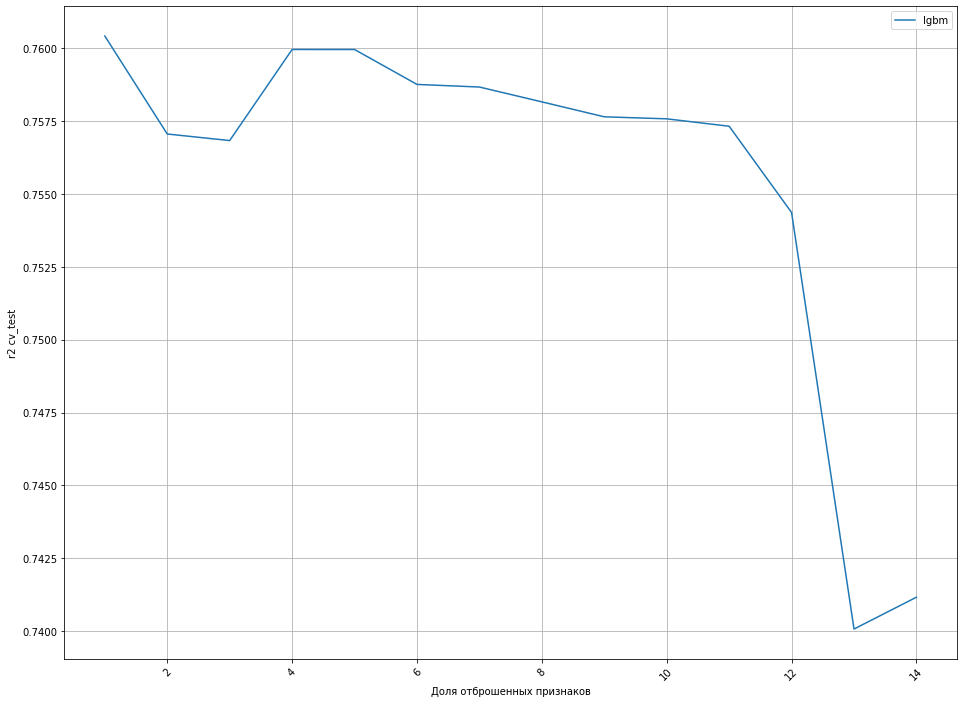

In [16]:
check_index = ['lgbm',# 'lgbm',
# 'lgbm_gain',
#'permut'
]
fig, ax = plt.subplots(figsize=(16, 12))
for i in check_index:
    ax.plot(np.array(metric_fs_cons_test_prehype2.columns), metric_fs_cons_test_prehype2.loc[i, :], label=i)
ax.legend()
ax.set_xlabel('Доля отброшенных признаков')
ax.set_ylabel('r2 cv_test')
ax.grid(True)
plt.xticks(rotation = 45)
plt.show()

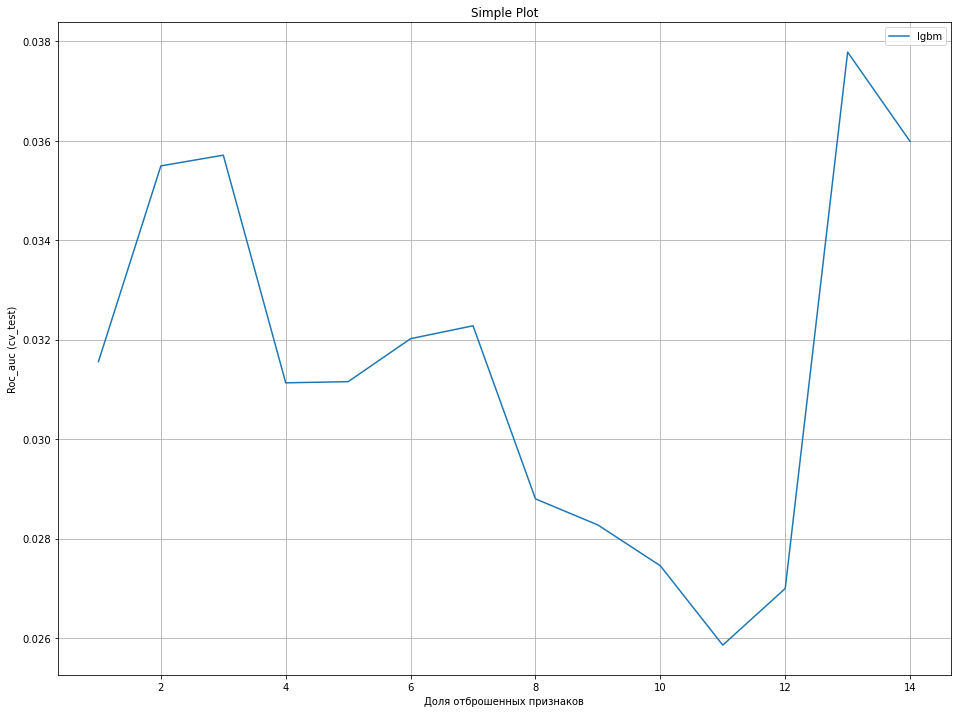

In [17]:
fig, ax = plt.subplots(figsize=(16, 12))
for i in check_index:
    ax.plot(metric_fs_cons_dif_prehype2.columns, metric_fs_cons_dif_prehype2.loc[i, :], label=i)
ax.legend()
plt.title("Simple Plot")
ax.set_xlabel('Доля отброшенных признаков')
ax.set_ylabel('Roc_auc (cv_test)')
ax.grid(True)
plt.show()

In [21]:
fs_method = 'lgbm'

temp_features = check_features

for p in range(1, 12):

    cl.fit(X_train[temp_features], y_train)

    imp = pd.Series(data = cl.feature_importances_, index = temp_features)

    number_of_feats = len(temp_features)
    h = int(number_of_feats * step)

    temp_features = imp.sort_values().iloc[h:].index
    print (len(temp_features))

    cv_res = cross_validate(cl, X_train[temp_features], y_train, 
    scoring= 'r2', #n_jobs = -1, 
    cv = cv_splitter, 
    return_train_score = True, verbose = 0)

    cv_train = (cv_res['train_score'] * k).sum()
    cv_test = (cv_res['test_score'].mean() * k).sum()

    metric_fs_cons_train_prehype2.loc[fs_method, p] = cv_train
    metric_fs_cons_test_prehype2.loc[fs_method, p] = cv_test

lgbm_gain_feats = temp_features

110
88
71
57
46
37
30
24
20
16
13


In [22]:
final_feats_log = lgbm_gain_feats
final_feats_log

Index(['age_category_mkb_code_sum_norm', 'area_litera_2nums_mkb_code_sum',
       'area_age_category_sum_norm', 'patient_id_count_area_count_shift_0',
       'area_mkb_code_sum_norm', 'mkb_code_litera_2nums_mkb_code_count',
       'patient_id_count_litera_mkb_code_mean_12', 'time_series',
       'age_category_mkb_code_sum', 'mkb_code_litera_mkb_code_sum',
       'area_mkb_code_count', 'area_mkb_code_sum', 'patient_sex_mkb_code_sum'],
      dtype='object')

Мы получили второе признаковое пространство.   
Далее получим третье.

In [50]:
cl

LGBMRegressor(learning_rate=0.3, max_depth=8, min_child_samples=80,
              random_state=42)

In [51]:
fs_method = 'lgbm_gain'

lg_gain = LGBMRegressor(
    n_jobs = -1, 
    min_child_samples= min_child_samples, 
    max_depth = max_depth, 
    importance_type = 'gain', 
    random_state=random_state,
    learning_rate=learning_rate)

temp_features = check_features

for p in ps:

    lg_gain.fit(X_train[temp_features], y_train)

    imp = pd.Series(data = lg_gain.feature_importances_, index = temp_features)

    number_of_feats = len(temp_features)
    h = int(number_of_feats * step)

    temp_features = imp.sort_values().iloc[h:].index
    print (len(temp_features))

    cv_res = cross_validate(cl, X_train[temp_features], y_train, 
    scoring= 'r2', #n_jobs = -1, 
    cv = cv_splitter, 
    return_train_score = True, verbose = 0)

    cv_train = (cv_res['train_score'] * k).sum()
    cv_test = (cv_res['test_score'].mean() * k).sum()

    metric_fs_cons_train_prehype2.loc[fs_method, p] = cv_train
    metric_fs_cons_test_prehype2.loc[fs_method, p] = cv_test

lgbm_gain_feats = temp_features

110
88
71
57
46
37
30
24
20
16
13
11
9
8


In [52]:
metric_fs_cons_test_prehype2

1         2         3         4         5         6   \
lgbm       0.76041  0.757050  0.756825  0.759948  0.759947  0.758750   
lgbm_gain  0.76133  0.762659  0.760295  0.759793  0.758243  0.761532   

                 7         8         9         10        11        12  \
lgbm       0.758661  0.758152  0.757639  0.757570  0.757317  0.754359   
lgbm_gain  0.764798  0.760865  0.759389  0.750339  0.746601  0.745494   

                 13        14  
lgbm       0.740077  0.741168  
lgbm_gain  0.743970  0.742354

In [53]:
metric_fs_cons_dif_prehype2 = metric_fs_cons_train_prehype2 - metric_fs_cons_test_prehype2
metric_fs_cons_dif_prehype2

1         2         3         4         5         6   \
lgbm       0.031559  0.035497  0.035712  0.031133  0.031156  0.032021   
lgbm_gain  0.030517  0.029590  0.031593  0.031989  0.032613  0.028738   

                 7         8         9         10        11        12  \
lgbm       0.032280  0.028798  0.028273  0.027452  0.025856  0.026995   
lgbm_gain  0.024336  0.026359  0.026635  0.028175  0.029643  0.029791   

                 13        14  
lgbm       0.037786  0.035989  
lgbm_gain  0.030523  0.028319

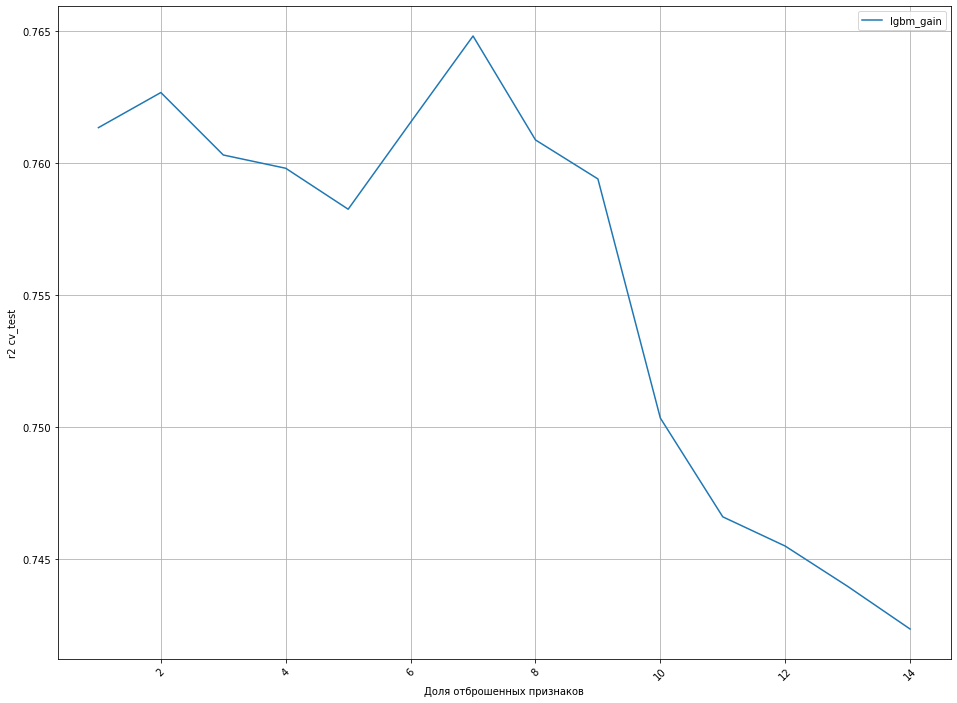

In [54]:
check_index = [#'lgbm', 'lgbm',
'lgbm_gain',
#'permut'
]
fig, ax = plt.subplots(figsize=(16, 12))
for i in check_index:
    ax.plot(np.array(metric_fs_cons_test_prehype2.columns), metric_fs_cons_test_prehype2.loc[i, :], label=i)
ax.legend()
ax.set_xlabel('Доля отброшенных признаков')
ax.set_ylabel('r2 cv_test')
ax.grid(True)
plt.xticks(rotation = 45)
plt.show()

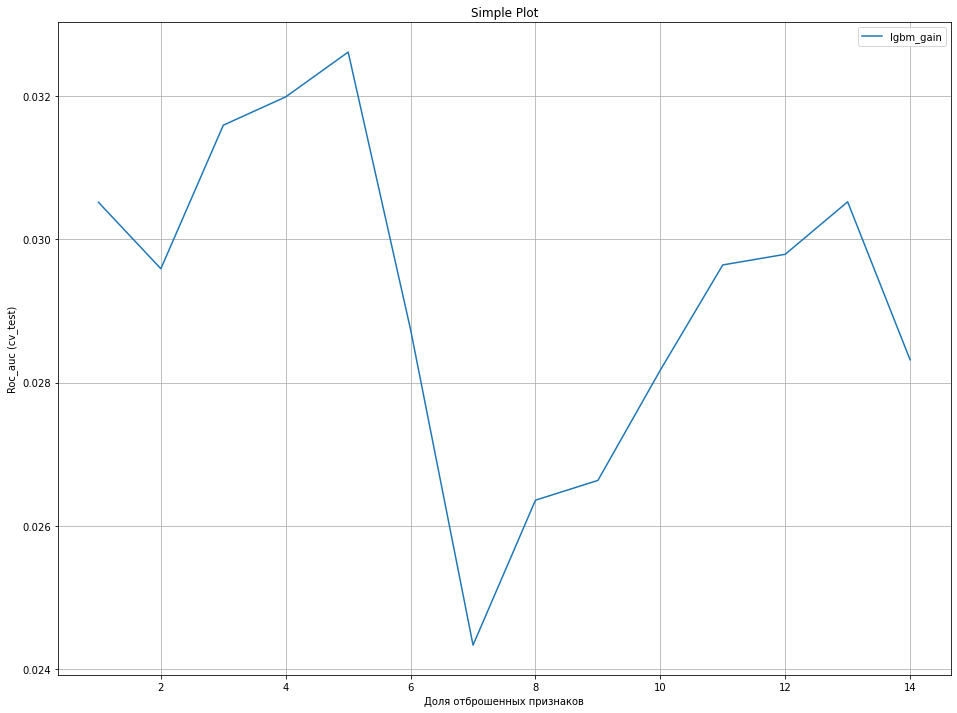

In [55]:
fig, ax = plt.subplots(figsize=(16, 12))
for i in check_index:
    ax.plot(metric_fs_cons_dif_prehype2.columns, metric_fs_cons_dif_prehype2.loc[i, :], label=i)
ax.legend()
plt.title("Simple Plot")
ax.set_xlabel('Доля отброшенных признаков')
ax.set_ylabel('r2 (cv_test)')
ax.grid(True)
plt.show()

In [56]:
fs_method = 'lgbm_gain'

lg_gain = LGBMRegressor(
    n_jobs = -1, 
    min_child_samples= min_child_samples, 
    max_depth = max_depth, 
    importance_type = 'gain', 
    random_state=random_state,
    learning_rate=learning_rate)

temp_features = check_features

for p in range(8):

    lg_gain.fit(X_train[temp_features], y_train)

    imp = pd.Series(data = lg_gain.feature_importances_, index = temp_features)

    number_of_feats = len(temp_features)
    h = int(number_of_feats * step)

    temp_features = imp.sort_values().iloc[h:].index
    print (len(temp_features))

    cv_res = cross_validate(cl, X_train[temp_features], y_train, 
    scoring= 'r2', #n_jobs = -1, 
    cv = cv_splitter, 
    return_train_score = True, verbose = 0)

    cv_train = (cv_res['train_score'] * k).sum()
    cv_test = (cv_res['test_score'].mean() * k).sum()

    metric_fs_cons_train_prehype2.loc[fs_method, p] = cv_train
    metric_fs_cons_test_prehype2.loc[fs_method, p] = cv_test

lgbm_gain_feats = temp_features

110
88
71
57
46
37
30
24


In [58]:
final_feats_log_2 = lgbm_gain_feats
final_feats_log_2

Index(['area_mkb_code_sum_norm', 'patient_sex_mkb_code_count_norm',
       'patient_id_count_litera_mkb_code_mean_12',
       'age_category_mkb_code_count', 'time_series', 'mean_id_count_area',
       'age_category_litera_2nums_mkb_code_sum', 'litera_2nums_mkb_code_vc',
       'age_category_patient_sex_sum', 'patient_sex_mkb_code_sum',
       'age_category_patient_sex_count_norm', 'area_patient_sex_sum',
       'area_mkb_code_count_norm', 'mean_id_count_sex_age_1',
       'patient_sex_mkb_code_sum_norm', 'age_category_mkb_code_sum_norm',
       'mkb_code_litera_mkb_code_sum', 'mkb_code_litera_2nums_mkb_code_count',
       'area_age_category_sum', 'area_mkb_code_count',
       'patient_id_count_area_count_shift_0', 'patient_id_count_sex_age_lgbm',
       'age_category_mkb_code_sum', 'area_mkb_code_sum'],
      dtype='object')

Получили третье признаковое пространство.

# Predict

In [26]:
final_feats1 = ['age_category_mkb_code_sum_norm', 'area_litera_2nums_mkb_code_sum',
       'area_age_category_sum_norm', 'patient_id_count_area_count_shift_0',
       'area_mkb_code_sum_norm', 'mkb_code_litera_2nums_mkb_code_count',
       'patient_id_count_litera_mkb_code_mean_12', 'time_series',
       'age_category_mkb_code_sum', 'mkb_code_litera_mkb_code_sum',
       'area_mkb_code_count', 'area_mkb_code_sum', 'patient_sex_mkb_code_sum']

In [32]:
final_feats2 = ['area_mkb_code_sum_norm', 'patient_sex_mkb_code_count_norm',
       'patient_id_count_litera_mkb_code_mean_12',
       'age_category_mkb_code_count', 'time_series', 'mean_id_count_area',
       'age_category_litera_2nums_mkb_code_sum', 'litera_2nums_mkb_code_vc',
       'age_category_patient_sex_sum', 'patient_sex_mkb_code_sum',
       'age_category_patient_sex_count_norm', 'area_patient_sex_sum',
       'area_mkb_code_count_norm', 'mean_id_count_sex_age_1',
       'patient_sex_mkb_code_sum_norm', 'age_category_mkb_code_sum_norm',
       'mkb_code_litera_mkb_code_sum', 'mkb_code_litera_2nums_mkb_code_count',
       'area_age_category_sum', 'area_mkb_code_count',
       'patient_id_count_area_count_shift_0', 'patient_id_count_sex_age_lgbm',
       'age_category_mkb_code_sum', 'area_mkb_code_sum']

## RFR1

In [24]:
model_solution = RandomForestRegressor(n_jobs = -1, random_state=42)
model_solution.fit(X_train[final_feats1], y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

<AxesSubplot:>

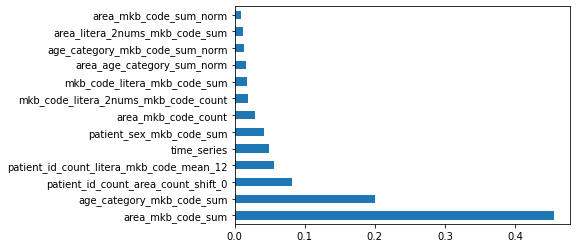

In [27]:
imp = pd.Series(data = model_solution.feature_importances_, index = final_feats1)
imp.sort_values(ascending = False).head(20).plot(kind = 'barh')

In [29]:
y_pred_solution_1 = np.exp(model_solution.predict(X_sub[final_feats1]))

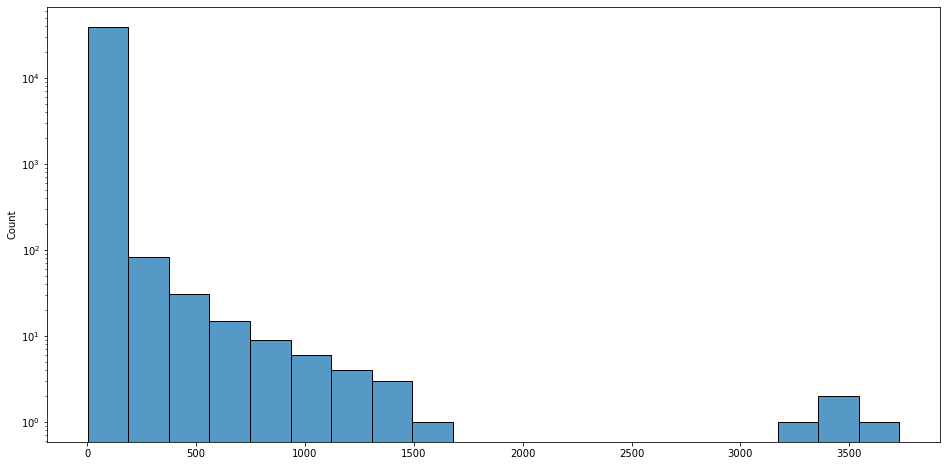

In [30]:
fig, ax = plt.subplots (figsize = (16, 8))
sns.histplot(y_pred_solution_1, bins = 20)
ax.set_yscale('log')

## RFR2

In [33]:
model_solution = RandomForestRegressor(n_jobs = -1, random_state=42)
model_solution.fit(X_train[final_feats2], y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

<AxesSubplot:>

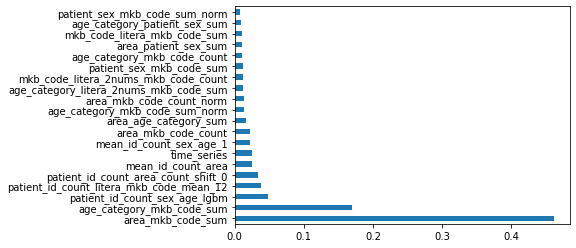

In [34]:
imp = pd.Series(data = model_solution.feature_importances_, index = final_feats2)
imp.sort_values(ascending = False).head(20).plot(kind = 'barh')

In [35]:
y_pred_solution_2 = np.exp(model_solution.predict(X_sub[final_feats2]))

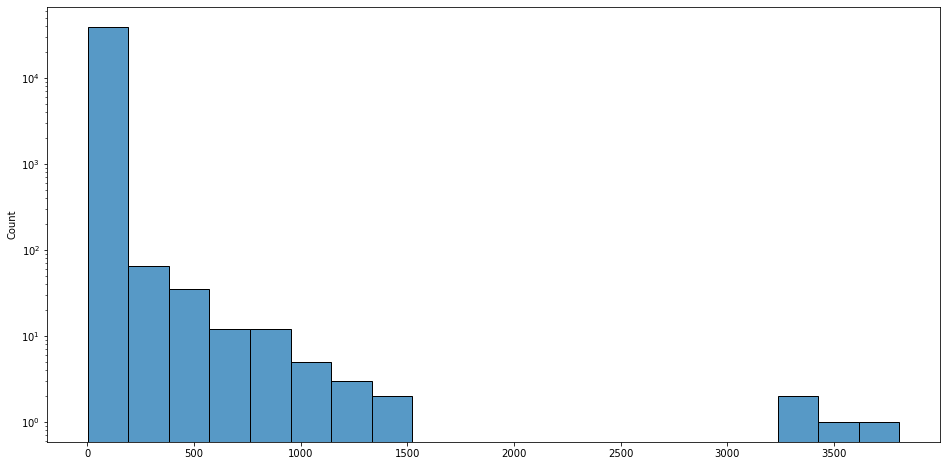

In [39]:
fig, ax = plt.subplots (figsize = (16, 8))
sns.histplot(y_pred_solution_2, bins = 20)
ax.set_yscale('log')

## ETR3

In [37]:
model_solution = ExtraTreesRegressor(n_jobs = -1, random_state=42)
model_solution.fit(X_train[final_feats1], y_train)

ExtraTreesRegressor(n_jobs=-1, random_state=42)

<AxesSubplot:>

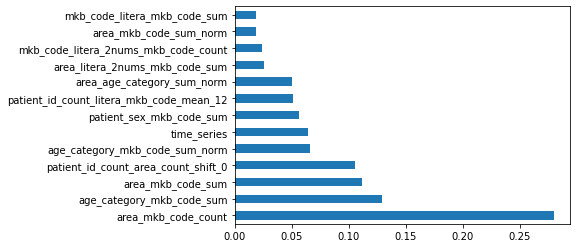

In [38]:
imp = pd.Series(data = model_solution.feature_importances_, index = final_feats1)
imp.sort_values(ascending = False).head(20).plot(kind = 'barh')

In [40]:
y_pred_solution_3 = np.exp(model_solution.predict(X_sub[final_feats1]))

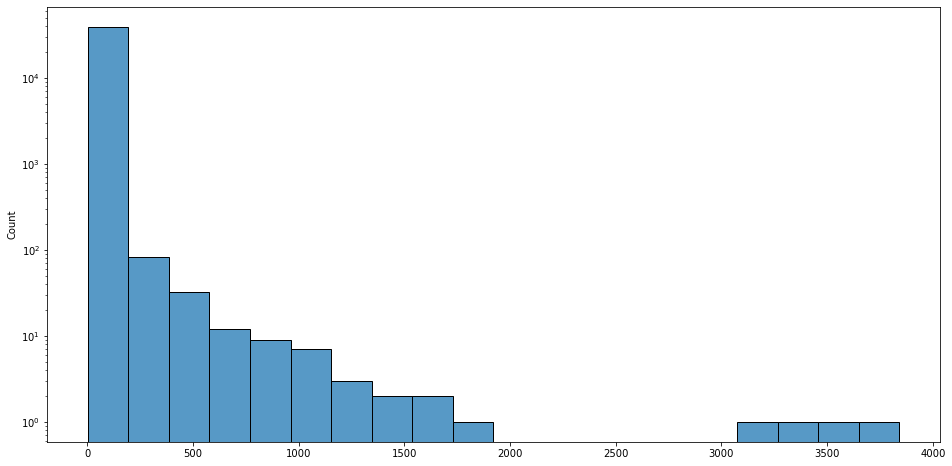

In [41]:
fig, ax = plt.subplots (figsize = (16, 8))
sns.histplot(y_pred_solution_3, bins = 20)
ax.set_yscale('log')

## ETR4

In [42]:
model_solution = ExtraTreesRegressor(n_jobs = -1, random_state=42)
model_solution.fit(X_train[final_feats2], y_train)

ExtraTreesRegressor(n_jobs=-1, random_state=42)

<AxesSubplot:>

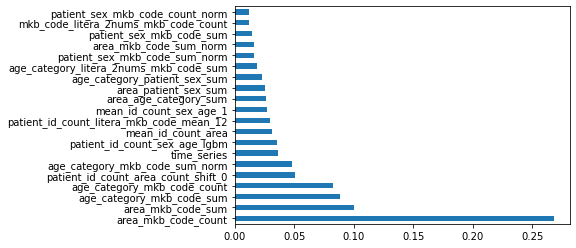

In [43]:
imp = pd.Series(data = model_solution.feature_importances_, index = final_feats2)
imp.sort_values(ascending = False).head(20).plot(kind = 'barh')

In [44]:
y_pred_solution_4 = np.exp(model_solution.predict(X_sub[final_feats2]))

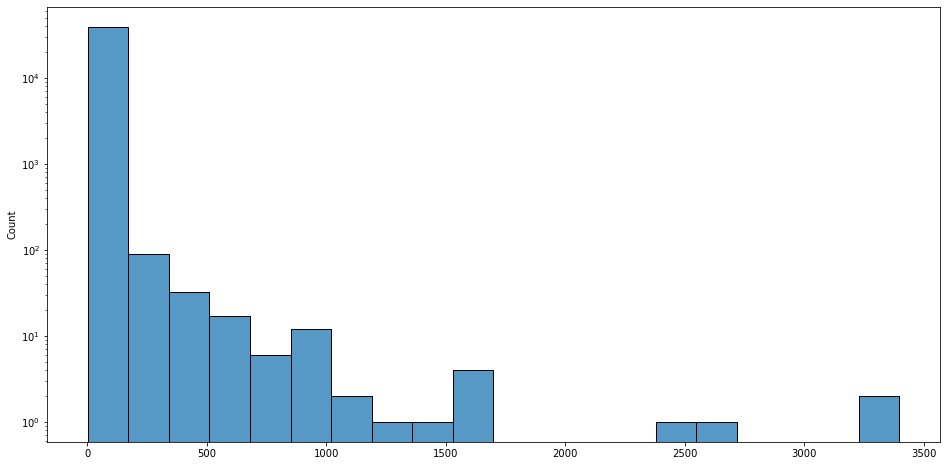

In [45]:
fig, ax = plt.subplots (figsize = (16, 8))
sns.histplot(y_pred_solution_4, bins = 20)
ax.set_yscale('log')

# Submission

Объединяем предсказания и не забудем заменить значения в городе Светлороск на единицу

In [48]:
y_pred_solution = y_pred_solution_1 * 0.1 + y_pred_solution_2 * 0.15 + y_pred_solution_3 * 0.35 + y_pred_solution_4 * 0.4

In [49]:

test = pd.read_csv('test_dataset_test.csv', sep=';', index_col=None, dtype={'PATIENT_SEX':str, 'MKB_CODE':str, 'ADRES':str, 'VISIT_MONTH_YEAR':str, 'AGE_CATEGORY':str})
test.loc[test.ADRES != 'Светлогорск', 'PATIENT_ID_COUNT'] = np.round(y_pred_solution, 0).astype(int)
test = test.fillna(1)

In [50]:
test.sample(20)

PATIENT_SEX MKB_CODE           ADRES VISIT_MONTH_YEAR  AGE_CATEGORY  \
6462            0    H52.1      Черняховск            04.22       elderly   
7562            0    I42.7     Калининград            04.22     middleage   
33226           1    M19.0         Советск            04.22           old   
5143            0    G90.9      Черняховск            04.22      children   
37953           1    Z00.0         Полесск            04.22      children   
19176           0      R51      Черняховск            04.22           old   
3731            0    F06.0      Черняховск            04.22       elderly   
8610            0    J01.0           Гусев            04.22      children   
20525           0    S90.3         Светлый            04.22     middleage   
23506           1      B86     Калининград            04.22     middleage   
36168           1    S02.6     Калининград            04.22       elderly   
36917           1    S62.6         Светлый            04.22     middleage   
34151           1    M54.9         Светлый            04.22       elderly   
38452           1    Z02.7  Краснознаменск            04.22         young   
19681           0    S30.0     Калининград            04.22  centenarians   
1584            0    D10.4         Советск            04.22     middleage   
25288           1    E74.9      Пионерский            04.22       elderly   
29016           1    I72.3     Калининград            04.22       elderly   
24367           1    D14.0     Калининград            04.22     middleage   
23984           1    C45.7     Калининград            04.22       elderly   

       PATIENT_ID_COUNT  
6462                8.0  
7562                1.0  
33226               1.0  
5143                2.0  
37953               3.0  
19176               1.0  
3731                1.0  
8610                6.0  
20525               1.0  
23506               1.0  
36168               1.0  
36917               1.0  
34151               2.0  
38452               2.0  
19681               2.0  
1584                1.0  
25288               1.0  
29016               1.0  
24367               1.0  
23984               1.0

In [52]:
# test.to_csv('sample_solution_61.csv', sep=';', index=None)

Получили свой лучший скор на лидерборде - 0.955554